### Passo 1 - Coleta dos dados

Construção do Crawler descrito no artigo


In [ ]:
!pip install requests beautifulsoup4 scholarly


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.6/55.6 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.7/161.7 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 44.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 60.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.1/121.1 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.7/512.7 kB 20.2 MB/s eta 0:00:00
  Created wheel for bibtexparser: filename=bibtexparser-1.4.3-py3-none-any.whl size=43549 sha256=c1478006a581616f4fe53c3ea769350f96f61d01688657792ed4fdd80f054dea
  Stored in directory: /root/.cache/pip/wheels/1f/7d/e9/1ff2509f13767a55df1279744adfb757f4ab94b2cbe761f56a
  Created wheel for free-proxy: filename=free_proxy-1.1.3-py3-none-any.whl size=6097 sha256=55e2680c2cef27897c29b245942d0649477a741e0f81f997dc3b885ee81c6676
  Stored in direc

In [ ]:
import requests
from bs4 import BeautifulSoup
import csv
import re
from urllib.parse import urljoin
import time
from tqdm import tqdm

def get_soup(url):
    """Faz requisição HTTP e retorna objeto BeautifulSoup"""
    try:
        headers = {
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
        }
        response = requests.get(url, headers=headers)
        response.raise_for_status()
        return BeautifulSoup(response.text, 'html.parser')
    except requests.exceptions.RequestException as e:
        print(f"❌ Erro ao acessar {url}: {e}")
        return None

def extract_year_from_issue(issue_url, issue_soup):
    """Extrai o ano da publicação da página da edição"""
    try:
        # Tenta encontrar o ano no título da página
        title_tag = issue_soup.find('title')
        if title_tag:
            title_text = title_tag.get_text()
            year_match = re.search(r'(\d{4})', title_text)
            if year_match:
                return year_match.group(1)

        # Tenta encontrar no breadcrumb ou cabeçalho
        header_selectors = [
            'h1.page_title',
            'div.page-header h1',
            'h1',
            '.breadcrumb'
        ]

        for selector in header_selectors:
            element = issue_soup.select_one(selector)
            if element:
                text = element.get_text()
                year_match = re.search(r'(\d{4})', text)
                if year_match:
                    return year_match.group(1)

        # Tenta extrair da URL como fallback
        year_match = re.search(r'(\d{4})', issue_url)
        if year_match:
            return year_match.group(1)

    except Exception as e:
        print(f"⚠️  Erro ao extrair ano: {e}")

    return "Ano não encontrado"

def extract_issue_info(issue_soup, issue_url):
    """Extrai informações da edição (número e título)"""
    try:
        # Tenta extrair o título/número da edição
        title_selectors = [
            'h1.page_title',
            'div.page-header h1',
            'h1',
            '.title'
        ]

        for selector in title_selectors:
            title_elem = issue_soup.select_one(selector)
            if title_elem:
                title_text = title_elem.get_text(strip=True)
                if title_text:
                    return title_text

        # Fallback: extrair da URL
        issue_match = re.search(r'/issue/view/(\d+)', issue_url)
        if issue_match:
            return f"Edição {issue_match.group(1)}"

    except Exception as e:
        print(f"⚠️  Erro ao extrair informação da edição: {e}")

    return "Edição não identificada"

def extract_articles_metadata(base_url):
    """Função principal para extrair metadados de todos os artigos"""
    all_articles = []

    print("🔍 Iniciando varredura na página de arquivos...")

    # Nível 1: Página de arquivos
    archive_soup = get_soup(base_url)
    if not archive_soup:
        print("❌ Falha ao acessar a página inicial")
        return all_articles

    # Encontrar links para todas as edições
    issues_links = []
    issues_container = archive_soup.find('div', id='issues')

    if issues_container:
        for link in issues_container.find_all('a', href=True):
            href = link['href']
            if '/issue/view/' in href:
                full_url = urljoin(base_url, href)
                if full_url not in issues_links:
                    issues_links.append(full_url)
    else:
        # Fallback: procura em toda a página
        for link in archive_soup.find_all('a', href=True):
            href = link['href']
            if '/issue/view/' in href:
                full_url = urljoin(base_url, href)
                if full_url not in issues_links:
                    issues_links.append(full_url)

    print(f"📚 Encontradas {len(issues_links)} edições para processar")

    if not issues_links:
        print("❌ Nenhuma edição encontrada!")
        return all_articles

    # Processar cada edição com barra de progresso
    for issue_index, issue_url in enumerate(issues_links, 1):
        print(f"\n{'='*60}")
        print(f"🎯 PROCESSANDO EDIÇÃO {issue_index}/{len(issues_links)}")
        print(f"🔗 URL: {issue_url}")

        # Nível 2: Página da edição
        issue_soup = get_soup(issue_url)
        if not issue_soup:
            print(f"❌ Falha ao acessar edição: {issue_url}")
            continue

        # Extrair informações da edição
        year = extract_year_from_issue(issue_url, issue_soup)
        issue_info = extract_issue_info(issue_soup, issue_url)

        print(f"📅 Ano: {year}")
        print(f"📖 Edição: {issue_info}")

        # Encontrar links para artigos
        article_links = []

        # Procura em diferentes possíveis estruturas
        selectors_to_try = [
            'div.obj_article_summary .title a',
            'div.article-summary .title a',
            'div.article a.title',
            'h3.title a',
            'a.file',
            'a.title'
        ]

        for selector in selectors_to_try:
            article_links_elements = issue_soup.select(selector)
            for link_element in article_links_elements:
                href = link_element.get('href')
                if href and '/article/view/' in href:
                    full_article_url = urljoin(issue_url, href)
                    if full_article_url not in article_links:
                        article_links.append(full_article_url)
            if article_links:
                break

        # Fallback: procura em toda a página
        if not article_links:
            for link in issue_soup.find_all('a', href=True):
                href = link['href']
                if '/article/view/' in href:
                    full_article_url = urljoin(issue_url, href)
                    if full_article_url not in article_links:
                        article_links.append(full_article_url)

        print(f"📄 Encontrados {len(article_links)} artigos nesta edição")

        if not article_links:
            print("⚠️  Nenhum artigo encontrado nesta edição")
            continue

        # Processar cada artigo com barra de progresso
        for i, article_url in enumerate(tqdm(article_links, desc=f"📝 {year} - {issue_info[:30]}...", unit="artigo")):
            print(f"\n   🔍 Processando artigo {i+1}/{len(article_links)}")
            print(f"   🔗 URL: {article_url}")

            article_data = process_article_page(article_url, year, issue_info)
            if article_data:
                all_articles.append(article_data)
                # Mostrar dados coletados
                print(f"   ✅ DADOS COLETADOS:")
                print(f"      📅 Ano: {article_data['ano']}")
                print(f"      📖 Edição: {article_data['edicao']}")
                print(f"      📝 Título: {article_data['titulo'][:100]}{'...' if len(article_data['titulo']) > 100 else ''}")
                print(f"      👥 Autores: {article_data['autores']}")
                print(f"      🏛️  Instituições: {article_data['instituicoes']}")
                print(f"      🔑 Palavras-chave: {article_data['palavras_chave']}")
                print(f"   {'─'*50}")
            else:
                print(f"   ❌ Falha ao processar artigo")

            # Delay para não sobrecarregar o servidor
            time.sleep(0.5)

    return all_articles

def process_article_page(article_url, year, issue_info):
    """Extrai metadados de uma página individual de artigo"""
    article_soup = get_soup(article_url)
    if not article_soup:
        return None

    metadata = {
        'ano': year,
        'edicao': issue_info,
        'titulo': '',
        'autores': [],
        'instituicoes': [],
        'palavras_chave': []
    }

    try:
        # Extrair título - múltiplos seletores possíveis
        title_selectors = [
            'h1.page_title',
            'h1',
            '.title',
            'div.page-header h1',
            'h2.article-title',
            'div.article-title h1'
        ]

        for selector in title_selectors:
            title_elem = article_soup.select_one(selector)
            if title_elem:
                metadata['titulo'] = title_elem.get_text(strip=True)
                if metadata['titulo']:
                    break

        # ESTRATÉGIA MELHORADA PARA AUTORES
        # Método 1: Buscar por meta tags (mais confiável)
        author_meta_tags = article_soup.find_all('meta', attrs={'name': 'citation_author'})
        if author_meta_tags:
            for meta in author_meta_tags:
                author_name = meta.get('content', '').strip()
                if author_name and author_name not in metadata['autores']:
                    metadata['autores'].append(author_name)

        # Método 2: Buscar em seções específicas de autores
        if not metadata['autores']:
            author_sections = article_soup.find_all(['div', 'section'], class_=re.compile(r'author|authors|contributor'))
            for section in author_sections:
                # Tentar encontrar nomes em spans, divs ou links
                author_elements = section.find_all(['span', 'div', 'a'], class_=re.compile(r'name|author|contributor'))
                for elem in author_elements:
                    author_name = elem.get_text(strip=True)
                    if author_name and len(author_name) > 2 and author_name not in metadata['autores']:
                        metadata['autores'].append(author_name)

        # Método 3: Buscar por padrões de texto
        if not metadata['autores']:
            # Procurar por texto que contenha "Autor" ou "Author"
            author_patterns = [
                r'Autores?:\s*(.+)',
                r'Authors?:\s*(.+)',
                r'Contributors?:\s*(.+)'
            ]

            for pattern in author_patterns:
                matches = article_soup.find_all(string=re.compile(pattern, re.IGNORECASE))
                for match in matches:
                    author_text = re.search(pattern, match, re.IGNORECASE)
                    if author_text:
                        authors_found = author_text.group(1).strip()
                        # Separar autores por vírgula, ponto e vírgula ou "and"
                        authors_list = re.split(r'[;,]\s*|\s+and\s+', authors_found)
                        for author in authors_list:
                            if author and author not in metadata['autores']:
                                metadata['autores'].append(author.strip())

        # ESTRATÉGIA MELHORADA PARA INSTITUIÇÕES
        # Método 1: Buscar por meta tags de afiliação
        affiliation_meta_tags = article_soup.find_all('meta', attrs={'name': 'citation_author_institution'})
        if affiliation_meta_tags:
            for meta in affiliation_meta_tags:
                institution = meta.get('content', '').strip()
                if institution and institution not in metadata['instituicoes']:
                    metadata['instituicoes'].append(institution)

        # Método 2: Buscar em seções de afiliação
        if not metadata['instituicoes']:
            affiliation_selectors = [
                '.affiliation',
                '.affiliation_name',
                '.institution',
                '.organization',
                'div.affiliation',
                'span.affiliation'
            ]

            for selector in affiliation_selectors:
                affiliations = article_soup.select(selector)
                for aff in affiliations:
                    institution = aff.get_text(strip=True)
                    if institution and len(institution) > 3 and institution not in metadata['instituicoes']:
                        metadata['instituicoes'].append(institution)

        # Extrair palavras-chave
        keyword_selectors = [
            'div.item.keywords',
            '.keywords',
            'div.keywords',
            '.article-keywords',
            'meta[name="citation_keywords"]'
        ]

        for selector in keyword_selectors:
            if selector.startswith('meta'):
                keyword_meta = article_soup.select_one(selector)
                if keyword_meta:
                    keywords_content = keyword_meta.get('content', '')
                    if keywords_content:
                        keywords_list = [k.strip() for k in re.split('[,;]', keywords_content) if k.strip()]
                        metadata['palavras_chave'] = keywords_list
                        break
            else:
                keywords_section = article_soup.select_one(selector)
                if keywords_section:
                    keywords_value = keywords_section.find(['span', 'div'], class_='value')
                    if keywords_value:
                        keywords_text = keywords_value.get_text(strip=True)
                    else:
                        keywords_text = keywords_section.get_text(strip=True)

                    # Limpa o texto (remove label)
                    keywords_text = re.sub(r'palavras[-\s]?chave:\s*', '', keywords_text, flags=re.IGNORECASE)
                    keywords_text = re.sub(r'keywords?:\s*', '', keywords_text, flags=re.IGNORECASE)

                    # Separa palavras-chave
                    if keywords_text:
                        keywords_list = [k.strip() for k in re.split('[,;]', keywords_text) if k.strip()]
                        metadata['palavras_chave'] = keywords_list
                        break

        # Limpar e formatar dados
        metadata = clean_metadata(metadata)

        return metadata

    except Exception as e:
        print(f"❌ Erro ao processar artigo {article_url}: {e}")
        return None

def clean_metadata(metadata):
    """Remove espaços excessivos e formata listas"""
    cleaned = metadata.copy()

    # Limpar título
    cleaned['titulo'] = ' '.join(cleaned['titulo'].split())

    # Limpar listas e juntar com ponto-e-vírgula
    cleaned['autores'] = '; '.join([' '.join(a.split()) for a in cleaned['autores'] if a.strip()])
    cleaned['instituicoes'] = '; '.join([' '.join(i.split()) for i in cleaned['instituicoes'] if i.strip()])
    cleaned['palavras_chave'] = '; '.join([' '.join(k.split()) for k in cleaned['palavras_chave'] if k.strip()])

    return cleaned

def save_to_csv(articles_data, filename):
    """Salva os dados extraídos em arquivo CSV"""
    if not articles_data:
        print("❌ Nenhum dado para salvar")
        return

    with open(filename, 'w', newline='', encoding='utf-8') as csvfile:
        fieldnames = ['ano', 'edicao', 'titulo', 'autores', 'instituicoes', 'palavras_chave']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames, quoting=csv.QUOTE_ALL)

        writer.writeheader()
        for article in articles_data:
            writer.writerow(article)

    print(f"💾 Dados salvos em {filename}")

def main():
    """Função principal"""
    base_url = "https://sol.sbc.org.br/index.php/brasnam/issue/archive"
    output_file = "dados_brasnam_sol.csv"

    print("🚀 Iniciando extração de metadados do BraSNAM...")
    print("=" * 60)

    # Extrair metadados
    articles_data = extract_articles_metadata(base_url)

    print("\n" + "=" * 60)
    print("📊 RESUMO DA EXTRAÇÃO:")
    print(f"   Total de artigos processados: {len(articles_data)}")

    if articles_data:
        # Estatísticas
        anos = set(article['ano'] for article in articles_data)
        edicoes = set(article['edicao'] for article in articles_data)

        print(f"   Período abrangido: {', '.join(sorted(anos))}")
        print(f"   Edições processadas: {len(edicoes)}")

        # Salvar em CSV
        save_to_csv(articles_data, output_file)

        print(f"\n✅ Processo concluído com sucesso!")
        print(f"📁 Arquivo gerado: {output_file}")
    else:
        print("❌ Nenhum artigo foi extraído. Verifique a conexão e a estrutura do site.")

if __name__ == "__main__":
    main()

🚀 Iniciando extração de metadados do BraSNAM...
🔍 Iniciando varredura na página de arquivos...
📚 Encontradas 14 edições para processar

🎯 PROCESSANDO EDIÇÃO 1/14
🔗 URL: https://sol.sbc.org.br/index.php/brasnam/issue/view/1543


KeyboardInterrupt: 

###Passo 1.2 - Coleta manual de quantidade de citações

In [ ]:
import pandas as pd
from urllib.parse import quote
import numpy as np
import os

def main():
    # Configurações
    input_file = 'dados_brasnam_sol.csv'
    output_file = 'dados_brasnam_com_citacoes.csv'
    checkpoint_interval = 10

    try:
        # Carregar dados do arquivo CSV
        df = pd.read_csv(input_file)
        print(f"Carregados {len(df)} artigos do arquivo {input_file}\n")

        # Verificar se já existe um arquivo de checkpoint
        if os.path.exists(output_file):
            resposta = input(f"Arquivo {output_file} já existe. Deseja continuar daqui? (s/N): ")
            if resposta.lower() == 's':
                df = pd.read_csv(output_file)
                print("Continuando da coleta anterior...")
            else:
                df['citacoes'] = np.nan
                print("Iniciando nova coleta...")
        else:
            df['citacoes'] = np.nan
            print("Iniciando coleta do zero...")

        # Iterar pelos artigos
        for idx, row in df.iterrows():
            if pd.notna(row['citacoes']):
                continue

            titulo = row['titulo']
            print(f"\n--- Artigo {idx + 1}/{len(df)} ---")
            print(f"Título: {titulo}")

            # Criar URL de busca
            query = quote(titulo)
            url = f'https://scholar.google.com/scholar?q="{query}"'
            print(f"URL de busca: {url}")

            # Coletar citações
            while True:
                try:
                    entrada = input("Número de citações (ou 0 se não encontrado): ")
                    citacoes = int(entrada)
                    if citacoes >= 0:
                        break
                    else:
                        print("Por favor, digite um número não negativo.")
                except ValueError:
                    print("Entrada inválida! Digite um número inteiro.")

            # Atualizar DataFrame
            df.at[idx, 'citacoes'] = citacoes

            # Salvar checkpoint
            if (idx + 1) % checkpoint_interval == 0:
                df.to_csv(output_file, index=False)
                print(f"\nCheckpoint salvo após {idx + 1} artigos.")

        # Salvar resultado final
        df.to_csv(output_file, index=False)
        print(f"\nColeta concluída! Resultados salvos em {output_file}")

    except FileNotFoundError:
        print(f"Erro: Arquivo {input_file} não encontrado.")
    except Exception as e:
        print(f"Erro inesperado: {str(e)}")

if __name__ == "__main__":
    main()

Carregados 355 artigos do arquivo dados_brasnam_sol.csv

Iniciando coleta do zero...

--- Artigo 1/355 ---
Título: Evolution of Scientific Interests: A Time-Aware Recommender System
URL de busca: https://scholar.google.com/scholar?q="Evolution%20of%20Scientific%20Interests%3A%20A%20Time-Aware%20Recommender%20System"
Número de citações (ou 0 se não encontrado): 0

--- Artigo 2/355 ---
Título: Avaliação de uma Abordagem Hierárquica para Predição de Faixa Etária de Autores de Textos Escritos em Português
URL de busca: https://scholar.google.com/scholar?q="Avalia%C3%A7%C3%A3o%20de%20uma%20Abordagem%20Hier%C3%A1rquica%20para%20Predi%C3%A7%C3%A3o%20de%20Faixa%20Et%C3%A1ria%20de%20Autores%20de%20Textos%20Escritos%20em%20Portugu%C3%AAs"
Número de citações (ou 0 se não encontrado): 0

--- Artigo 3/355 ---
Título: VISAGE: Detection and automatic classification of urban violence through social media data
URL de busca: https://scholar.google.com/scholar?q="VISAGE%3A%20Detection%20and%20automatic%2

KeyboardInterrupt: Interrupted by user

### Passo 1.3 - Inferência de gênero com API IBGE

In [ ]:
import pandas as pd
import requests
import time
from tqdm import tqdm

# URL da API do IBGE (versão v1 como no código original)
url = 'http://servicodados.ibge.gov.br/api/v1/censos/nomes/basica'

def get_gender(nome):
    """
    Função baseada no código original do autor para inferir gênero
    """
    name = nome
    args_f = {'nome': name, 'sexo': 'f'}
    r_f = requests.get(url, args_f)

    args_m = {'nome': name, 'sexo': 'm'}
    r_m = requests.get(url, args_m)

    if r_m.text == '[]' and r_f.text == '[]':
        sexo = 'Indefinido'
    else:
        if r_m.text != '[]' and r_f.text != '[]':
            f = r_f.json()[0]['rank']
            m = r_m.json()[0]['rank']

            if f < m:
                sexo = 'Feminino'
            else:
                sexo = 'Masculino'
        if r_m.text != '[]' and r_f.text == '[]':
            sexo = 'Masculino'
        if r_m.text == '[]' and r_f.text != '[]':
            sexo = 'Feminino'
    return sexo

def inferir_genero_autores():
    print("🚀 Iniciando processo de inferência de gênero dos autores...")
    print("=" * 60)

    # Lê o arquivo CSV com os dados
    try:
        df = pd.read_csv('dados_brasnam_com_citacoes.csv')
        print("✅ Arquivo 'dados_brasnam_com_citacoes.csv' carregado com sucesso!")
        print(f"📊 Total de publicações no dataset: {len(df)}")
    except FileNotFoundError:
        print("❌ Erro: Arquivo 'dados_brasnam_com_citacoes.csv' não encontrado!")
        return
    except Exception as e:
        print(f"❌ Erro ao ler o arquivo: {e}")
        return

    # Extrai e processa os nomes únicos de autores
    print("\n🔍 Extraindo nomes únicos de autores...")
    autores_unicos = set()
    for autores in df['autores'].dropna():
        lista_autores = [autor.strip() for autor in autores.split(';')]
        autores_unicos.update(lista_autores)

    autores_lista = list(autores_unicos)
    print(f"✅ Total de autores únicos identificados: {len(autores_lista)}")

    # Mostra alguns exemplos
    print(f"📝 Exemplos de autores: {list(autores_lista)[:3]}...")

    # Dicionário para armazenar os resultados
    genero_por_autor = {}
    estatisticas = {'Masculino': 0, 'Feminino': 0, 'Indefinido': 0}

    print("\n🌐 Iniciando consultas à API do IBGE (v1)...")
    print("=" * 60)

    # Consulta à API para cada autor único com barra de progresso
    for autor_completo in tqdm(autores_lista, desc="Processando autores", unit="autor"):
        # Extrai apenas o primeiro nome para a consulta
        primeiro_nome = autor_completo.split()[0] if autor_completo.split() else autor_completo

        try:
            genero_inferido = get_gender(primeiro_nome)
            estatisticas[genero_inferido] += 1

        except requests.exceptions.Timeout:
            print(f"⏰ Timeout para: {autor_completo}")
            genero_inferido = 'Indefinido'
            estatisticas['Indefinido'] += 1
        except requests.exceptions.ConnectionError:
            print(f"🔌 Erro de conexão para: {autor_completo}")
            genero_inferido = 'Indefinido'
            estatisticas['Indefinido'] += 1
        except Exception as e:
            print(f"❌ Erro inesperado para {autor_completo}: {e}")
            genero_inferido = 'Indefinido'
            estatisticas['Indefinido'] += 1

        genero_por_autor[autor_completo] = genero_inferido

        # Feedback em tempo real para cada autor
        emoji = "👨" if genero_inferido == "Masculino" else "👩" if genero_inferido == "Feminino" else "❓"
        print(f"  {emoji} {autor_completo} → {genero_inferido}")

        time.sleep(0.1)  # Intervalo entre requisições

    print("\n" + "=" * 60)
    print("📈 ESTATÍSTICAS FINAIS:")
    print(f"   Masculino: {estatisticas['Masculino']} autores")
    print(f"   Feminino: {estatisticas['Feminino']} autores")
    print(f"   Indefinido: {estatisticas['Indefinido']} autores")

    total = sum(estatisticas.values())
    if total > 0:
        print(f"   Taxa de sucesso: {((estatisticas['Masculino'] + estatisticas['Feminino']) / total * 100):.1f}%")

    # Cria arquivo com mapeamento de autores únicos
    print("\n💾 Salvando mapeamento de autores únicos...")
    df_autores_unicos = pd.DataFrame(list(genero_por_autor.items()),
                                     columns=['autor', 'genero_inferido'])

    try:
        df_autores_unicos.to_csv('autores_com_genero.csv', index=False)
        print("✅ Arquivo 'autores_com_genero.csv' salvo com sucesso!")
    except Exception as e:
        print(f"❌ Erro ao salvar o arquivo de autores únicos: {e}")

    # Adiciona coluna de gênero ao dataset original
    print("\n🔧 Enriquecendo dataset original com gênero dos autores...")

    def obter_generos_autores(lista_autores):
        """Função auxiliar para obter gêneros de uma lista de autores"""
        if pd.isna(lista_autores):
            return None
        autores = [autor.strip() for autor in lista_autores.split(';')]
        generos = [genero_por_autor.get(autor, 'Indefinido') for autor in autores]
        return ';'.join(generos)

    # Aplica a função para criar nova coluna
    df['generos_autores'] = df['autores'].apply(obter_generos_autores)

    # Salva dataset completo enriquecido
    try:
        df.to_csv('dados_brasnam_com_genero.csv', index=False)
        print("✅ Arquivo 'dados_brasnam_com_genero.csv' salvo com sucesso!")
        print(f"📊 Dataset completo com {len(df)} publicações enriquecido com gênero dos autores")
    except Exception as e:
        print(f"❌ Erro ao salvar o dataset completo: {e}")

    # Mostra uma amostra dos resultados
    print("\n🔍 AMOSTRA DOS RESULTADOS:")
    print("=" * 50)
    sample_size = min(10, len(df_autores_unicos))
    for i, row in df_autores_unicos.head(sample_size).iterrows():
        emoji = "👨" if row['genero_inferido'] == "Masculino" else "👩" if row['genero_inferido'] == "Feminino" else "❓"
        print(f"  {i+1:2d}. {emoji} {row['autor']:<30} → {row['genero_inferido']}")

    if len(df_autores_unicos) > sample_size:
        print(f"  ... e mais {len(df_autores_unicos) - sample_size} autores")

    print("\n🎉 Processo concluído com sucesso!")
    print("📁 Arquivos gerados:")
    print("   - autores_com_genero.csv (mapeamento autores únicos → gênero)")
    print("   - dados_brasnam_com_genero.csv (dataset completo enriquecido)")

if __name__ == "__main__":
    inferir_genero_autores()

🚀 Iniciando processo de inferência de gênero dos autores...
✅ Arquivo 'dados_brasnam_com_citacoes.csv' carregado com sucesso!
📊 Total de publicações no dataset: 355

🔍 Extraindo nomes únicos de autores...
✅ Total de autores únicos identificados: 931
📝 Exemplos de autores: ['Ana P. C. Silva', 'Marcelo P. Souza', 'Josemar Alves Caetano']...

🌐 Iniciando consultas à API do IBGE (v1)...


Processando autores:   0%|          | 1/931 [00:01<18:12,  1.17s/autor]

  👩 Ana P. C. Silva → Feminino


Processando autores:   0%|          | 2/931 [00:01<14:59,  1.03autor/s]

  👨 Marcelo P. Souza → Masculino


Processando autores:   0%|          | 3/931 [00:02<13:58,  1.11autor/s]

  👨 Josemar Alves Caetano → Masculino


Processando autores:   0%|          | 4/931 [00:03<13:24,  1.15autor/s]

  👩 Melissa Sousa Felipe → Feminino


Processando autores:   1%|          | 5/931 [00:04<13:08,  1.17autor/s]

  👨 Manuel Almeida → Masculino


Processando autores:   1%|          | 6/931 [00:05<12:59,  1.19autor/s]

  👨 Inácio de Souza Fadigas → Masculino


Processando autores:   1%|          | 7/931 [00:06<12:52,  1.20autor/s]

  👨 Lucas N. Ferreira → Masculino


Processando autores:   1%|          | 8/931 [00:06<12:44,  1.21autor/s]

  👨 Marcelo do Vale Cunha → Masculino


Processando autores:   1%|          | 9/931 [00:07<12:43,  1.21autor/s]

  👩 Samara Guimarães → Feminino


Processando autores:   1%|          | 10/931 [00:08<12:42,  1.21autor/s]

  👨 Douglas Vitório → Masculino


Processando autores:   1%|          | 11/931 [00:09<12:40,  1.21autor/s]

  👩 Daniele V. Ferreira → Feminino


Processando autores:   1%|▏         | 12/931 [00:10<12:38,  1.21autor/s]

  👨 Vítor Baptista → Masculino


Processando autores:   1%|▏         | 13/931 [00:11<12:34,  1.22autor/s]

  👨 Kellyton Brito → Masculino


Processando autores:   2%|▏         | 14/931 [00:11<12:34,  1.22autor/s]

  👨 Paulo R. S. Soares → Masculino


Processando autores:   2%|▏         | 15/931 [00:12<12:33,  1.22autor/s]

  👨 Moacir Lopes de Mendonça Junior → Masculino


Processando autores:   2%|▏         | 16/931 [00:13<12:33,  1.21autor/s]

  👨 Rilder S. Pires → Masculino


Processando autores:   2%|▏         | 17/931 [00:14<12:34,  1.21autor/s]

  👩 Elisa Maria B. A. Ribeiro → Feminino


Processando autores:   2%|▏         | 18/931 [00:15<12:32,  1.21autor/s]

  👨 Marcus Vinicius Carvalho Guelpeli → Masculino


Processando autores:   2%|▏         | 19/931 [00:15<12:32,  1.21autor/s]

  👨 Geilson Andrade → Masculino


Processando autores:   2%|▏         | 20/931 [00:16<12:30,  1.21autor/s]

  👨 Felipe P. C. Fonseca → Masculino


Processando autores:   2%|▏         | 21/931 [00:17<12:30,  1.21autor/s]

  👨 Rafael V. M. Santos → Masculino


Processando autores:   2%|▏         | 22/931 [00:18<12:28,  1.21autor/s]

  👩 Jonice Oliveira → Feminino


Processando autores:   2%|▏         | 23/931 [00:19<12:28,  1.21autor/s]

  👨 Gilberto Flores Pochet → Masculino


Processando autores:   3%|▎         | 24/931 [00:20<12:27,  1.21autor/s]

  👨 Diogo Pacheco → Masculino


Processando autores:   3%|▎         | 25/931 [00:20<12:26,  1.21autor/s]

  👨 George D. C. Cavalcanti → Masculino


Processando autores:   3%|▎         | 26/931 [00:21<12:25,  1.21autor/s]

  👨 Daniel Dalip → Masculino


Processando autores:   3%|▎         | 27/931 [00:22<12:25,  1.21autor/s]

  👨 Rafael J. P. Damaceno → Masculino


Processando autores:   3%|▎         | 28/931 [00:23<12:24,  1.21autor/s]

  👨 Geraldo Zimbrão → Masculino


Processando autores:   3%|▎         | 29/931 [00:24<12:23,  1.21autor/s]

  👨 Leandro A. Silva → Masculino


Processando autores:   3%|▎         | 30/931 [00:25<12:22,  1.21autor/s]

  👨 Gilderlanio Araújo → Masculino


Processando autores:   3%|▎         | 31/931 [00:25<12:22,  1.21autor/s]

  👩 Kênia Carolina Gonçalves → Feminino


Processando autores:   3%|▎         | 32/931 [00:26<12:22,  1.21autor/s]

  👨 Luan S. Oliveira → Masculino


Processando autores:   4%|▎         | 33/931 [00:27<12:21,  1.21autor/s]

  👨 César A. B. de Andrade → Masculino


Processando autores:   4%|▎         | 34/931 [00:28<12:20,  1.21autor/s]

  👩 Maria Santana → Feminino


Processando autores:   4%|▍         | 35/931 [00:29<12:19,  1.21autor/s]

  👨 João Martins de Oliveira Neto → Masculino


Processando autores:   4%|▍         | 36/931 [00:30<12:21,  1.21autor/s]

  👨 Sérgio Teixeira de Carvalho → Masculino


Processando autores:   4%|▍         | 37/931 [00:30<12:27,  1.20autor/s]

  👨 Danilo Araújo → Masculino


Processando autores:   4%|▍         | 38/931 [00:31<12:20,  1.21autor/s]

  👨 Fernando Pontes → Masculino


Processando autores:   4%|▍         | 39/931 [00:32<12:19,  1.21autor/s]

  👩 Maria Luiza Machado Campos → Feminino


Processando autores:   4%|▍         | 40/931 [00:33<12:17,  1.21autor/s]

  👩 Bianca Munaro Lima → Feminino


Processando autores:   4%|▍         | 41/931 [00:34<12:15,  1.21autor/s]

  👨 João Gama → Masculino


Processando autores:   5%|▍         | 42/931 [00:34<12:13,  1.21autor/s]

  👩 Michele A. Brandão → Feminino


Processando autores:   5%|▍         | 43/931 [00:35<12:12,  1.21autor/s]

  👨 Carlos Kamienski → Masculino


Processando autores:   5%|▍         | 44/931 [00:36<12:11,  1.21autor/s]

  👨 Leonardo B. Oliveira → Masculino


Processando autores:   5%|▍         | 45/931 [00:37<12:10,  1.21autor/s]

  👩 Claudia Ribeiro Lopes → Feminino


Processando autores:   5%|▍         | 46/931 [00:38<12:10,  1.21autor/s]

  👩 Jaqueline Faria de Oliveira → Feminino


Processando autores:   5%|▌         | 47/931 [00:39<12:09,  1.21autor/s]

  👩 Thayane Guimarães → Feminino


Processando autores:   5%|▌         | 48/931 [00:39<12:08,  1.21autor/s]

  👨 Dante Galeffi → Masculino


Processando autores:   5%|▌         | 49/931 [00:40<12:10,  1.21autor/s]

  👨 Bruno Osiek → Masculino


Processando autores:   5%|▌         | 50/931 [00:41<12:05,  1.21autor/s]

  👨 Lucas A. M. L. Andre → Masculino


Processando autores:   5%|▌         | 51/931 [00:42<12:05,  1.21autor/s]

  👨 José Maria Monteiro → Masculino


Processando autores:   6%|▌         | 52/931 [00:43<12:04,  1.21autor/s]

  👨 Vinícius da F. Vieira → Masculino


Processando autores:   6%|▌         | 53/931 [00:44<12:04,  1.21autor/s]

  👨 Yago Santos → Masculino


Processando autores:   6%|▌         | 54/931 [00:44<12:03,  1.21autor/s]

  ❓ J. L. B. de Araújo → Indefinido


Processando autores:   6%|▌         | 55/931 [00:45<12:02,  1.21autor/s]

  👨 Vinícius T. de Castro Pires → Masculino


Processando autores:   6%|▌         | 56/931 [00:46<12:01,  1.21autor/s]

  👨 Fabricio Faria → Masculino


Processando autores:   6%|▌         | 57/931 [00:47<12:00,  1.21autor/s]

  👨 Daniel M. Barbosa → Masculino


Processando autores:   6%|▌         | 58/931 [00:48<11:59,  1.21autor/s]

  👨 Geraldo P. Rocha Filho → Masculino


Processando autores:   6%|▋         | 59/931 [00:49<12:00,  1.21autor/s]

  👨 Bernardo Pereira Lauand → Masculino


Processando autores:   6%|▋         | 60/931 [00:49<12:01,  1.21autor/s]

  👩 Kate Revoredo → Feminino


Processando autores:   7%|▋         | 61/931 [00:50<11:59,  1.21autor/s]

  👨 Eder Pereira → Masculino


Processando autores:   7%|▋         | 62/931 [00:51<11:58,  1.21autor/s]

  👩 Mariza Ferro → Feminino


Processando autores:   7%|▋         | 63/931 [00:52<11:57,  1.21autor/s]

  👨 Carlos Renato Lisboa Francês → Masculino


Processando autores:   7%|▋         | 64/931 [00:53<11:56,  1.21autor/s]

  👨 Orlando B. Coelho → Masculino


Processando autores:   7%|▋         | 65/931 [00:53<11:54,  1.21autor/s]

  👨 João Pedro M. Sena → Masculino


Processando autores:   7%|▋         | 66/931 [00:54<11:54,  1.21autor/s]

  👨 Alexandre Evsukoff → Masculino


Processando autores:   7%|▋         | 67/931 [00:55<11:49,  1.22autor/s]

  👨 Tiago França → Masculino


Processando autores:   7%|▋         | 68/931 [00:56<11:46,  1.22autor/s]

  👨 Marco Antonio Casanova → Masculino


Processando autores:   7%|▋         | 69/931 [00:57<11:48,  1.22autor/s]

  👨 José Maria David → Masculino


Processando autores:   8%|▊         | 70/931 [00:58<11:49,  1.21autor/s]

  👨 Marcos Paulo Soares Moura Filho → Masculino


Processando autores:   8%|▊         | 71/931 [00:58<11:48,  1.21autor/s]

  👨 Wagner Meira Junior → Masculino


Processando autores:   8%|▊         | 72/931 [00:59<11:48,  1.21autor/s]

  👨 Benjamin Herfort → Masculino


Processando autores:   8%|▊         | 73/931 [01:00<11:49,  1.21autor/s]

  👩 Cristina B. Alves → Feminino


Processando autores:   8%|▊         | 74/931 [01:01<11:45,  1.22autor/s]

  👩 Juliana Vianna → Feminino


Processando autores:   8%|▊         | 75/931 [01:02<11:44,  1.21autor/s]

  👨 Carlos J. P. de Lucena → Masculino


Processando autores:   8%|▊         | 76/931 [01:03<11:43,  1.21autor/s]

  👨 Arthur I. R. Carvalho → Masculino


Processando autores:   8%|▊         | 77/931 [01:03<11:43,  1.21autor/s]

  👨 Diogenes S. Pedro → Masculino


Processando autores:   8%|▊         | 78/931 [01:04<11:42,  1.21autor/s]

  👨 Rodolpho da Silva Nascimento → Masculino


Processando autores:   8%|▊         | 79/931 [01:05<11:44,  1.21autor/s]

  👩 Carolina Xavier → Feminino


Processando autores:   9%|▊         | 80/931 [01:06<11:43,  1.21autor/s]

  👩 Vládia Pinheiro → Feminino


Processando autores:   9%|▊         | 81/931 [01:07<11:42,  1.21autor/s]

  👨 Marcos Gonçalves → Masculino


Processando autores:   9%|▉         | 82/931 [01:07<11:38,  1.22autor/s]

  👨 Alexandre Alves → Masculino


Processando autores:   9%|▉         | 83/931 [01:08<11:38,  1.21autor/s]

  👨 André Albuquerque → Masculino


Processando autores:   9%|▉         | 84/931 [01:09<11:37,  1.21autor/s]

  👨 Ayrton Douglas Rodrigues Herculano → Masculino


Processando autores:   9%|▉         | 85/931 [01:10<11:36,  1.21autor/s]

  👨 Gilvan V. Magalhães Junior → Masculino


Processando autores:   9%|▉         | 86/931 [01:11<11:36,  1.21autor/s]

  👩 Patrícia M. Dias → Feminino


Processando autores:   9%|▉         | 87/931 [01:12<11:35,  1.21autor/s]

  👨 Luiz Fernando Assis → Masculino


Processando autores:   9%|▉         | 88/931 [01:12<11:36,  1.21autor/s]

  👨 Thiago Moura → Masculino


Processando autores:  10%|▉         | 89/931 [01:13<11:36,  1.21autor/s]

  👩 Eneida Baumann → Feminino


Processando autores:  10%|▉         | 90/931 [01:14<11:31,  1.22autor/s]

  👨 Daniel de Oliveira → Masculino


Processando autores:  10%|▉         | 91/931 [01:15<11:34,  1.21autor/s]

  👨 Pedro Loures Alzamora → Masculino


Processando autores:  10%|▉         | 92/931 [01:16<11:33,  1.21autor/s]

  ❓ A. Zunino → Indefinido


Processando autores:  10%|▉         | 93/931 [01:17<11:31,  1.21autor/s]

  👨 Vasco Furtado → Masculino


Processando autores:  10%|█         | 94/931 [01:17<11:28,  1.22autor/s]

  👨 Marcos Grilo Rosa → Masculino


Processando autores:  10%|█         | 95/931 [01:18<11:27,  1.22autor/s]

  👨 Ricardo Andrade → Masculino


Processando autores:  10%|█         | 96/931 [01:19<11:27,  1.21autor/s]

  👩 Elaine R. Faria → Feminino


Processando autores:  10%|█         | 97/931 [01:20<11:28,  1.21autor/s]

  👩 Maria Camila N. Barioni → Feminino


Processando autores:  11%|█         | 98/931 [01:21<11:27,  1.21autor/s]

  👨 Giovanni Neglia → Masculino


Processando autores:  11%|█         | 99/931 [01:21<11:26,  1.21autor/s]

  👨 Fernando S. Parreiras → Masculino


Processando autores:  11%|█         | 100/931 [01:22<11:25,  1.21autor/s]

  👨 Yuri Luz Almeida → Masculino


Processando autores:  11%|█         | 101/931 [01:23<11:26,  1.21autor/s]

  👨 Gabriel dos Santos → Masculino


Processando autores:  11%|█         | 102/931 [01:24<11:25,  1.21autor/s]

  👨 Carlos M. S. Figueiredo → Masculino


Processando autores:  11%|█         | 103/931 [01:25<11:26,  1.21autor/s]

  👨 Rinaldo Lima → Masculino


Processando autores:  11%|█         | 104/931 [01:26<11:24,  1.21autor/s]

  👨 Geraldo J. Pessoa Júnior → Masculino


Processando autores:  11%|█▏        | 105/931 [01:26<11:23,  1.21autor/s]

  👨 Alisson Brito → Masculino


Processando autores:  11%|█▏        | 106/931 [01:27<11:21,  1.21autor/s]

  👩 Juliana Lima → Feminino


Processando autores:  11%|█▏        | 107/931 [01:28<11:20,  1.21autor/s]

  👨 Pedro Robles Dutenhefner → Masculino


Processando autores:  12%|█▏        | 108/931 [01:29<11:19,  1.21autor/s]

  👨 Flavio Carvalho → Masculino


Processando autores:  12%|█▏        | 109/931 [01:30<11:18,  1.21autor/s]

  👩 Ediana da Silva de Souza → Feminino


Processando autores:  12%|█▏        | 110/931 [01:31<11:20,  1.21autor/s]

  👨 Arthur Ituassu → Masculino


Processando autores:  12%|█▏        | 111/931 [01:31<11:18,  1.21autor/s]

  👨 Richardy R. Tanure → Masculino


Processando autores:  12%|█▏        | 112/931 [01:32<11:16,  1.21autor/s]

  👨 Carlos H. G. Ferreira → Masculino


Processando autores:  12%|█▏        | 113/931 [01:33<11:15,  1.21autor/s]

  👨 Thiago M. R. Dias → Masculino


Processando autores:  12%|█▏        | 114/931 [01:34<11:14,  1.21autor/s]

  👨 Antonio F. L. Jacob Jr. → Masculino


Processando autores:  12%|█▏        | 115/931 [01:35<11:13,  1.21autor/s]

  ❓ Gecynalda Soares da Silva Gomes → Indefinido


Processando autores:  12%|█▏        | 116/931 [01:36<11:11,  1.21autor/s]

  👩 Marie Santini → Feminino


Processando autores:  13%|█▎        | 117/931 [01:36<11:11,  1.21autor/s]

  👨 Fabricio Murai → Masculino


Processando autores:  13%|█▎        | 118/931 [01:37<11:08,  1.22autor/s]

  👨 Cláudio B. Silva → Masculino


Processando autores:  13%|█▎        | 119/931 [01:38<11:07,  1.22autor/s]

  👩 Margarethe Born Steinberger-Elias → Feminino


Processando autores:  13%|█▎        | 120/931 [01:39<11:08,  1.21autor/s]

  👨 Lucas L. Rolim → Masculino


Processando autores:  13%|█▎        | 121/931 [01:40<11:07,  1.21autor/s]

  👨 Sergio Assis Rodrigues → Masculino


Processando autores:  13%|█▎        | 122/931 [01:40<11:06,  1.21autor/s]

  👩 Tatiane Fernandes Figueiredo → Feminino


Processando autores:  13%|█▎        | 123/931 [01:41<11:05,  1.21autor/s]

  👨 Mateus A. S. Prestes → Masculino


Processando autores:  13%|█▎        | 124/931 [01:42<11:06,  1.21autor/s]

  👨 Túlio C. Loures → Masculino


Processando autores:  13%|█▎        | 125/931 [01:43<11:04,  1.21autor/s]

  👩 Melina Soares → Feminino


Processando autores:  14%|█▎        | 126/931 [01:44<11:03,  1.21autor/s]

  👨 Pedro Olmo Vaz de Melo → Masculino


Processando autores:  14%|█▎        | 127/931 [01:45<11:02,  1.21autor/s]

  👩 Elaine Ribeiro de Faria Paiva → Feminino


Processando autores:  14%|█▎        | 128/931 [01:45<11:00,  1.21autor/s]

  👨 Marcos Paulo Fontes Feitosa → Masculino


Processando autores:  14%|█▍        | 129/931 [01:46<10:57,  1.22autor/s]

  👨 Virgilio A. F. Almeida → Masculino


Processando autores:  14%|█▍        | 130/931 [01:47<10:57,  1.22autor/s]

  👨 Arthur V. Kamienski → Masculino


Processando autores:  14%|█▍        | 131/931 [01:48<10:55,  1.22autor/s]

  👨 Weide Chang → Masculino


Processando autores:  14%|█▍        | 132/931 [01:49<10:56,  1.22autor/s]

  👩 Paula A. Toyota → Feminino


Processando autores:  14%|█▍        | 133/931 [01:50<10:56,  1.22autor/s]

  👨 José Mauro Ribeiro → Masculino


Processando autores:  14%|█▍        | 134/931 [01:50<10:58,  1.21autor/s]

  👩 Damires Yluska de Souza Fernandes → Feminino


Processando autores:  15%|█▍        | 135/931 [01:51<10:57,  1.21autor/s]

  👨 Fernando Brito → Masculino


Processando autores:  15%|█▍        | 136/931 [01:52<10:56,  1.21autor/s]

  👨 Daniel C. Pinto → Masculino


Processando autores:  15%|█▍        | 137/931 [01:53<10:54,  1.21autor/s]

  👨 Thiago Zimerer → Masculino


Processando autores:  15%|█▍        | 138/931 [01:54<10:54,  1.21autor/s]

  👨 Horacio Hideki Yanasse → Masculino


Processando autores:  15%|█▍        | 139/931 [01:54<10:52,  1.21autor/s]

  👨 William Christhie → Masculino


Processando autores:  15%|█▌        | 140/931 [01:55<10:51,  1.21autor/s]

  👨 Luciano Antonio Digiampietri → Masculino


Processando autores:  15%|█▌        | 141/931 [01:56<10:50,  1.21autor/s]

  👩 Jaqueline Alves Ribeiro → Feminino


Processando autores:  15%|█▌        | 142/931 [01:57<10:50,  1.21autor/s]

  👩 Daniela Barreiro Claro → Feminino


Processando autores:  15%|█▌        | 143/931 [01:58<10:49,  1.21autor/s]

  👨 Lucas Lima → Masculino


Processando autores:  15%|█▌        | 144/931 [01:59<10:48,  1.21autor/s]

  👨 Guilherme O. Campos → Masculino


Processando autores:  16%|█▌        | 145/931 [01:59<10:47,  1.21autor/s]

  👨 Mateus Freira dos Santos → Masculino


Processando autores:  16%|█▌        | 146/931 [02:00<10:49,  1.21autor/s]

  👨 Pedro O. S. Vaz de Melo → Masculino


Processando autores:  16%|█▌        | 147/931 [02:01<10:49,  1.21autor/s]

  👨 Luiz Antonio da Ponte Junior → Masculino


Processando autores:  16%|█▌        | 148/931 [02:02<10:44,  1.22autor/s]

  👨 Paulo Cavalin → Masculino


Processando autores:  16%|█▌        | 149/931 [02:03<10:43,  1.22autor/s]

  👩 Ana Cristina Garcia → Feminino


Processando autores:  16%|█▌        | 150/931 [02:04<10:42,  1.22autor/s]

  👨 Caio M. Alves → Masculino


Processando autores:  16%|█▌        | 151/931 [02:04<10:41,  1.22autor/s]

  ❓ A. Corbellini → Indefinido


Processando autores:  16%|█▋        | 152/931 [02:05<10:40,  1.22autor/s]

  👨 Rafael Monclar → Masculino


Processando autores:  16%|█▋        | 153/931 [02:06<10:40,  1.22autor/s]

  👨 Vinicius P. Machado → Masculino


Processando autores:  17%|█▋        | 154/931 [02:07<10:39,  1.22autor/s]

  👨 Francisco A. R. Neto → Masculino


Processando autores:  17%|█▋        | 155/931 [02:08<10:39,  1.21autor/s]

  👨 Ivaldir H. de Farias Junior → Masculino


Processando autores:  17%|█▋        | 156/931 [02:08<10:38,  1.21autor/s]

  👩 Thaiana M. P. Lima → Feminino


Processando autores:  17%|█▋        | 157/931 [02:09<10:37,  1.21autor/s]

  👨 Walter dos Santos → Masculino


Processando autores:  17%|█▋        | 158/931 [02:10<10:36,  1.21autor/s]

  👨 Leonardo Ferreira dos Santos → Masculino


Processando autores:  17%|█▋        | 159/931 [02:11<10:36,  1.21autor/s]

  👨 Mateus L. do Nascimento → Masculino


Processando autores:  17%|█▋        | 160/931 [02:12<10:35,  1.21autor/s]

  👨 Felipe Eltermann → Masculino


Processando autores:  17%|█▋        | 161/931 [02:13<10:34,  1.21autor/s]

  👩 Viviane Moreira → Feminino


Processando autores:  17%|█▋        | 162/931 [02:13<10:34,  1.21autor/s]

  👨 Otávio Alves → Masculino


Processando autores:  18%|█▊        | 163/931 [02:14<10:32,  1.21autor/s]

  👩 Ellen Souza → Feminino


Processando autores:  18%|█▊        | 164/931 [02:15<10:33,  1.21autor/s]

  👨 José J. P. Alcázar → Masculino


Processando autores:  18%|█▊        | 165/931 [02:16<10:31,  1.21autor/s]

  👩 Gabriela S. Silva → Feminino


Processando autores:  18%|█▊        | 166/931 [02:17<10:31,  1.21autor/s]

  👨 Vinícius Mioto → Masculino


Processando autores:  18%|█▊        | 167/931 [02:18<10:30,  1.21autor/s]

  👨 Eduardo F. Nakamura → Masculino


Processando autores:  18%|█▊        | 168/931 [02:18<10:29,  1.21autor/s]

  👨 Lucas Rolim → Masculino


Processando autores:  18%|█▊        | 169/931 [02:19<10:28,  1.21autor/s]

  👨 José M. Ribeiro → Masculino


Processando autores:  18%|█▊        | 170/931 [02:20<10:28,  1.21autor/s]

  👨 Gabriel Nascimento dos Santos → Masculino


Processando autores:  18%|█▊        | 171/931 [02:21<10:25,  1.21autor/s]

  👨 Geandreson de S. Costa → Masculino


Processando autores:  18%|█▊        | 172/931 [02:22<10:25,  1.21autor/s]

  👨 Valdemar Vicente Graciano Neto → Masculino


Processando autores:  19%|█▊        | 173/931 [02:22<10:24,  1.21autor/s]

  ❓ S. Schiaffino → Indefinido


Processando autores:  19%|█▊        | 174/931 [02:23<10:29,  1.20autor/s]

  👩 Débora de Lima → Feminino


Processando autores:  19%|█▉        | 175/931 [02:24<10:27,  1.21autor/s]

  👩 Maria Luiza Botelho Mondelli → Feminino


Processando autores:  19%|█▉        | 176/931 [02:25<10:27,  1.20autor/s]

  👨 Jano Souza → Masculino


Processando autores:  19%|█▉        | 177/931 [02:26<10:25,  1.21autor/s]

  👨 José Vinicius de S. Souza → Masculino


Processando autores:  19%|█▉        | 178/931 [02:27<10:23,  1.21autor/s]

  👩 Ana Grasielle D. Correa → Feminino


Processando autores:  19%|█▉        | 179/931 [02:27<10:21,  1.21autor/s]

  👨 Eduardo Hargreaves → Masculino


Processando autores:  19%|█▉        | 180/931 [02:28<10:20,  1.21autor/s]

  👩 Renata Souza Freitas Dantas Barreto → Feminino


Processando autores:  19%|█▉        | 181/931 [02:29<10:19,  1.21autor/s]

  👨 Geraldo B. Xexéo → Masculino


Processando autores:  20%|█▉        | 182/931 [02:30<10:19,  1.21autor/s]

  👨 Ricardo Linden → Masculino


Processando autores:  20%|█▉        | 183/931 [02:31<10:17,  1.21autor/s]

  👨 Leandro Araújo → Masculino


Processando autores:  20%|█▉        | 184/931 [02:32<10:16,  1.21autor/s]

  👨 Alexandre M. Sousa → Masculino


Processando autores:  20%|█▉        | 185/931 [02:32<10:14,  1.21autor/s]

  👨 Marcello G. Teixeira → Masculino


Processando autores:  20%|█▉        | 186/931 [02:33<10:14,  1.21autor/s]

  👨 Claudio Agosti → Masculino


Processando autores:  20%|██        | 187/931 [02:34<10:10,  1.22autor/s]

  👨 Daniel Victor Ferreira → Masculino


Processando autores:  20%|██        | 188/931 [02:35<10:10,  1.22autor/s]

  👨 Cláudio D. G. Linhares → Masculino


Processando autores:  20%|██        | 189/931 [02:36<10:10,  1.22autor/s]

  👨 Lucas G. da Silva Félix → Masculino


Processando autores:  20%|██        | 190/931 [02:37<10:08,  1.22autor/s]

  ❓ Jansepetrus Brasileiro → Indefinido


Processando autores:  21%|██        | 191/931 [02:37<10:09,  1.21autor/s]

  👨 Jose Claudemir Pacheco Júnior → Masculino


Processando autores:  21%|██        | 192/931 [02:38<10:06,  1.22autor/s]

  👨 João Porto de Albuquerque → Masculino


Processando autores:  21%|██        | 193/931 [02:39<10:07,  1.22autor/s]

  👩 Aline Rodrigues → Feminino


Processando autores:  21%|██        | 194/931 [02:40<10:06,  1.22autor/s]

  👨 Renê Gadelha → Masculino


Processando autores:  21%|██        | 195/931 [02:41<10:05,  1.22autor/s]

  👨 Leandro Lacerda Campos → Masculino


Processando autores:  21%|██        | 196/931 [02:41<10:04,  1.22autor/s]

  👩 Erica dos Santos Rodrigues → Feminino


Processando autores:  21%|██        | 197/931 [02:42<10:04,  1.21autor/s]

  👩 Ana Áurea Alécio de Oliveira Rodrigues → Feminino


Processando autores:  21%|██▏       | 198/931 [02:43<10:04,  1.21autor/s]

  👩 Gabrieli Silva → Feminino


Processando autores:  21%|██▏       | 199/931 [02:44<10:03,  1.21autor/s]

  👩 Jussara M. Almeida → Feminino


Processando autores:  21%|██▏       | 200/931 [02:45<10:02,  1.21autor/s]

  👨 Fabio Ferman → Masculino


Processando autores:  22%|██▏       | 201/931 [02:46<09:58,  1.22autor/s]

  👨 Jonatas Santos → Masculino


Processando autores:  22%|██▏       | 202/931 [02:46<09:58,  1.22autor/s]

  👨 Pedro Paiva Miranda → Masculino


Processando autores:  22%|██▏       | 203/931 [02:47<09:59,  1.22autor/s]

  👨 Gustavo Nogueira de Sousa → Masculino


Processando autores:  22%|██▏       | 204/931 [02:48<09:59,  1.21autor/s]

  👩 Keila Barbosa → Feminino


Processando autores:  22%|██▏       | 205/931 [02:49<09:58,  1.21autor/s]

  👨 Vinícius J. Paes → Masculino


Processando autores:  22%|██▏       | 206/931 [02:50<09:58,  1.21autor/s]

  👨 Wladmir C. Brandão → Masculino


Processando autores:  22%|██▏       | 207/931 [02:51<09:57,  1.21autor/s]

  👨 Jardeson L. N. Barbosa → Masculino


Processando autores:  22%|██▏       | 208/931 [02:51<09:56,  1.21autor/s]

  👨 Rodolpho Silva Nascimento → Masculino


Processando autores:  22%|██▏       | 209/931 [02:52<09:55,  1.21autor/s]

  👩 Juliana Valerio → Feminino


Processando autores:  23%|██▎       | 210/931 [02:53<09:54,  1.21autor/s]

  👩 Fabíola G. Nakamura → Feminino


Processando autores:  23%|██▎       | 211/931 [02:54<09:53,  1.21autor/s]

  👨 Geraldo R. Franciscani Junior → Masculino


Processando autores:  23%|██▎       | 212/931 [02:55<09:52,  1.21autor/s]

  👨 Carlos Medicis Morel → Masculino


Processando autores:  23%|██▎       | 213/931 [02:55<09:51,  1.21autor/s]

  👩 Thaiana Lima → Feminino


Processando autores:  23%|██▎       | 214/931 [02:56<09:50,  1.21autor/s]

  👩 Gina M. B. Oliveira → Feminino


Processando autores:  23%|██▎       | 215/931 [02:57<09:50,  1.21autor/s]

  👩 Samira Malaquias → Feminino


Processando autores:  23%|██▎       | 216/931 [02:58<09:49,  1.21autor/s]

  👨 Gustavo Guedes → Masculino


Processando autores:  23%|██▎       | 217/931 [02:59<09:49,  1.21autor/s]

  👨 Welington Y. L. Akamine → Masculino


Processando autores:  23%|██▎       | 218/931 [03:00<09:48,  1.21autor/s]

  👨 Giordano Paoletti → Masculino


Processando autores:  24%|██▎       | 219/931 [03:00<09:54,  1.20autor/s]

  👨 Ahmed Saleh → Masculino


Processando autores:  24%|██▎       | 220/931 [03:01<09:52,  1.20autor/s]

  ❓ Chi-Bin Cheng → Indefinido


Processando autores:  24%|██▎       | 221/931 [03:02<09:49,  1.20autor/s]

  👨 Thiago Muramatsu → Masculino


Processando autores:  24%|██▍       | 222/931 [03:03<09:47,  1.21autor/s]

  👨 Mariano Pimentel → Masculino


Processando autores:  24%|██▍       | 223/931 [03:04<09:46,  1.21autor/s]

  👨 Tiago Timponi Torrent → Masculino


Processando autores:  24%|██▍       | 224/931 [03:05<09:47,  1.20autor/s]

  👨 Manoel M. P. Medeiros → Masculino


Processando autores:  24%|██▍       | 225/931 [03:05<09:45,  1.21autor/s]

  👨 Augusto Ferreira Guilarducci → Masculino


Processando autores:  24%|██▍       | 226/931 [03:06<09:43,  1.21autor/s]

  👩 Ana Maria Casnati → Feminino


Processando autores:  24%|██▍       | 227/931 [03:07<09:42,  1.21autor/s]

  👩 Flávia Barros → Feminino


Processando autores:  24%|██▍       | 228/931 [03:08<09:42,  1.21autor/s]

  👩 Flávia Bernardini → Feminino


Processando autores:  25%|██▍       | 229/931 [03:09<09:41,  1.21autor/s]

  👨 Eduardo Jose da Silva Luz → Masculino


Processando autores:  25%|██▍       | 230/931 [03:10<09:39,  1.21autor/s]

  👨 Juan Pablo A. Avelar → Masculino


Processando autores:  25%|██▍       | 231/931 [03:10<09:38,  1.21autor/s]

  👨 Jadson Castro Gertrudes → Masculino


Processando autores:  25%|██▍       | 232/931 [03:11<09:38,  1.21autor/s]

  👨 João Paulo Clarindo → Masculino


Processando autores:  25%|██▌       | 233/931 [03:12<09:36,  1.21autor/s]

  👨 Brunno Silveira → Masculino


Processando autores:  25%|██▌       | 234/931 [03:13<09:36,  1.21autor/s]

  👨 Diego Gomes de Castro → Masculino


Processando autores:  25%|██▌       | 235/931 [03:14<09:34,  1.21autor/s]

  👩 Maria Gilda P. Esteves → Feminino


Processando autores:  25%|██▌       | 236/931 [03:15<09:33,  1.21autor/s]

  👩 Júlia Carvalho Andrade → Feminino


Processando autores:  25%|██▌       | 237/931 [03:15<09:30,  1.22autor/s]

  👨 Ely Edison da Silva Matos → Masculino


Processando autores:  26%|██▌       | 238/931 [03:16<09:30,  1.21autor/s]

  👩 Thais G. Almeida → Feminino


Processando autores:  26%|██▌       | 239/931 [03:17<09:30,  1.21autor/s]

  ❓ R. G. de Vasconcelos → Indefinido


Processando autores:  26%|██▌       | 240/931 [03:18<09:29,  1.21autor/s]

  👨 Ricardo B. C. Prudêncio → Masculino


Processando autores:  26%|██▌       | 241/931 [03:19<09:28,  1.21autor/s]

  👨 Thiago C. Cunha → Masculino


Processando autores:  26%|██▌       | 242/931 [03:19<09:28,  1.21autor/s]

  👨 Igor Rocha → Masculino


Processando autores:  26%|██▌       | 243/931 [03:20<09:27,  1.21autor/s]

  👨 Antônio Cordeiro → Masculino


Processando autores:  26%|██▌       | 244/931 [03:21<09:26,  1.21autor/s]

  👨 Julio Reis → Masculino


Processando autores:  26%|██▋       | 245/931 [03:22<09:25,  1.21autor/s]

  👨 Caio R. N. Santiago → Masculino


Processando autores:  26%|██▋       | 246/931 [03:23<09:24,  1.21autor/s]

  👩 Camila Santos → Feminino


Processando autores:  27%|██▋       | 247/931 [03:24<09:24,  1.21autor/s]

  ❓ C. H. Moura Santos → Indefinido


Processando autores:  27%|██▋       | 248/931 [03:24<09:23,  1.21autor/s]

  👨 Alisson V. de Brito → Masculino


Processando autores:  27%|██▋       | 249/931 [03:25<09:22,  1.21autor/s]

  👨 Lucas Schmidt → Masculino


Processando autores:  27%|██▋       | 250/931 [03:26<09:21,  1.21autor/s]

  👨 Eliel Roger da Silva → Masculino


Processando autores:  27%|██▋       | 251/931 [03:27<09:19,  1.22autor/s]

  👨 Pedro Pinto → Masculino


Processando autores:  27%|██▋       | 252/931 [03:28<09:16,  1.22autor/s]

  👩 Patrícia Lima → Feminino


Processando autores:  27%|██▋       | 253/931 [03:29<09:14,  1.22autor/s]

  👩 Suélen A. Freda → Feminino


Processando autores:  27%|██▋       | 254/931 [03:29<09:12,  1.23autor/s]

  👨 Sérgio Lifschitz → Masculino


Processando autores:  27%|██▋       | 255/931 [03:30<09:15,  1.22autor/s]

  👩 Maria Luiza M. Campos → Feminino


Processando autores:  27%|██▋       | 256/931 [03:31<09:15,  1.22autor/s]

  👩 Maria Luiza Mondelli → Feminino


Processando autores:  28%|██▊       | 257/931 [03:32<09:15,  1.21autor/s]

  👨 Anthony I. M. Luz → Masculino


Processando autores:  28%|██▊       | 258/931 [03:33<09:14,  1.21autor/s]

  👨 Icaro Luiz Lage Vasconcelos → Masculino


Processando autores:  28%|██▊       | 259/931 [03:33<09:13,  1.21autor/s]

  👨 Ícaro Dantas → Masculino


Processando autores:  28%|██▊       | 260/931 [03:34<09:13,  1.21autor/s]

  👩 Regina Paiva Melo Marin → Feminino


Processando autores:  28%|██▊       | 261/931 [03:35<09:12,  1.21autor/s]

  👨 Gustavo R. T. Almeida → Masculino


Processando autores:  28%|██▊       | 262/931 [03:36<09:08,  1.22autor/s]

  👨 Murilo C. Medeiros → Masculino


Processando autores:  28%|██▊       | 263/931 [03:37<09:09,  1.22autor/s]

  👨 Alexandre Nobrega Duarte → Masculino


Processando autores:  28%|██▊       | 264/931 [03:38<09:10,  1.21autor/s]

  👨 Luiz Paulo Carvalho → Masculino


Processando autores:  28%|██▊       | 265/931 [03:38<09:09,  1.21autor/s]

  👨 Matheus Henrique C. T. de Souza → Masculino


Processando autores:  29%|██▊       | 266/931 [03:39<09:08,  1.21autor/s]

  👨 André M. Santana → Masculino


Processando autores:  29%|██▊       | 267/931 [03:40<09:07,  1.21autor/s]

  👩 Isabela Gasparini → Feminino


Processando autores:  29%|██▉       | 268/931 [03:41<09:08,  1.21autor/s]

  👨 Sírius Thadeu Ferreira da Silva → Masculino


Processando autores:  29%|██▉       | 269/931 [03:42<09:06,  1.21autor/s]

  👩 Nubia Moura Ribeiro → Feminino


Processando autores:  29%|██▉       | 270/931 [03:43<09:05,  1.21autor/s]

  👨 Antonio Carlos Brunozi Júnior → Masculino


Processando autores:  29%|██▉       | 271/931 [03:43<09:04,  1.21autor/s]

  👨 Renato Miranda Filho → Masculino


Processando autores:  29%|██▉       | 272/931 [03:44<09:04,  1.21autor/s]

  👨 Fernando F. Druszcz → Masculino


Processando autores:  29%|██▉       | 273/931 [03:45<09:03,  1.21autor/s]

  👨 Lucas L. Costa → Masculino


Processando autores:  29%|██▉       | 274/931 [03:46<09:02,  1.21autor/s]

  👩 Jonice O. Sampaio → Feminino


Processando autores:  30%|██▉       | 275/931 [03:47<09:01,  1.21autor/s]

  👨 Marcos C. Brito Jr → Masculino


Processando autores:  30%|██▉       | 276/931 [03:47<09:00,  1.21autor/s]

  👩 Tereza Kelly Gomes Carneiro → Feminino


Processando autores:  30%|██▉       | 277/931 [03:48<08:59,  1.21autor/s]

  👩 Silvana Rossy de Brito → Feminino


Processando autores:  30%|██▉       | 278/931 [03:49<08:58,  1.21autor/s]

  👨 Pedro H. Calais Guerra → Masculino


Processando autores:  30%|██▉       | 279/931 [03:50<08:57,  1.21autor/s]

  👩 Gilma A. S. Campos → Feminino


Processando autores:  30%|███       | 280/931 [03:51<08:57,  1.21autor/s]

  👨 Márcio V. C. da Silveira → Masculino


Processando autores:  30%|███       | 281/931 [03:52<08:53,  1.22autor/s]

  👨 Samuel Guimarães → Masculino


Processando autores:  30%|███       | 282/931 [03:52<08:55,  1.21autor/s]

  👨 Thiago H. P. Silva → Masculino


Processando autores:  30%|███       | 283/931 [03:53<08:54,  1.21autor/s]

  👨 Victor Ströele → Masculino


Processando autores:  31%|███       | 284/931 [03:54<08:53,  1.21autor/s]

  👩 Júlia Stancioli → Feminino


Processando autores:  31%|███       | 285/931 [03:55<08:52,  1.21autor/s]

  👩 Alba Vilela → Feminino


Processando autores:  31%|███       | 286/931 [03:56<08:51,  1.21autor/s]

  👨 Rubens Barros Filho → Masculino


Processando autores:  31%|███       | 287/931 [03:57<08:50,  1.21autor/s]

  👩 Aline Graciela Lermen dos Santos → Feminino


Processando autores:  31%|███       | 288/931 [03:57<08:49,  1.21autor/s]

  👨 Jefferson Araújo → Masculino


Processando autores:  31%|███       | 289/931 [03:58<08:49,  1.21autor/s]

  👨 Henrique M. C. Hott → Masculino


Processando autores:  31%|███       | 290/931 [03:59<08:49,  1.21autor/s]

  👩 Janaína Guiginski → Feminino


Processando autores:  31%|███▏      | 291/931 [04:00<08:48,  1.21autor/s]

  👨 Cláudio Alex Jorge da Rocha → Masculino


Processando autores:  31%|███▏      | 292/931 [04:01<08:49,  1.21autor/s]

  👨 Leandro Marinho → Masculino


Processando autores:  31%|███▏      | 293/931 [04:01<08:45,  1.21autor/s]

  👨 André L. Vignatti → Masculino


Processando autores:  32%|███▏      | 294/931 [04:02<08:44,  1.21autor/s]

  👨 Luiz Henrique de Campos Merschmann → Masculino


Processando autores:  32%|███▏      | 295/931 [04:03<08:41,  1.22autor/s]

  👨 Jacson Rodrigues Barbosa → Masculino


Processando autores:  32%|███▏      | 296/931 [04:04<08:41,  1.22autor/s]

  👨 Luiz Alexandre Costa → Masculino


Processando autores:  32%|███▏      | 297/931 [04:05<08:41,  1.22autor/s]

  👩 Damires Souza → Feminino


Processando autores:  32%|███▏      | 298/931 [04:06<08:40,  1.22autor/s]

  👨 Jonathas Magalhães → Masculino


Processando autores:  32%|███▏      | 299/931 [04:06<08:40,  1.21autor/s]

  👨 Pedro Ramos → Masculino


Processando autores:  32%|███▏      | 300/931 [04:07<08:39,  1.21autor/s]

  👨 Ronaldo R. Goldschimidt → Masculino


Processando autores:  32%|███▏      | 301/931 [04:08<08:38,  1.21autor/s]

  👩 Luziane F. de Mendonça → Feminino


Processando autores:  32%|███▏      | 302/931 [04:09<08:38,  1.21autor/s]

  ❓ Min-Yuh Day → Indefinido


Processando autores:  33%|███▎      | 303/931 [04:10<08:37,  1.21autor/s]

  👩 Vanda Lima Maltez do Espírito Santo → Feminino


Processando autores:  33%|███▎      | 304/931 [04:11<08:36,  1.21autor/s]

  👨 Arthur P. G. Reis → Masculino


Processando autores:  33%|███▎      | 305/931 [04:11<08:36,  1.21autor/s]

  👨 Ricardo Alencar → Masculino


Processando autores:  33%|███▎      | 306/931 [04:12<08:36,  1.21autor/s]

  👨 Carlos Augusto de Sá → Masculino


Processando autores:  33%|███▎      | 307/931 [04:13<08:34,  1.21autor/s]

  👨 Fernando Ferreira → Masculino


Processando autores:  33%|███▎      | 308/931 [04:14<08:31,  1.22autor/s]

  👨 Carlos Caminha → Masculino


Processando autores:  33%|███▎      | 309/931 [04:15<08:31,  1.22autor/s]

  👩 Letícia Verona → Feminino


Processando autores:  33%|███▎      | 310/931 [04:15<08:31,  1.21autor/s]

  👨 Tales H. Moreira → Masculino


Processando autores:  33%|███▎      | 311/931 [04:16<08:30,  1.21autor/s]

  👨 Gladston Juliano Prates Moreira → Masculino


Processando autores:  34%|███▎      | 312/931 [04:17<08:30,  1.21autor/s]

  👨 Vinícius S. dos Santos → Masculino


Processando autores:  34%|███▎      | 313/931 [04:18<08:29,  1.21autor/s]

  👩 Krislen Coelho → Feminino


Processando autores:  34%|███▎      | 314/931 [04:19<08:28,  1.21autor/s]

  👩 Simone da Costa Silva → Feminino


Processando autores:  34%|███▍      | 315/931 [04:20<08:28,  1.21autor/s]

  👩 Denise H. Goya → Feminino


Processando autores:  34%|███▍      | 316/931 [04:20<08:28,  1.21autor/s]

  👨 Matheus Gutoski → Masculino


Processando autores:  34%|███▍      | 317/931 [04:21<08:27,  1.21autor/s]

  ❓ F. S. de Siqueira → Indefinido


Processando autores:  34%|███▍      | 318/931 [04:22<08:26,  1.21autor/s]

  👨 Raimundo S. Moura → Masculino


Processando autores:  34%|███▍      | 319/931 [04:23<08:24,  1.21autor/s]

  👩 Vanessa de Souza Câmara → Feminino


Processando autores:  34%|███▍      | 320/931 [04:24<08:23,  1.21autor/s]

  👨 Diogo Nolasco → Masculino


Processando autores:  34%|███▍      | 321/931 [04:25<08:20,  1.22autor/s]

  👨 Rogers Prates de Pelle → Masculino


Processando autores:  35%|███▍      | 322/931 [04:25<08:20,  1.22autor/s]

  👨 Claucio Sousa → Masculino


Processando autores:  35%|███▍      | 323/931 [04:26<08:20,  1.22autor/s]

  👩 Ana Paula Malheiros → Feminino


Processando autores:  35%|███▍      | 324/931 [04:27<08:19,  1.21autor/s]

  👨 Gabriel P. Oliveira → Masculino


Processando autores:  35%|███▍      | 325/931 [04:28<08:16,  1.22autor/s]

  👨 João Guilherme Bastos dos Santos → Masculino


Processando autores:  35%|███▌      | 326/931 [04:29<08:16,  1.22autor/s]

  👨 Dirceu de Freitas Piedade Melo → Masculino


Processando autores:  35%|███▌      | 327/931 [04:29<08:16,  1.22autor/s]

  👩 Clara A. Bacha → Feminino


Processando autores:  35%|███▌      | 328/931 [04:30<08:16,  1.21autor/s]

  👨 Guilherme L. Carvalho → Masculino


Processando autores:  35%|███▌      | 329/931 [04:31<08:15,  1.21autor/s]

  👨 Daniel F. dos Santos → Masculino


Processando autores:  35%|███▌      | 330/931 [04:32<08:15,  1.21autor/s]

  👨 Leando A. Silva → Masculino


Processando autores:  36%|███▌      | 331/931 [04:33<08:14,  1.21autor/s]

  👨 Ozório J.S. Camargos → Masculino


Processando autores:  36%|███▌      | 332/931 [04:34<08:13,  1.21autor/s]

  👨 Zenildo Cézar → Masculino


Processando autores:  36%|███▌      | 333/931 [04:34<08:13,  1.21autor/s]

  👨 Javam Machado → Masculino


Processando autores:  36%|███▌      | 334/931 [04:35<08:12,  1.21autor/s]

  👨 Pedro H. B. Ruas → Masculino


Processando autores:  36%|███▌      | 335/931 [04:36<08:12,  1.21autor/s]

  👨 Rafael Henrique Santos Soares → Masculino


Processando autores:  36%|███▌      | 336/931 [04:37<08:11,  1.21autor/s]

  👨 Víctor Leonel Orozco Lopez → Masculino


Processando autores:  36%|███▌      | 337/931 [04:38<08:11,  1.21autor/s]

  👨 Gustavo Paiva Guedes → Masculino


Processando autores:  36%|███▋      | 338/931 [04:39<08:10,  1.21autor/s]

  👨 Andre Albuquerque → Masculino


Processando autores:  36%|███▋      | 339/931 [04:39<08:08,  1.21autor/s]

  👩 Aline Paes → Feminino


Processando autores:  37%|███▋      | 340/931 [04:40<08:07,  1.21autor/s]

  👩 Priscila Rohem-Santos → Feminino


Processando autores:  37%|███▋      | 341/931 [04:41<08:07,  1.21autor/s]

  👨 Antônio B. O. Silva → Masculino


Processando autores:  37%|███▋      | 342/931 [04:42<08:06,  1.21autor/s]

  👩 Mylène C. Q. Farias → Feminino


Processando autores:  37%|███▋      | 343/931 [04:43<08:05,  1.21autor/s]

  👨 Marco Túlio Carvalho de Andrade → Masculino


Processando autores:  37%|███▋      | 344/931 [04:44<08:04,  1.21autor/s]

  👩 Caroline Queiroz Santos → Feminino


Processando autores:  37%|███▋      | 345/931 [04:44<08:03,  1.21autor/s]

  👨 Alex Sandro da Cunha Rego → Masculino


Processando autores:  37%|███▋      | 346/931 [04:45<08:03,  1.21autor/s]

  👩 Helen C. S. C. Lima → Feminino


Processando autores:  37%|███▋      | 347/931 [04:46<08:02,  1.21autor/s]

  ❓ C. Mateos → Indefinido


Processando autores:  37%|███▋      | 348/931 [04:47<08:02,  1.21autor/s]

  👨 Eduardo Ogasawara → Masculino


Processando autores:  37%|███▋      | 349/931 [04:48<08:00,  1.21autor/s]

  👨 Ruhan Bidart → Masculino


Processando autores:  38%|███▊      | 350/931 [04:48<07:59,  1.21autor/s]

  👨 Arthur Chagas → Masculino


Processando autores:  38%|███▊      | 351/931 [04:49<07:58,  1.21autor/s]

  👨 Nei Yoshihiro Soma → Masculino


Processando autores:  38%|███▊      | 352/931 [04:50<07:57,  1.21autor/s]

  👨 Inácio de Sousa Fadigas → Masculino


Processando autores:  38%|███▊      | 353/931 [04:51<07:56,  1.21autor/s]

  👩 Flávia Maria Santoro → Feminino


Processando autores:  38%|███▊      | 354/931 [04:52<07:55,  1.21autor/s]

  👩 Ingrid Pacheco → Feminino


Processando autores:  38%|███▊      | 355/931 [04:53<07:54,  1.21autor/s]

  👨 Gabriel Nascimento → Masculino


Processando autores:  38%|███▊      | 356/931 [04:53<07:53,  1.21autor/s]

  👩 Debora Albu → Feminino


Processando autores:  38%|███▊      | 357/931 [04:54<07:53,  1.21autor/s]

  👨 Lucas C. Zanoti → Masculino


Processando autores:  38%|███▊      | 358/931 [04:55<07:52,  1.21autor/s]

  👨 Daniel Menasché → Masculino


Processando autores:  39%|███▊      | 359/931 [04:56<07:51,  1.21autor/s]

  👨 Felipe da R. Henriques → Masculino


Processando autores:  39%|███▊      | 360/931 [04:57<07:50,  1.21autor/s]

  👨 Andre L. B. Molina → Masculino


Processando autores:  39%|███▉      | 361/931 [04:58<07:49,  1.21autor/s]

  👩 Natália Lídia L. Coelho → Feminino


Processando autores:  39%|███▉      | 362/931 [04:58<07:46,  1.22autor/s]

  👩 Cláudia M. L. Werner → Feminino


Processando autores:  39%|███▉      | 363/931 [04:59<07:47,  1.22autor/s]

  👩 Cristiane N. Nobre → Feminino


Processando autores:  39%|███▉      | 364/931 [05:00<07:46,  1.22autor/s]

  👨 Daniel Lichtnow → Masculino


Processando autores:  39%|███▉      | 365/931 [05:01<07:45,  1.22autor/s]

  👨 Paulo Roberto Nascimento → Masculino


Processando autores:  39%|███▉      | 366/931 [05:02<07:45,  1.21autor/s]

  👩 Carolina Ribeiro Xavier → Feminino


Processando autores:  39%|███▉      | 367/931 [05:02<07:44,  1.21autor/s]

  👩 Renata Araujo → Feminino


Processando autores:  40%|███▉      | 368/931 [05:03<07:43,  1.21autor/s]

  👨 Matheus H. B. dos Santos → Masculino


Processando autores:  40%|███▉      | 369/931 [05:04<07:43,  1.21autor/s]

  👩 Agma J. M. Traina → Feminino


Processando autores:  40%|███▉      | 370/931 [05:05<07:43,  1.21autor/s]

  👨 Fábio Rosa → Masculino


Processando autores:  40%|███▉      | 371/931 [05:06<07:41,  1.21autor/s]

  👨 Lucas G. S. Félix → Masculino


Processando autores:  40%|███▉      | 372/931 [05:07<07:40,  1.21autor/s]

  👨 Luciano Antônio Digiampietri → Masculino


Processando autores:  40%|████      | 373/931 [05:07<07:40,  1.21autor/s]

  👩 Claudia M. L. Werner → Feminino


Processando autores:  40%|████      | 374/931 [05:08<07:39,  1.21autor/s]

  👩 Sara Guimarães → Feminino


Processando autores:  40%|████      | 375/931 [05:09<07:40,  1.21autor/s]

  👩 Fernanda Bruno dos Santos → Feminino


Processando autores:  40%|████      | 376/931 [05:10<07:43,  1.20autor/s]

  👨 Lucas Rosa → Masculino


Processando autores:  40%|████      | 377/931 [05:11<07:41,  1.20autor/s]

  👨 Rafael Sales Medina → Masculino


Processando autores:  41%|████      | 378/931 [05:12<07:39,  1.20autor/s]

  👨 Silas F. Moreira → Masculino


Processando autores:  41%|████      | 379/931 [05:12<07:38,  1.21autor/s]

  👨 Alan U. Sabino → Masculino


Processando autores:  41%|████      | 380/931 [05:13<07:36,  1.21autor/s]

  👩 Claudia Ribeiro Santos Lopes → Feminino


Processando autores:  41%|████      | 381/931 [05:14<07:35,  1.21autor/s]

  👨 Hugo Duca → Masculino


Processando autores:  41%|████      | 382/931 [05:15<07:31,  1.22autor/s]

  👨 Adriano César Pereira → Masculino


Processando autores:  41%|████      | 383/931 [05:16<07:31,  1.21autor/s]

  👨 Felipe Grael → Masculino


Processando autores:  41%|████      | 384/931 [05:17<07:30,  1.22autor/s]

  👨 Tiago Cruz de França → Masculino


Processando autores:  41%|████▏     | 385/931 [05:17<07:33,  1.20autor/s]

  👨 Cleyton Souza → Masculino


Processando autores:  41%|████▏     | 386/931 [05:18<07:31,  1.21autor/s]

  👩 Isadora A. Salles → Feminino


Processando autores:  42%|████▏     | 387/931 [05:19<07:29,  1.21autor/s]

  👨 Luiz André P. Paes Leme → Masculino


Processando autores:  42%|████▏     | 388/931 [05:20<07:28,  1.21autor/s]

  👨 Wagner Meira Jr. → Masculino


Processando autores:  42%|████▏     | 389/931 [05:21<07:27,  1.21autor/s]

  👨 Dárlinton B. F. Carvalho → Masculino


Processando autores:  42%|████▏     | 390/931 [05:22<07:26,  1.21autor/s]

  👨 Alan Keller Gomes → Masculino


Processando autores:  42%|████▏     | 391/931 [05:22<07:27,  1.21autor/s]

  👩 Regina Braga → Feminino


Processando autores:  42%|████▏     | 392/931 [05:23<07:25,  1.21autor/s]

  👨 Daniel R. Figueiredo → Masculino


Processando autores:  42%|████▏     | 393/931 [05:24<07:24,  1.21autor/s]

  👨 Cezar Augusto Casotti → Masculino


Processando autores:  42%|████▏     | 394/931 [05:25<07:23,  1.21autor/s]

  👨 Luiz C. Borro → Masculino


Processando autores:  42%|████▏     | 395/931 [05:26<07:22,  1.21autor/s]

  👩 Claudia Inês Chamas → Feminino


Processando autores:  43%|████▎     | 396/931 [05:26<07:21,  1.21autor/s]

  👨 José J. Pérez-Alcázar → Masculino


Processando autores:  43%|████▎     | 397/931 [05:27<07:20,  1.21autor/s]

  👨 Mark Turner → Masculino


Processando autores:  43%|████▎     | 398/931 [05:28<07:17,  1.22autor/s]

  👩 Mariana O. Silva → Feminino


Processando autores:  43%|████▎     | 399/931 [05:29<07:19,  1.21autor/s]

  👨 Otaviano Neves → Masculino


Processando autores:  43%|████▎     | 400/931 [05:30<07:18,  1.21autor/s]

  👨 Jesús Mena-Chalco → Masculino


Processando autores:  43%|████▎     | 401/931 [05:31<07:20,  1.20autor/s]

  👨 Wesley Ramos dos Santos → Masculino


Processando autores:  43%|████▎     | 402/931 [05:31<07:18,  1.21autor/s]

  👨 Eliomar Araújo de Lima → Masculino


Processando autores:  43%|████▎     | 403/931 [05:32<07:17,  1.21autor/s]

  👨 Roney L. de S. Santos → Masculino


Processando autores:  43%|████▎     | 404/931 [05:33<07:15,  1.21autor/s]

  👩 Deborah Mendes → Feminino


Processando autores:  44%|████▎     | 405/931 [05:34<07:14,  1.21autor/s]

  👨 Neylson J. B. F. Crepalde → Masculino


Processando autores:  44%|████▎     | 406/931 [05:35<07:13,  1.21autor/s]

  👨 Alexandre Martins da Cunha → Masculino


Processando autores:  44%|████▎     | 407/931 [05:36<07:12,  1.21autor/s]

  👨 João P. A. Maranhão → Masculino


Processando autores:  44%|████▍     | 408/931 [05:36<07:12,  1.21autor/s]

  👨 Fernando Buarque de Lima Neto → Masculino


Processando autores:  44%|████▍     | 409/931 [05:37<07:09,  1.22autor/s]

  👨 Jorge L. F. da Silva Júnior → Masculino


Processando autores:  44%|████▍     | 410/931 [05:38<07:08,  1.21autor/s]

  👩 Victoria Estanislau → Feminino


Processando autores:  44%|████▍     | 411/931 [05:39<07:08,  1.21autor/s]

  👩 Jussara Almeida → Feminino


Processando autores:  44%|████▍     | 412/931 [05:40<07:07,  1.21autor/s]

  👨 Jano M. Souza → Masculino


Processando autores:  44%|████▍     | 413/931 [05:41<07:07,  1.21autor/s]

  👨 Davi Alves Oliveira → Masculino


Processando autores:  44%|████▍     | 414/931 [05:41<07:06,  1.21autor/s]

  👨 Luan Garrido → Masculino


Processando autores:  45%|████▍     | 415/931 [05:42<07:04,  1.22autor/s]

  👩 Karina V. Delgado → Feminino


Processando autores:  45%|████▍     | 416/931 [05:43<07:03,  1.22autor/s]

  👩 Giseli Rabello Lopes → Feminino


Processando autores:  45%|████▍     | 417/931 [05:44<07:03,  1.21autor/s]

  ❓ Sheng-Pao Shih → Indefinido


Processando autores:  45%|████▍     | 418/931 [05:45<07:03,  1.21autor/s]

  👩 Bruna P. Fonseca → Feminino


Processando autores:  45%|████▌     | 419/931 [05:45<07:02,  1.21autor/s]

  👨 Matheus Henrique B. dos Santos → Masculino


Processando autores:  45%|████▌     | 420/931 [05:46<07:01,  1.21autor/s]

  👨 George Valença → Masculino


Processando autores:  45%|████▌     | 421/931 [05:47<07:00,  1.21autor/s]

  👨 Samuel Lopes Pinto → Masculino


Processando autores:  45%|████▌     | 422/931 [05:48<06:59,  1.21autor/s]

  👨 Mateus Barros Macedo → Masculino


Processando autores:  45%|████▌     | 423/931 [05:49<06:58,  1.21autor/s]

  👨 Nilo Martins → Masculino


Processando autores:  46%|████▌     | 424/931 [05:50<06:57,  1.21autor/s]

  👨 Marcos César da Rocha Seruffo → Masculino


Processando autores:  46%|████▌     | 425/931 [05:50<06:56,  1.21autor/s]

  👩 Adriana Cesário de Faria Alvim → Feminino


Processando autores:  46%|████▌     | 426/931 [05:51<06:56,  1.21autor/s]

  👨 Leandro R. Santos → Masculino


Processando autores:  46%|████▌     | 427/931 [05:52<06:55,  1.21autor/s]

  👩 Dania Meira → Feminino


Processando autores:  46%|████▌     | 428/931 [05:53<06:54,  1.21autor/s]

  👨 Humberto Torres Marques-Neto → Masculino


Processando autores:  46%|████▌     | 429/931 [05:54<06:53,  1.21autor/s]

  👨 Antônio P. S. Alves → Masculino


Processando autores:  46%|████▌     | 430/931 [05:55<06:52,  1.21autor/s]

  👨 Gabriel Félix → Masculino


Processando autores:  46%|████▋     | 431/931 [05:55<06:52,  1.21autor/s]

  👨 Ricardo Barros Sampaio → Masculino


Processando autores:  46%|████▋     | 432/931 [05:56<06:51,  1.21autor/s]

  👨 Renelson R. Sampaio → Masculino


Processando autores:  47%|████▋     | 433/931 [05:57<06:50,  1.21autor/s]

  👨 Marcelo da Silva → Masculino


Processando autores:  47%|████▋     | 434/931 [05:58<06:49,  1.21autor/s]

  ❓ D. Godoy → Indefinido


Processando autores:  47%|████▋     | 435/931 [05:59<06:48,  1.21autor/s]

  👨 Francis Spiegel Rubin → Masculino


Processando autores:  47%|████▋     | 436/931 [05:59<06:48,  1.21autor/s]

  👨 Esteban F. Tuesta → Masculino


Processando autores:  47%|████▋     | 437/931 [06:00<06:46,  1.21autor/s]

  👨 Gabriel G. M. S. de Magalhães → Masculino


Processando autores:  47%|████▋     | 438/931 [06:01<06:46,  1.21autor/s]

  👨 Luciano José Silva → Masculino


Processando autores:  47%|████▋     | 439/931 [06:02<06:45,  1.21autor/s]

  👩 Ana Áurea Aécio O. Rodrigues → Feminino


Processando autores:  47%|████▋     | 440/931 [06:03<06:45,  1.21autor/s]

  👩 Carla Delgado → Feminino


Processando autores:  47%|████▋     | 441/931 [06:04<06:44,  1.21autor/s]

  👨 Carlos Santos → Masculino


Processando autores:  47%|████▋     | 442/931 [06:04<06:43,  1.21autor/s]

  👩 Renata Mendes Araujo → Feminino


Processando autores:  48%|████▊     | 443/931 [06:05<06:42,  1.21autor/s]

  👨 Laerte dos Santos Cardozo → Masculino


Processando autores:  48%|████▊     | 444/931 [06:06<06:41,  1.21autor/s]

  👨 Wladimir Wanderley Pereira → Masculino


Processando autores:  48%|████▊     | 445/931 [06:07<06:40,  1.21autor/s]

  👨 Alisson V. Brito → Masculino


Processando autores:  48%|████▊     | 446/931 [06:08<06:37,  1.22autor/s]

  👩 Marisa Vasconcelos → Feminino


Processando autores:  48%|████▊     | 447/931 [06:09<06:37,  1.22autor/s]

  👨 Lucas Mesquita → Masculino


Processando autores:  48%|████▊     | 448/931 [06:09<06:36,  1.22autor/s]

  👨 Diogo F. S. Ramos → Masculino


Processando autores:  48%|████▊     | 449/931 [06:10<06:36,  1.22autor/s]

  👨 Cássio de Alcantara → Masculino


Processando autores:  48%|████▊     | 450/931 [06:11<06:36,  1.21autor/s]

  👨 Paulo M. Laurentys de Almeida → Masculino


Processando autores:  48%|████▊     | 451/931 [06:12<06:35,  1.21autor/s]

  👩 Genaína Rodrigues → Feminino


Processando autores:  49%|████▊     | 452/931 [06:13<06:35,  1.21autor/s]

  👨 Marcos André Gonçalves → Masculino


Processando autores:  49%|████▊     | 453/931 [06:13<06:34,  1.21autor/s]

  👨 Evandro L. T. P. Cunha → Masculino


Processando autores:  49%|████▉     | 454/931 [06:14<06:33,  1.21autor/s]

  👨 Zheng Jianya → Masculino


Processando autores:  49%|████▉     | 455/931 [06:15<06:32,  1.21autor/s]

  👨 Paulo Junior → Masculino


Processando autores:  49%|████▉     | 456/931 [06:16<06:31,  1.21autor/s]

  👩 Xiao Kong → Feminino


Processando autores:  49%|████▉     | 457/931 [06:17<06:31,  1.21autor/s]

  👨 Roberto Luiz Souza Monteiro → Masculino


Processando autores:  49%|████▉     | 458/931 [06:18<06:30,  1.21autor/s]

  👨 Jeancarlo C. Leão → Masculino


Processando autores:  49%|████▉     | 459/931 [06:18<06:29,  1.21autor/s]

  👨 Inácio de S. Fadigas → Masculino


Processando autores:  49%|████▉     | 460/931 [06:19<06:28,  1.21autor/s]

  👨 Matheus Henrique dos Santos → Masculino


Processando autores:  50%|████▉     | 461/931 [06:20<06:27,  1.21autor/s]

  👩 Rosa Figueiredo → Feminino


Processando autores:  50%|████▉     | 462/931 [06:21<06:26,  1.21autor/s]

  👩 Taciana Pontual Falcão → Feminino


Processando autores:  50%|████▉     | 463/931 [06:22<06:25,  1.21autor/s]

  👨 Arlei Silva → Masculino


Processando autores:  50%|████▉     | 464/931 [06:23<06:24,  1.21autor/s]

  ❓ Jansepetrus Brasileiro Pereira → Indefinido


Processando autores:  50%|████▉     | 465/931 [06:23<06:23,  1.21autor/s]

  👨 Moacir Lopes de Mendonça → Masculino


Processando autores:  50%|█████     | 466/931 [06:24<06:23,  1.21autor/s]

  👨 Adriano L. I. Oliveira → Masculino


Processando autores:  50%|█████     | 467/931 [06:25<06:23,  1.21autor/s]

  👩 Fernanda Campos → Feminino


Processando autores:  50%|█████     | 468/931 [06:26<06:22,  1.21autor/s]

  👨 Flávio Carvalho → Masculino


Processando autores:  50%|█████     | 469/931 [06:27<06:21,  1.21autor/s]

  👨 João Crisóstomo Weyl Albuquerque Costa → Masculino


Processando autores:  50%|█████     | 470/931 [06:27<06:20,  1.21autor/s]

  👨 Marcelo M. R. Araujo → Masculino


Processando autores:  51%|█████     | 471/931 [06:28<06:19,  1.21autor/s]

  👨 Adriano A. Veloso → Masculino


Processando autores:  51%|█████     | 472/931 [06:29<06:18,  1.21autor/s]

  👩 Mariana Vieira Siqueira de Arantes → Feminino


Processando autores:  51%|█████     | 473/931 [06:30<06:18,  1.21autor/s]

  👨 Ricardo B. Sampaio → Masculino


Processando autores:  51%|█████     | 474/931 [06:31<06:18,  1.21autor/s]

  👨 Hernane Borges de Barros Perreira → Masculino


Processando autores:  51%|█████     | 475/931 [06:32<06:17,  1.21autor/s]

  👩 Priscila C. Albuquerque → Feminino


Processando autores:  51%|█████     | 476/931 [06:32<06:16,  1.21autor/s]

  👨 Luciano Rossi → Masculino


Processando autores:  51%|█████     | 477/931 [06:33<06:14,  1.21autor/s]

  👨 Fábio Coutinho → Masculino


Processando autores:  51%|█████▏    | 478/931 [06:34<06:14,  1.21autor/s]

  👨 Pedro Henrique Assis Silva → Masculino


Processando autores:  51%|█████▏    | 479/931 [06:35<06:13,  1.21autor/s]

  👨 Alejandro Paredes → Masculino


Processando autores:  52%|█████▏    | 480/931 [06:36<06:12,  1.21autor/s]

  👨 Fábio M. F. Lobato → Masculino


Processando autores:  52%|█████▏    | 481/931 [06:37<06:13,  1.21autor/s]

  👨 Daniel P. Kansaon → Masculino


Processando autores:  52%|█████▏    | 482/931 [06:37<06:11,  1.21autor/s]

  👨 Leandro Takeshi Hatori → Masculino


Processando autores:  52%|█████▏    | 483/931 [06:38<06:10,  1.21autor/s]

  👨 Tiago C. de França → Masculino


Processando autores:  52%|█████▏    | 484/931 [06:39<06:09,  1.21autor/s]

  👨 Ricardo Oliveira → Masculino


Processando autores:  52%|█████▏    | 485/931 [06:40<06:08,  1.21autor/s]

  👩 Julia Hellen Ferreira → Feminino


Processando autores:  52%|█████▏    | 486/931 [06:41<06:07,  1.21autor/s]

  👨 Raul Ceretta Nunes → Masculino


Processando autores:  52%|█████▏    | 487/931 [06:42<06:05,  1.21autor/s]

  👨 Alexandre Duarte → Masculino


Processando autores:  52%|█████▏    | 488/931 [06:42<06:05,  1.21autor/s]

  👨 Gabriel Barbosa → Masculino


Processando autores:  53%|█████▎    | 489/931 [06:43<06:04,  1.21autor/s]

  👨 Emanoel Carlos Gomes Ferraz Silva → Masculino


Processando autores:  53%|█████▎    | 490/931 [06:44<06:01,  1.22autor/s]

  👩 Denise E. F. Brito → Feminino


Processando autores:  53%|█████▎    | 491/931 [06:45<06:00,  1.22autor/s]

  👨 Vinícius Vieira → Masculino


Processando autores:  53%|█████▎    | 492/931 [06:46<05:59,  1.22autor/s]

  👨 Vitor do Carmo → Masculino


Processando autores:  53%|█████▎    | 493/931 [06:46<05:59,  1.22autor/s]

  👨 André Eugênio Lazzaretti → Masculino


Processando autores:  53%|█████▎    | 494/931 [06:47<05:59,  1.22autor/s]

  👨 Ivandré Paraboni → Masculino


Processando autores:  53%|█████▎    | 495/931 [06:48<05:59,  1.21autor/s]

  👨 Philipe Melo → Masculino


Processando autores:  53%|█████▎    | 496/931 [06:49<05:58,  1.21autor/s]

  👨 Arthur Buzelin → Masculino


Processando autores:  53%|█████▎    | 497/931 [06:50<05:58,  1.21autor/s]

  👩 Beatriz F. Paiva → Feminino


Processando autores:  53%|█████▎    | 498/931 [06:51<05:57,  1.21autor/s]

  👨 Eduardo Bezerra → Masculino


Processando autores:  54%|█████▎    | 499/931 [06:51<05:55,  1.22autor/s]

  👨 Rian Wagner Costa → Masculino


Processando autores:  54%|█████▎    | 500/931 [06:52<05:54,  1.21autor/s]

  👩 Patricia Braga → Feminino


Processando autores:  54%|█████▍    | 501/931 [06:53<05:55,  1.21autor/s]

  👨 Vander Luis de Souza Freitas → Masculino


Processando autores:  54%|█████▍    | 502/931 [06:54<05:54,  1.21autor/s]

  👩 Teresinha Fróes Burnham → Feminino


Processando autores:  54%|█████▍    | 503/931 [06:55<05:53,  1.21autor/s]

  👨 Humberto T. Marques-Neto → Masculino


Processando autores:  54%|█████▍    | 504/931 [06:56<05:52,  1.21autor/s]

  👨 Jansen Souza → Masculino


Processando autores:  54%|█████▍    | 505/931 [06:56<05:51,  1.21autor/s]

  👩 Camila B. Vieira → Feminino


Processando autores:  54%|█████▍    | 506/931 [06:57<05:51,  1.21autor/s]

  👨 Lucas G. da S. Félix → Masculino


Processando autores:  54%|█████▍    | 507/931 [06:58<05:50,  1.21autor/s]

  👨 Alexandre Sampaio → Masculino


Processando autores:  55%|█████▍    | 508/931 [06:59<05:48,  1.21autor/s]

  👨 Antonio F. L. Jacob Jr → Masculino


Processando autores:  55%|█████▍    | 509/931 [07:00<05:48,  1.21autor/s]

  👨 Leonardo Augusto Sapiras → Masculino


Processando autores:  55%|█████▍    | 510/931 [07:00<05:48,  1.21autor/s]

  👨 Davi Viana → Masculino


Processando autores:  55%|█████▍    | 511/931 [07:01<05:46,  1.21autor/s]

  👩 Samantha Vrabl → Feminino


Processando autores:  55%|█████▍    | 512/931 [07:02<05:45,  1.21autor/s]

  👩 Sheyla Fernandes → Feminino


Processando autores:  55%|█████▌    | 513/931 [07:03<05:44,  1.21autor/s]

  👨 Fabrício Souza → Masculino


Processando autores:  55%|█████▌    | 514/931 [07:04<05:43,  1.21autor/s]

  👨 Rodrigo Andrade → Masculino


Processando autores:  55%|█████▌    | 515/931 [07:05<05:43,  1.21autor/s]

  👨 Lucas Leal Caparelli → Masculino


Processando autores:  55%|█████▌    | 516/931 [07:05<05:44,  1.20autor/s]

  👩 Clarisse Scofield → Feminino


Processando autores:  56%|█████▌    | 517/931 [07:06<05:42,  1.21autor/s]

  👨 Marcelo Araújo → Masculino


Processando autores:  56%|█████▌    | 518/931 [07:07<05:41,  1.21autor/s]

  👩 He Dengchao → Feminino


Processando autores:  56%|█████▌    | 519/931 [07:08<05:40,  1.21autor/s]

  👨 Thales R. Evangelista → Masculino


Processando autores:  56%|█████▌    | 520/931 [07:09<05:39,  1.21autor/s]

  👨 Jorge H. C. Fernandes → Masculino


Processando autores:  56%|█████▌    | 521/931 [07:10<05:38,  1.21autor/s]

  👨 Luciano Gallegos → Masculino


Processando autores:  56%|█████▌    | 522/931 [07:10<05:37,  1.21autor/s]

  👨 Artur O. Rodrigues → Masculino


Processando autores:  56%|█████▌    | 523/931 [07:11<05:36,  1.21autor/s]

  👨 Vinicius R. P. Borges → Masculino


Processando autores:  56%|█████▋    | 524/931 [07:12<05:36,  1.21autor/s]

  👨 Moacir F. da Silva Junior → Masculino


Processando autores:  56%|█████▋    | 525/931 [07:13<05:35,  1.21autor/s]

  👨 Adriano S. Barbieri → Masculino


Processando autores:  56%|█████▋    | 526/931 [07:14<05:34,  1.21autor/s]

  👨 André Assis → Masculino


Processando autores:  57%|█████▋    | 527/931 [07:15<05:32,  1.21autor/s]

  👨 Jean R. Ponciano → Masculino


Processando autores:  57%|█████▋    | 528/931 [07:15<05:32,  1.21autor/s]

  👨 Danilo B. Seufitelli → Masculino


Processando autores:  57%|█████▋    | 529/931 [07:16<05:31,  1.21autor/s]

  👨 Victor V. Ribeiro → Masculino


Processando autores:  57%|█████▋    | 530/931 [07:17<05:30,  1.21autor/s]

  👩 Maria das Graças V. Nunes → Feminino


Processando autores:  57%|█████▋    | 531/931 [07:18<05:30,  1.21autor/s]

  👨 José Maria N. David → Masculino


Processando autores:  57%|█████▋    | 532/931 [07:19<05:29,  1.21autor/s]

  👨 Hélder Seixas Lima → Masculino


Processando autores:  57%|█████▋    | 533/931 [07:19<05:28,  1.21autor/s]

  👨 Matheus C. Teixeira → Masculino


Processando autores:  57%|█████▋    | 534/931 [07:20<05:28,  1.21autor/s]

  👩 Bárbara M. A. Mendes → Feminino


Processando autores:  57%|█████▋    | 535/931 [07:21<05:26,  1.21autor/s]

  👩 Renata Mendes de Araujo → Feminino


Processando autores:  58%|█████▊    | 536/931 [07:22<05:25,  1.21autor/s]

  👨 Valdivino Ferreira Borges Neto → Masculino


Processando autores:  58%|█████▊    | 537/931 [07:23<05:25,  1.21autor/s]

  👨 Pedro Bento → Masculino


Processando autores:  58%|█████▊    | 538/931 [07:24<05:25,  1.21autor/s]

  👨 Geraldo Xexéo → Masculino


Processando autores:  58%|█████▊    | 539/931 [07:24<05:23,  1.21autor/s]

  👨 Eduardo F. Santos → Masculino


Processando autores:  58%|█████▊    | 540/931 [07:25<05:22,  1.21autor/s]

  👩 Eliane Santos Souza → Feminino


Processando autores:  58%|█████▊    | 541/931 [07:26<05:22,  1.21autor/s]

  👩 Bárbara Silveira → Feminino


Processando autores:  58%|█████▊    | 542/931 [07:27<05:21,  1.21autor/s]

  👩 Maria Eduarda M. B. Simões → Feminino


Processando autores:  58%|█████▊    | 543/931 [07:28<05:20,  1.21autor/s]

  👨 Igor Malheiros → Masculino


Processando autores:  58%|█████▊    | 544/931 [07:29<05:19,  1.21autor/s]

  👨 Sanches W. I. Araújo → Masculino


Processando autores:  59%|█████▊    | 545/931 [07:29<05:18,  1.21autor/s]

  👨 Vinícius da Fonseca Vieira → Masculino


Processando autores:  59%|█████▊    | 546/931 [07:30<05:39,  1.13autor/s]

  👨 Hernane Pereira → Masculino


Processando autores:  59%|█████▉    | 547/931 [07:31<05:31,  1.16autor/s]

  👨 Li Weigang → Masculino


Processando autores:  59%|█████▉    | 548/931 [07:32<05:26,  1.17autor/s]

  👨 Rodrigo Pereira dos Santos → Masculino


Processando autores:  59%|█████▉    | 549/931 [07:33<05:22,  1.18autor/s]

  👨 Flavio Figueiredo → Masculino


Processando autores:  59%|█████▉    | 550/931 [07:34<05:23,  1.18autor/s]

  👩 Ariana Moura da Silva → Feminino


Processando autores:  59%|█████▉    | 551/931 [07:35<05:20,  1.19autor/s]

  👨 Rafael Lage Tavares → Masculino


Processando autores:  59%|█████▉    | 552/931 [07:35<05:18,  1.19autor/s]

  👩 Emanuelle Azevedo Martins → Feminino


Processando autores:  59%|█████▉    | 553/931 [07:36<05:15,  1.20autor/s]

  👩 Claudia Ribeiro S. Lopes → Feminino


Processando autores:  60%|█████▉    | 554/931 [07:37<05:14,  1.20autor/s]

  👩 Bruna O. Neuenschwander → Feminino


Processando autores:  60%|█████▉    | 555/931 [07:38<05:12,  1.20autor/s]

  👨 Daniel M. Prates → Masculino


Processando autores:  60%|█████▉    | 556/931 [07:39<05:10,  1.21autor/s]

  👨 Matheus Rodrigues Alves → Masculino


Processando autores:  60%|█████▉    | 557/931 [07:40<05:09,  1.21autor/s]

  👨 Anderson Silva → Masculino


Processando autores:  60%|█████▉    | 558/931 [07:40<05:08,  1.21autor/s]

  👨 Luiz Cláudio S. Silva → Masculino


Processando autores:  60%|██████    | 559/931 [07:41<05:07,  1.21autor/s]

  👨 Paulo Rodrigo Martins → Masculino


Processando autores:  60%|██████    | 560/931 [07:42<05:06,  1.21autor/s]

  👨 Igleson Figueredo → Masculino


Processando autores:  60%|██████    | 561/931 [07:43<05:05,  1.21autor/s]

  👩 Sandra de Amo → Feminino


Processando autores:  60%|██████    | 562/931 [07:44<05:04,  1.21autor/s]

  👩 Raquel Melo-Minardi → Feminino


Processando autores:  60%|██████    | 563/931 [07:44<05:03,  1.21autor/s]

  👨 Filipe Almeida → Masculino


Processando autores:  61%|██████    | 564/931 [07:45<05:03,  1.21autor/s]

  👩 Fabiola Nakamura → Feminino


Processando autores:  61%|██████    | 565/931 [07:46<05:02,  1.21autor/s]

  👨 Leonardo Alves → Masculino


Processando autores:  61%|██████    | 566/931 [07:47<05:01,  1.21autor/s]

  👨 Gustavo Martins → Masculino


Processando autores:  61%|██████    | 567/931 [07:48<05:01,  1.21autor/s]

  👨 Ricardo B. C. Prudencio → Masculino


Processando autores:  61%|██████    | 568/931 [07:49<04:59,  1.21autor/s]

  👨 Henrique L. S. Gino → Masculino


Processando autores:  61%|██████    | 569/931 [07:49<04:59,  1.21autor/s]

  👨 Ronaldo Menezes → Masculino


Processando autores:  61%|██████    | 570/931 [07:50<04:59,  1.21autor/s]

  👨 Lucas Rabelo de Araujo Morais → Masculino


Processando autores:  61%|██████▏   | 571/931 [07:51<04:59,  1.20autor/s]

  👨 Rafael T. Anchieta → Masculino


Processando autores:  61%|██████▏   | 572/931 [07:52<04:58,  1.20autor/s]

  ❓ Maruscia Baklizky → Indefinido


Processando autores:  62%|██████▏   | 573/931 [07:53<04:56,  1.21autor/s]

  👨 Andrei de Souza Inácio → Masculino


Processando autores:  62%|██████▏   | 574/931 [07:54<04:55,  1.21autor/s]

  👨 Marcello Freitas → Masculino


Processando autores:  62%|██████▏   | 575/931 [07:54<04:54,  1.21autor/s]

  👨 Tomas Lacerda → Masculino


Processando autores:  62%|██████▏   | 576/931 [07:55<04:52,  1.21autor/s]

  👩 Debora Salles → Feminino


Processando autores:  62%|██████▏   | 577/931 [07:56<04:52,  1.21autor/s]

  👨 Fabio Zicker → Masculino


Processando autores:  62%|██████▏   | 578/931 [07:57<04:51,  1.21autor/s]

  👩 Patrícia Nicolau Magris → Feminino


Processando autores:  62%|██████▏   | 579/931 [07:58<04:50,  1.21autor/s]

  👨 André Aquino → Masculino


Processando autores:  62%|██████▏   | 580/931 [07:59<04:49,  1.21autor/s]

  👨 Bruno V. A. de Lima → Masculino


Processando autores:  62%|██████▏   | 581/931 [07:59<04:49,  1.21autor/s]

  👩 Tereza Bernardes → Feminino


Processando autores:  63%|██████▎   | 582/931 [08:00<04:52,  1.20autor/s]

  👨 Pedro Parreira → Masculino


Processando autores:  63%|██████▎   | 583/931 [08:01<04:49,  1.20autor/s]

  👨 Natan S. Laurett → Masculino


Processando autores:  63%|██████▎   | 584/931 [08:02<04:48,  1.20autor/s]

  👨 Tiago Cruz França → Masculino


Processando autores:  63%|██████▎   | 585/931 [08:03<04:46,  1.21autor/s]

  👨 Matheus A. Diniz → Masculino


Processando autores:  63%|██████▎   | 586/931 [08:03<04:45,  1.21autor/s]

  👨 Luiz Carlos Rodrigues Chaves → Masculino


Processando autores:  63%|██████▎   | 587/931 [08:04<04:44,  1.21autor/s]

  👩 Evelyn C. de Aquino → Feminino


Processando autores:  63%|██████▎   | 588/931 [08:05<04:43,  1.21autor/s]

  👨 Daniel Pedrosa → Masculino


Processando autores:  63%|██████▎   | 589/931 [08:06<04:42,  1.21autor/s]

  👨 Carlos M. Barbosa → Masculino


Processando autores:  63%|██████▎   | 590/931 [08:07<04:40,  1.21autor/s]

  👩 Mirella M. Moro → Feminino


Processando autores:  63%|██████▎   | 591/931 [08:08<04:40,  1.21autor/s]

  👨 Jose Garcia Vivas Miranda → Masculino


Processando autores:  64%|██████▎   | 592/931 [08:08<04:43,  1.20autor/s]

  👨 Fellipe Duarte → Masculino


Processando autores:  64%|██████▎   | 593/931 [08:09<04:40,  1.21autor/s]

  👨 Álvaro Pinheiro → Masculino


Processando autores:  64%|██████▍   | 594/931 [08:10<04:39,  1.21autor/s]

  👨 Glauber Dias Gonçalves → Masculino


Processando autores:  64%|██████▍   | 595/931 [08:11<04:37,  1.21autor/s]

  👨 Pedro Cruz → Masculino


Processando autores:  64%|██████▍   | 596/931 [08:12<04:36,  1.21autor/s]

  👨 Giovanni V. Comarela → Masculino


Processando autores:  64%|██████▍   | 597/931 [08:13<04:35,  1.21autor/s]

  👨 Raphael Reis Coelho → Masculino


Processando autores:  64%|██████▍   | 598/931 [08:13<04:34,  1.21autor/s]

  👨 Trazibulo Henrique → Masculino


Processando autores:  64%|██████▍   | 599/931 [08:14<04:33,  1.21autor/s]

  👨 Saul Sousa da Rocha → Masculino


Processando autores:  64%|██████▍   | 600/931 [08:15<04:33,  1.21autor/s]

  👨 Felipe T. Giuntini → Masculino


Processando autores:  65%|██████▍   | 601/931 [08:16<04:32,  1.21autor/s]

  👨 Rian Tavares → Masculino


Processando autores:  65%|██████▍   | 602/931 [08:17<04:31,  1.21autor/s]

  👨 Jamilson Dantas → Masculino


Processando autores:  65%|██████▍   | 603/931 [08:18<04:30,  1.21autor/s]

  👩 Maira Avelar → Feminino


Processando autores:  65%|██████▍   | 604/931 [08:18<04:29,  1.21autor/s]

  👨 Fabrício F. Faria → Masculino


Processando autores:  65%|██████▍   | 605/931 [08:19<04:29,  1.21autor/s]

  👨 Rodrigo Aguas → Masculino


Processando autores:  65%|██████▌   | 606/931 [08:20<04:28,  1.21autor/s]

  👨 Felipe C. Fragoso → Masculino


Processando autores:  65%|██████▌   | 607/931 [08:21<04:27,  1.21autor/s]

  ❓ Ingrhid Theodoro → Indefinido


Processando autores:  65%|██████▌   | 608/931 [08:22<04:26,  1.21autor/s]

  👨 Marcelo A. Moret → Masculino


Processando autores:  65%|██████▌   | 609/931 [08:22<04:25,  1.21autor/s]

  👨 Antonio Virgilio Bittencourt Bastos → Masculino


Processando autores:  66%|██████▌   | 610/931 [08:23<04:24,  1.21autor/s]

  👨 Virgílio Almeida → Masculino


Processando autores:  66%|██████▌   | 611/931 [08:24<04:23,  1.21autor/s]

  👨 Mateus P. Silveira → Masculino


Processando autores:  66%|██████▌   | 612/931 [08:25<04:22,  1.21autor/s]

  ❓ M. Luísa P. Braga → Indefinido


Processando autores:  66%|██████▌   | 613/931 [08:26<04:21,  1.21autor/s]

  👩 Michele Amaral Brandão → Feminino


Processando autores:  66%|██████▌   | 614/931 [08:27<04:21,  1.21autor/s]

  👨 Luís Paulo Faina Garcia → Masculino


Processando autores:  66%|██████▌   | 615/931 [08:27<04:20,  1.21autor/s]

  ❓ Wylliams Santos → Indefinido


Processando autores:  66%|██████▌   | 616/931 [08:28<04:19,  1.21autor/s]

  👩 Kênia C. Gonçalves → Feminino


Processando autores:  66%|██████▋   | 617/931 [08:29<04:18,  1.21autor/s]

  👨 João Pedro da Silva Sousa → Masculino


Processando autores:  66%|██████▋   | 618/931 [08:30<04:17,  1.21autor/s]

  👨 Tales F. B. Souza → Masculino


Processando autores:  66%|██████▋   | 619/931 [08:31<04:20,  1.20autor/s]

  👨 Romulo A.C. Oliveira → Masculino


Processando autores:  67%|██████▋   | 620/931 [08:32<04:18,  1.20autor/s]

  👨 Alixandre Thiago Ferreira Santana → Masculino


Processando autores:  67%|██████▋   | 621/931 [08:32<04:15,  1.21autor/s]

  👨 Rodrigo S. da Silva → Masculino


Processando autores:  67%|██████▋   | 622/931 [08:33<04:14,  1.21autor/s]

  👩 Flavia S. Arrigoni → Feminino


Processando autores:  67%|██████▋   | 623/931 [08:34<04:14,  1.21autor/s]

  👨 Marcelo Ganem → Masculino


Processando autores:  67%|██████▋   | 624/931 [08:35<04:13,  1.21autor/s]

  👨 Ramon A. S. Franco → Masculino


Processando autores:  67%|██████▋   | 625/931 [08:36<04:12,  1.21autor/s]

  👨 Bruno Á. Souza → Masculino


Processando autores:  67%|██████▋   | 626/931 [08:37<04:11,  1.21autor/s]

  👨 Enrico Steiger → Masculino


Processando autores:  67%|██████▋   | 627/931 [08:37<04:10,  1.21autor/s]

  👨 André Lage Freitas → Masculino


Processando autores:  67%|██████▋   | 628/931 [08:38<04:09,  1.21autor/s]

  👨 Ed Porto Bezerra → Masculino


Processando autores:  68%|██████▊   | 629/931 [08:39<04:09,  1.21autor/s]

  👨 Daniel Lyra → Masculino


Processando autores:  68%|██████▊   | 630/931 [08:40<04:08,  1.21autor/s]

  👩 Karina Boson → Feminino


Processando autores:  68%|██████▊   | 631/931 [08:41<04:07,  1.21autor/s]

  👨 José Geraldo Rigotti de Faria → Masculino


Processando autores:  68%|██████▊   | 632/931 [08:41<04:06,  1.21autor/s]

  👩 Sabrina G. Fermano → Feminino


Processando autores:  68%|██████▊   | 633/931 [08:42<04:05,  1.21autor/s]

  👨 William T. Maruyama → Masculino


Processando autores:  68%|██████▊   | 634/931 [08:43<04:04,  1.21autor/s]

  👨 Geraldo Neto → Masculino


Processando autores:  68%|██████▊   | 635/931 [08:44<04:03,  1.21autor/s]

  👩 Gabriela Enes Campos → Feminino


Processando autores:  68%|██████▊   | 636/931 [08:45<04:03,  1.21autor/s]

  👩 Ana Grasielle Dionisio Correa → Feminino


Processando autores:  68%|██████▊   | 637/931 [08:46<04:02,  1.21autor/s]

  👩 Jaqueline Ribeiro → Feminino


Processando autores:  69%|██████▊   | 638/931 [08:46<04:01,  1.21autor/s]

  👨 Breno Matos → Masculino


Processando autores:  69%|██████▊   | 639/931 [08:47<04:01,  1.21autor/s]

  👩 Alice A. F. Menezes → Feminino


Processando autores:  69%|██████▊   | 640/931 [08:48<04:00,  1.21autor/s]

  👨 Bruno Evangelista → Masculino


Processando autores:  69%|██████▉   | 641/931 [08:49<03:59,  1.21autor/s]

  👨 João Paulo S. R. Bastos → Masculino


Processando autores:  69%|██████▉   | 642/931 [08:50<03:58,  1.21autor/s]

  👨 José Garcia Vivas Miranda → Masculino


Processando autores:  69%|██████▉   | 643/931 [08:51<03:57,  1.21autor/s]

  👩 Fernanda Lima → Feminino


Processando autores:  69%|██████▉   | 644/931 [08:51<03:56,  1.21autor/s]

  👨 Fabio Porto → Masculino


Processando autores:  69%|██████▉   | 645/931 [08:52<03:55,  1.21autor/s]

  👩 Andrêza Leite de Alencar → Feminino


Processando autores:  69%|██████▉   | 646/931 [08:53<03:54,  1.21autor/s]

  👨 Mao Yuxing → Masculino


Processando autores:  69%|██████▉   | 647/931 [08:54<03:54,  1.21autor/s]

  👨 Vinícius P. Gonçalves → Masculino


Processando autores:  70%|██████▉   | 648/931 [08:55<03:53,  1.21autor/s]

  👩 Alessandra Sena Quadros → Feminino


Processando autores:  70%|██████▉   | 649/931 [08:55<03:52,  1.21autor/s]

  👨 Zhang Hongjun → Masculino


Processando autores:  70%|██████▉   | 650/931 [08:56<03:51,  1.21autor/s]

  👨 Felipe Nascimento → Masculino


Processando autores:  70%|██████▉   | 651/931 [08:57<03:50,  1.21autor/s]

  👨 Caio C. Trucolo → Masculino


Processando autores:  70%|███████   | 652/931 [08:58<03:49,  1.22autor/s]

  ❓ Gray F. Moita → Indefinido


Processando autores:  70%|███████   | 653/931 [08:59<03:48,  1.22autor/s]

  👩 Deborah M. Ferreira → Feminino


Processando autores:  70%|███████   | 654/931 [09:00<03:48,  1.21autor/s]

  👩 Gabriela A. Fonseca → Feminino


Processando autores:  70%|███████   | 655/931 [09:00<03:48,  1.21autor/s]

  👨 Daniel N. Junqueira → Masculino


Processando autores:  70%|███████   | 656/931 [09:01<03:47,  1.21autor/s]

  👨 Carlos Henrique do Vale e Silva → Masculino


Processando autores:  71%|███████   | 657/931 [09:02<03:46,  1.21autor/s]

  👩 Gabriela B. Alves → Feminino


Processando autores:  71%|███████   | 658/931 [09:03<03:45,  1.21autor/s]

  👨 Vitor de Barros Costa → Masculino


Processando autores:  71%|███████   | 659/931 [09:04<03:44,  1.21autor/s]

  👨 Paulo Gabriel Nunes Cançado → Masculino


Processando autores:  71%|███████   | 660/931 [09:05<03:43,  1.21autor/s]

  👨 Anisio Lacerda → Masculino


Processando autores:  71%|███████   | 661/931 [09:05<03:42,  1.21autor/s]

  👩 Isabela Santos → Feminino


Processando autores:  71%|███████   | 662/931 [09:06<03:41,  1.21autor/s]

  👨 Rogério Serpa → Masculino


Processando autores:  71%|███████   | 663/931 [09:07<03:39,  1.22autor/s]

  👨 Claudio D. G. Linhares → Masculino


Processando autores:  71%|███████▏  | 664/931 [09:08<03:39,  1.22autor/s]

  👨 Pablo de Lima Marques Estrela → Masculino


Processando autores:  71%|███████▏  | 665/931 [09:09<03:38,  1.22autor/s]

  👨 Michel Boaventura → Masculino


Processando autores:  72%|███████▏  | 666/931 [09:09<03:38,  1.22autor/s]

  👨 Gabriel Lage Calegari → Masculino


Processando autores:  72%|███████▏  | 667/931 [09:10<03:38,  1.21autor/s]

  👨 Rafael Guimarães Rodrigues → Masculino


Processando autores:  72%|███████▏  | 668/931 [09:11<03:37,  1.21autor/s]

  👨 Paulo Márcio S. Freire → Masculino


Processando autores:  72%|███████▏  | 669/931 [09:12<03:36,  1.21autor/s]

  👨 Anderson Cordeiro Chares → Masculino


Processando autores:  72%|███████▏  | 670/931 [09:13<03:35,  1.21autor/s]

  👩 Viviane P. Moreira → Feminino


Processando autores:  72%|███████▏  | 671/931 [09:14<03:34,  1.21autor/s]

  ❓ Hao Wenning → Indefinido


Processando autores:  72%|███████▏  | 672/931 [09:14<03:33,  1.21autor/s]

  👨 Rogério Mugnaini → Masculino


Processando autores:  72%|███████▏  | 673/931 [09:15<03:32,  1.21autor/s]

  👨 Gilberto Aparecido Prataviera → Masculino


Processando autores:  72%|███████▏  | 674/931 [09:16<03:31,  1.21autor/s]

  👨 Thiago de Abreu Lima → Masculino


Processando autores:  73%|███████▎  | 675/931 [09:17<03:30,  1.21autor/s]

  👨 Bruno S. B. Contreras → Masculino


Processando autores:  73%|███████▎  | 676/931 [09:18<03:29,  1.22autor/s]

  👩 Jonice de Oliveira Sampaio → Feminino


Processando autores:  73%|███████▎  | 677/931 [09:19<03:28,  1.22autor/s]

  👩 Fernanda Ferreira do Nascimento → Feminino


Processando autores:  73%|███████▎  | 678/931 [09:19<03:27,  1.22autor/s]

  👨 Marcos Arrais Silva → Masculino


Processando autores:  73%|███████▎  | 679/931 [09:20<03:27,  1.22autor/s]

  👨 Mauro M. Teixeira → Masculino


Processando autores:  73%|███████▎  | 680/931 [09:21<03:25,  1.22autor/s]

  👩 Maria Camila Nardini Barioni → Feminino


Processando autores:  73%|███████▎  | 681/931 [09:22<03:25,  1.22autor/s]

  👩 Ana Paula Couto da Silva → Feminino


Processando autores:  73%|███████▎  | 682/931 [09:23<03:26,  1.21autor/s]

  👨 Alberto Laender → Masculino


Processando autores:  73%|███████▎  | 683/931 [09:24<03:25,  1.21autor/s]

  👨 Fabio Rangel → Masculino


Processando autores:  73%|███████▎  | 684/931 [09:24<03:24,  1.21autor/s]

  👨 Hernane Borges de Barros Pereira → Masculino


Processando autores:  74%|███████▎  | 685/931 [09:25<03:23,  1.21autor/s]

  👨 Julio C. S. Reis → Masculino


Processando autores:  74%|███████▎  | 686/931 [09:26<03:22,  1.21autor/s]

  👨 Rafael T. de Sousa Jr. → Masculino


Processando autores:  74%|███████▍  | 687/931 [09:27<03:21,  1.21autor/s]

  👩 Livia Alabarse dos Santos → Feminino


Processando autores:  74%|███████▍  | 688/931 [09:28<03:20,  1.21autor/s]

  👨 Tales H. J. Moreira → Masculino


Processando autores:  74%|███████▍  | 689/931 [09:28<03:19,  1.21autor/s]

  👩 Maria Isabella da Silva → Feminino


Processando autores:  74%|███████▍  | 690/931 [09:29<03:18,  1.21autor/s]

  👨 Roberto C. S. N. P. Souza → Masculino


Processando autores:  74%|███████▍  | 691/931 [09:30<03:30,  1.14autor/s]

  👨 Gabriel Santos → Masculino


Processando autores:  74%|███████▍  | 692/931 [09:31<03:25,  1.16autor/s]

  👩 Carolina R. Xavier → Feminino


Processando autores:  74%|███████▍  | 693/931 [09:32<03:22,  1.18autor/s]

  👨 Hugo Guércio Fernandes → Masculino


Processando autores:  75%|███████▍  | 694/931 [09:33<03:19,  1.19autor/s]

  👨 Márcio Silva → Masculino


Processando autores:  75%|███████▍  | 695/931 [09:34<03:17,  1.19autor/s]

  👨 Marcelo Sartori Locatelli → Masculino


Processando autores:  75%|███████▍  | 696/931 [09:34<03:15,  1.20autor/s]

  👩 Pollyanna Gonçalves → Feminino


Processando autores:  75%|███████▍  | 697/931 [09:35<03:14,  1.20autor/s]

  👩 Julianne Cavalcanti → Feminino


Processando autores:  75%|███████▍  | 698/931 [09:36<03:13,  1.21autor/s]

  👩 Solange O. Rezende → Feminino


Processando autores:  75%|███████▌  | 699/931 [09:37<03:11,  1.21autor/s]

  👨 Thiago A. S. Pardo → Masculino


Processando autores:  75%|███████▌  | 700/931 [09:38<03:10,  1.21autor/s]

  👩 Juliana Vianna Valério → Feminino


Processando autores:  75%|███████▌  | 701/931 [09:39<03:09,  1.21autor/s]

  👨 Ermeson Andrade → Masculino


Processando autores:  75%|███████▌  | 702/931 [09:39<03:08,  1.21autor/s]

  👩 Jussara M. de Almeida → Feminino


Processando autores:  76%|███████▌  | 703/931 [09:40<03:08,  1.21autor/s]

  👨 Redson Fernando → Masculino


Processando autores:  76%|███████▌  | 704/931 [09:41<03:07,  1.21autor/s]

  👩 Mariela Muñoz Rodríguez → Feminino


Processando autores:  76%|███████▌  | 705/931 [09:42<03:05,  1.22autor/s]

  👨 Cleon Xavier Pereira Júnior → Masculino


Processando autores:  76%|███████▌  | 706/931 [09:43<03:04,  1.22autor/s]

  👨 Fábio Manoel França Lobato → Masculino


Processando autores:  76%|███████▌  | 707/931 [09:43<03:03,  1.22autor/s]

  👨 Henrique S. Assumpção → Masculino


Processando autores:  76%|███████▌  | 708/931 [09:44<03:02,  1.22autor/s]

  👨 Ivan Carlos A. Oliveira → Masculino


Processando autores:  76%|███████▌  | 709/931 [09:45<03:02,  1.22autor/s]

  👩 Thereza P. Pereira Padilha → Feminino


Processando autores:  76%|███████▋  | 710/931 [09:46<03:01,  1.22autor/s]

  👨 Alex Quintino Barbi → Masculino


Processando autores:  76%|███████▋  | 711/931 [09:47<03:00,  1.22autor/s]

  👨 Orlando Bisacchi Coelho → Masculino


Processando autores:  76%|███████▋  | 712/931 [09:48<02:59,  1.22autor/s]

  👩 Larissa Malagoli → Feminino


Processando autores:  77%|███████▋  | 713/931 [09:48<02:58,  1.22autor/s]

  👩 Ana Silva → Feminino


Processando autores:  77%|███████▋  | 714/931 [09:49<02:58,  1.22autor/s]

  ❓ Awdren Fontão → Indefinido


Processando autores:  77%|███████▋  | 715/931 [09:50<02:56,  1.22autor/s]

  👩 Míria Bóbó → Feminino


Processando autores:  77%|███████▋  | 716/931 [09:51<02:56,  1.22autor/s]

  👨 Jano de Souza → Masculino


Processando autores:  77%|███████▋  | 717/931 [09:52<02:56,  1.22autor/s]

  👨 Marcus F.T. Machado → Masculino


Processando autores:  77%|███████▋  | 718/931 [09:52<02:55,  1.21autor/s]

  👨 Iury M. Pereira → Masculino


Processando autores:  77%|███████▋  | 719/931 [09:53<02:54,  1.22autor/s]

  👨 Fernando J. Von Zuben → Masculino


Processando autores:  77%|███████▋  | 720/931 [09:54<02:53,  1.22autor/s]

  👨 Renato M. Filho → Masculino


Processando autores:  77%|███████▋  | 721/931 [09:55<02:52,  1.21autor/s]

  👨 Adriano Veloso → Masculino


Processando autores:  78%|███████▊  | 722/931 [09:56<02:52,  1.21autor/s]

  👨 Vitor Y. Kano → Masculino


Processando autores:  78%|███████▊  | 723/931 [09:57<02:51,  1.21autor/s]

  👩 Patricia D. Santos → Feminino


Processando autores:  78%|███████▊  | 724/931 [09:57<02:50,  1.21autor/s]

  👨 Luiz C. C. L. Junior → Masculino


Processando autores:  78%|███████▊  | 725/931 [09:58<02:49,  1.21autor/s]

  👨 Eric Fernandes de Mello Araújo → Masculino


Processando autores:  78%|███████▊  | 726/931 [09:59<02:49,  1.21autor/s]

  👩 Lilian Ferrari → Feminino


Processando autores:  78%|███████▊  | 727/931 [10:00<02:49,  1.20autor/s]

  👨 Henrique Luna → Masculino


Processando autores:  78%|███████▊  | 728/931 [10:01<02:48,  1.21autor/s]

  👩 Paula Nascimento → Feminino


Processando autores:  78%|███████▊  | 729/931 [10:02<02:47,  1.21autor/s]

  👨 Hermano P. de Moura → Masculino


Processando autores:  78%|███████▊  | 730/931 [10:02<02:46,  1.21autor/s]

  👨 Rodrigo Costa Uchoa do Nascimento → Masculino


Processando autores:  79%|███████▊  | 731/931 [10:03<02:45,  1.21autor/s]

  👨 Kaique Matheus R. Cunha → Masculino


Processando autores:  79%|███████▊  | 732/931 [10:04<02:44,  1.21autor/s]

  👩 Mayara C. Maioli → Feminino


Processando autores:  79%|███████▊  | 733/931 [10:05<02:43,  1.21autor/s]

  👨 João Emanoel Ambrósio Gomes → Masculino


Processando autores:  79%|███████▉  | 734/931 [10:06<02:42,  1.21autor/s]

  👨 Ronald D. R. Pereira → Masculino


Processando autores:  79%|███████▉  | 735/931 [10:07<02:41,  1.21autor/s]

  👨 Ricardo Prudêncio → Masculino


Processando autores:  79%|███████▉  | 736/931 [10:07<02:40,  1.21autor/s]

  👨 Inacio de Sousa Fadigas → Masculino


Processando autores:  79%|███████▉  | 737/931 [10:08<02:39,  1.21autor/s]

  👩 Larissa Astrogildo de Freitas → Feminino


Processando autores:  79%|███████▉  | 738/931 [10:09<02:38,  1.21autor/s]

  👩 Alba Benemérita Alves Vilela → Feminino


Processando autores:  79%|███████▉  | 739/931 [10:10<02:38,  1.21autor/s]

  👨 Erneson Oliveira → Masculino


Processando autores:  79%|███████▉  | 740/931 [10:11<02:37,  1.21autor/s]

  👨 Bernardo Pereira Nunes → Masculino


Processando autores:  80%|███████▉  | 741/931 [10:11<02:36,  1.21autor/s]

  👨 Igor Costa → Masculino


Processando autores:  80%|███████▉  | 742/931 [10:12<02:35,  1.22autor/s]

  👨 Gustavo Pessin → Masculino


Processando autores:  80%|███████▉  | 743/931 [10:13<02:34,  1.22autor/s]

  👩 Maria Alice Gomes Lopes Leite → Feminino


Processando autores:  80%|███████▉  | 744/931 [10:14<02:33,  1.22autor/s]

  👨 Alden Jose → Masculino


Processando autores:  80%|████████  | 745/931 [10:15<02:33,  1.22autor/s]

  👨 Lorenzo Carneiro → Masculino


Processando autores:  80%|████████  | 746/931 [10:16<02:32,  1.21autor/s]

  👨 Josemar Caetano → Masculino


Processando autores:  80%|████████  | 747/931 [10:16<02:31,  1.21autor/s]

  👨 Victor S. Bursztyn → Masculino


Processando autores:  80%|████████  | 748/931 [10:17<02:30,  1.21autor/s]

  👩 Alice A. Menezes → Feminino


Processando autores:  80%|████████  | 749/931 [10:18<02:29,  1.21autor/s]

  👨 Rodrigo P. dos Santos → Masculino


Processando autores:  81%|████████  | 750/931 [10:19<02:29,  1.21autor/s]

  👨 Gabriel Alves Castro → Masculino


Processando autores:  81%|████████  | 751/931 [10:20<02:28,  1.21autor/s]

  👨 Gleisson Freitas → Masculino


Processando autores:  81%|████████  | 752/931 [10:21<02:27,  1.21autor/s]

  ❓ Ayslânya J. Wanderley → Indefinido


Processando autores:  81%|████████  | 753/931 [10:21<02:26,  1.21autor/s]

  👨 Henrique Santos → Masculino


Processando autores:  81%|████████  | 754/931 [10:22<02:25,  1.21autor/s]

  👩 Isabelle Guimarães → Feminino


Processando autores:  81%|████████  | 755/931 [10:23<02:25,  1.21autor/s]

  👨 Lucas Andrade dos Santos → Masculino


Processando autores:  81%|████████  | 756/931 [10:24<02:24,  1.21autor/s]

  👩 Helen Costa → Feminino


Processando autores:  81%|████████▏ | 757/931 [10:25<02:23,  1.21autor/s]

  👨 José Lamartine de Andrade Lima Neto → Masculino


Processando autores:  81%|████████▏ | 758/931 [10:25<02:22,  1.21autor/s]

  👨 Gean F. da Silva → Masculino


Processando autores:  82%|████████▏ | 759/931 [10:26<02:22,  1.21autor/s]

  👨 Johnnatan Messias → Masculino


Processando autores:  82%|████████▏ | 760/931 [10:27<02:21,  1.21autor/s]

  👩 Claudia Werner → Feminino


Processando autores:  82%|████████▏ | 761/931 [10:28<02:20,  1.21autor/s]

  👨 Ricardo M. Marcacini → Masculino


Processando autores:  82%|████████▏ | 762/931 [10:29<02:18,  1.22autor/s]

  👨 Filipe Ribeiro → Masculino


Processando autores:  82%|████████▏ | 763/931 [10:30<02:18,  1.22autor/s]

  ❓ Nandamudi Lankalapalli Vijaykuma → Indefinido


Processando autores:  82%|████████▏ | 764/931 [10:30<02:17,  1.21autor/s]

  👨 Raimundo Santos Moura → Masculino


Processando autores:  82%|████████▏ | 765/931 [10:31<02:16,  1.21autor/s]

  👨 Erneson A. Oliveira → Masculino


Processando autores:  82%|████████▏ | 766/931 [10:32<02:16,  1.21autor/s]

  👨 Marcelo Cunha → Masculino


Processando autores:  82%|████████▏ | 767/931 [10:33<02:15,  1.21autor/s]

  👨 Heitor Silvério Lopes → Masculino


Processando autores:  82%|████████▏ | 768/931 [10:34<02:14,  1.21autor/s]

  👩 Fabiola S. F. Pereira → Feminino


Processando autores:  83%|████████▎ | 769/931 [10:35<02:13,  1.22autor/s]

  👨 Antonio F. L. Jacob Junior → Masculino


Processando autores:  83%|████████▎ | 770/931 [10:35<02:12,  1.22autor/s]

  👨 Vinicius Matheus de Medeiros Silva Coutinho → Masculino


Processando autores:  83%|████████▎ | 771/931 [10:36<02:11,  1.22autor/s]

  👨 Breno de Sousa Matos → Masculino


Processando autores:  83%|████████▎ | 772/931 [10:37<02:10,  1.21autor/s]

  👨 Ricardo Sampaio → Masculino


Processando autores:  83%|████████▎ | 773/931 [10:38<02:10,  1.21autor/s]

  👩 Beatriz R. G. Barbosa → Feminino


Processando autores:  83%|████████▎ | 774/931 [10:39<02:09,  1.21autor/s]

  👨 Matheus Araújo → Masculino


Processando autores:  83%|████████▎ | 775/931 [10:39<02:09,  1.21autor/s]

  👨 Samuel S. Gomes → Masculino


Processando autores:  83%|████████▎ | 776/931 [10:40<02:08,  1.21autor/s]

  👨 Filipe N. Ribeiro → Masculino


Processando autores:  83%|████████▎ | 777/931 [10:41<02:06,  1.21autor/s]

  ❓ Wladston Viana → Indefinido


Processando autores:  84%|████████▎ | 778/931 [10:42<02:06,  1.21autor/s]

  👨 Alexandre N. Duarte → Masculino


Processando autores:  84%|████████▎ | 779/931 [10:43<02:05,  1.21autor/s]

  👨 Hérico Valiati → Masculino


Processando autores:  84%|████████▍ | 780/931 [10:44<02:04,  1.21autor/s]

  👨 Daniel Gregorio Alfaro → Masculino


Processando autores:  84%|████████▍ | 781/931 [10:44<02:03,  1.21autor/s]

  👨 Vitor F. Almeida → Masculino


Processando autores:  84%|████████▍ | 782/931 [10:45<02:03,  1.21autor/s]

  👨 Eric Araújo → Masculino


Processando autores:  84%|████████▍ | 783/931 [10:46<02:02,  1.21autor/s]

  👨 Luis H. Zárate → Masculino


Processando autores:  84%|████████▍ | 784/931 [10:47<02:01,  1.21autor/s]

  👨 Luis Moyano → Masculino


Processando autores:  84%|████████▍ | 785/931 [10:48<02:00,  1.21autor/s]

  👨 Arthur Pereira de Oliveira → Masculino


Processando autores:  84%|████████▍ | 786/931 [10:49<01:59,  1.21autor/s]

  👩 Camila S. Braz → Feminino


Processando autores:  85%|████████▍ | 787/931 [10:49<01:59,  1.21autor/s]

  👨 Adriano C. M. Pereira → Masculino


Processando autores:  85%|████████▍ | 788/931 [10:50<01:58,  1.21autor/s]

  👨 Flavio Horita → Masculino


Processando autores:  85%|████████▍ | 789/931 [10:51<01:57,  1.21autor/s]

  👨 Francis F. Steen → Masculino


Processando autores:  85%|████████▍ | 790/931 [10:52<01:57,  1.20autor/s]

  👩 Claudia Silva de Santana → Feminino


Processando autores:  85%|████████▍ | 791/931 [10:53<01:56,  1.21autor/s]

  👨 Evandro Costa → Masculino


Processando autores:  85%|████████▌ | 792/931 [10:54<01:55,  1.21autor/s]

  👩 Aleksandra do Socorro da Silva → Feminino


Processando autores:  85%|████████▌ | 793/931 [10:54<01:54,  1.20autor/s]

  👨 Carlos M. G. Barbosa → Masculino


Processando autores:  85%|████████▌ | 794/931 [10:55<01:53,  1.21autor/s]

  👨 Marcelo Granja Nunes → Masculino


Processando autores:  85%|████████▌ | 795/931 [10:56<01:52,  1.21autor/s]

  👨 Tiago C. França → Masculino


Processando autores:  85%|████████▌ | 796/931 [10:57<01:51,  1.21autor/s]

  👩 Raquel C. de Melo-Minardi → Feminino


Processando autores:  86%|████████▌ | 797/931 [10:58<01:51,  1.21autor/s]

  👨 Roberto F. Oliveira → Masculino


Processando autores:  86%|████████▌ | 798/931 [10:59<01:50,  1.21autor/s]

  👨 Lucas Dayrell → Masculino


Processando autores:  86%|████████▌ | 799/931 [10:59<01:49,  1.21autor/s]

  👨 Leandro Rêgo → Masculino


Processando autores:  86%|████████▌ | 800/931 [11:00<01:48,  1.20autor/s]

  👨 Thiago Moreira → Masculino


Processando autores:  86%|████████▌ | 801/931 [11:01<01:47,  1.20autor/s]

  👨 Dalton Lopes Martins → Masculino


Processando autores:  86%|████████▌ | 802/931 [11:02<01:46,  1.21autor/s]

  👩 Karin Becker → Feminino


Processando autores:  86%|████████▋ | 803/931 [11:03<01:46,  1.21autor/s]

  👨 Gustavo A. Testoni → Masculino


Processando autores:  86%|████████▋ | 804/931 [11:03<01:45,  1.21autor/s]

  👨 Tiago Silveira de Andrade Cajahyba → Masculino


Processando autores:  86%|████████▋ | 805/931 [11:04<01:44,  1.21autor/s]

  👨 William Takahiro Maruyama → Masculino


Processando autores:  87%|████████▋ | 806/931 [11:05<01:43,  1.21autor/s]

  👩 Alice Rezende Ribeiro → Feminino


Processando autores:  87%|████████▋ | 807/931 [11:06<01:42,  1.21autor/s]

  👨 Yuri Malheiros → Masculino


Processando autores:  87%|████████▋ | 808/931 [11:07<01:41,  1.21autor/s]

  👨 Carlos M. Morel → Masculino


Processando autores:  87%|████████▋ | 809/931 [11:08<01:41,  1.21autor/s]

  👩 Jéssica S. Santos → Feminino


Processando autores:  87%|████████▋ | 810/931 [11:08<01:40,  1.21autor/s]

  👨 Marcos R. S. Borges → Masculino


Processando autores:  87%|████████▋ | 811/931 [11:09<01:39,  1.20autor/s]

  👨 Alberto H. F. Laender → Masculino


Processando autores:  87%|████████▋ | 812/931 [11:10<01:39,  1.20autor/s]

  👨 Ivan Carlos Alcântara de Oliveira → Masculino


Processando autores:  87%|████████▋ | 813/931 [11:11<01:38,  1.20autor/s]

  👨 Artur Ziviani → Masculino


Processando autores:  87%|████████▋ | 814/931 [11:12<01:36,  1.21autor/s]

  👨 Felipe Targino do Nascimento → Masculino


Processando autores:  88%|████████▊ | 815/931 [11:13<01:35,  1.21autor/s]

  👨 Thiago Henrique Moreira Santos → Masculino


Processando autores:  88%|████████▊ | 816/931 [11:13<01:35,  1.21autor/s]

  👨 Orlando A. Gomes → Masculino


Processando autores:  88%|████████▊ | 817/931 [11:14<01:34,  1.20autor/s]

  👨 Yan Aquino → Masculino


Processando autores:  88%|████████▊ | 818/931 [11:15<01:33,  1.20autor/s]

  👨 Lucas A. Camelo → Masculino


Processando autores:  88%|████████▊ | 819/931 [11:16<01:32,  1.21autor/s]

  👨 José Julio Campolina → Masculino


Processando autores:  88%|████████▊ | 820/931 [11:17<01:31,  1.21autor/s]

  ❓ Jianya Zheng → Indefinido


Processando autores:  88%|████████▊ | 821/931 [11:18<01:31,  1.20autor/s]

  👨 Jesús P. Mena-Chalco → Masculino


Processando autores:  88%|████████▊ | 822/931 [11:18<01:30,  1.20autor/s]

  👨 James de Castro Martins → Masculino


Processando autores:  88%|████████▊ | 823/931 [11:19<01:30,  1.20autor/s]

  👨 Gillian Leandro de Queiroga Lima → Masculino


Processando autores:  89%|████████▊ | 824/931 [11:20<01:28,  1.20autor/s]

  👩 Luziane Ferreira de Mendonça → Feminino


Processando autores:  89%|████████▊ | 825/931 [11:21<01:28,  1.20autor/s]

  👩 Maria Clara Pestana → Feminino


Processando autores:  89%|████████▊ | 826/931 [11:22<01:28,  1.19autor/s]

  👨 Vitor Domingos Baldoino dos Santos → Masculino


Processando autores:  89%|████████▉ | 827/931 [11:23<01:27,  1.19autor/s]

  👨 Rodrigo Paixão Vilas Bôas → Masculino


Processando autores:  89%|████████▉ | 828/931 [11:23<01:26,  1.19autor/s]

  👨 Caio Ponte → Masculino


Processando autores:  89%|████████▉ | 829/931 [11:24<01:25,  1.20autor/s]

  👨 Wellington Dores → Masculino


Processando autores:  89%|████████▉ | 830/931 [11:25<01:23,  1.20autor/s]

  👩 Thalia Almeida → Feminino


Processando autores:  89%|████████▉ | 831/931 [11:26<01:22,  1.21autor/s]

  👩 Aline M. Dias → Feminino


Processando autores:  89%|████████▉ | 832/931 [11:27<01:22,  1.20autor/s]

  👩 Fabíola S. F. Pereira → Feminino


Processando autores:  89%|████████▉ | 833/931 [11:28<01:21,  1.20autor/s]

  👩 Gisele Pappa → Feminino


Processando autores:  90%|████████▉ | 834/931 [11:28<01:20,  1.21autor/s]

  👨 Renato Silva Melo → Masculino


Processando autores:  90%|████████▉ | 835/931 [11:29<01:19,  1.21autor/s]

  👨 Antônio Pedro S. Alves → Masculino


Processando autores:  90%|████████▉ | 836/931 [11:30<01:19,  1.20autor/s]

  👨 Luca Vassio → Masculino


Processando autores:  90%|████████▉ | 837/931 [11:31<01:18,  1.20autor/s]

  👨 Liu Yang → Masculino


Processando autores:  90%|█████████ | 838/931 [11:32<01:17,  1.20autor/s]

  👩 Cláudia L. R. Motta → Feminino


Processando autores:  90%|█████████ | 839/931 [11:33<01:16,  1.21autor/s]

  👨 Luciano José da Silva → Masculino


Processando autores:  90%|█████████ | 840/931 [11:33<01:15,  1.21autor/s]

  👨 Ronaldo A. M. Júnior → Masculino


Processando autores:  90%|█████████ | 841/931 [11:34<01:14,  1.20autor/s]

  👨 Fabricio Benevenuto → Masculino


Processando autores:  90%|█████████ | 842/931 [11:35<01:13,  1.21autor/s]

  👩 Jussara Marques de Almeida → Feminino


Processando autores:  91%|█████████ | 843/931 [11:36<01:13,  1.20autor/s]

  👩 Juliana Valério → Feminino


Processando autores:  91%|█████████ | 844/931 [11:37<01:12,  1.21autor/s]

  ❓ Diansley R. S. Peres → Indefinido


Processando autores:  91%|█████████ | 845/931 [11:38<01:11,  1.20autor/s]

  👩 Andreia L. Cirino → Feminino


Processando autores:  91%|█████████ | 846/931 [11:38<01:10,  1.21autor/s]

  👨 Germano A. Z. Jorge → Masculino


Processando autores:  91%|█████████ | 847/931 [11:39<01:09,  1.21autor/s]

  👨 Carlos Maurı́cio S. Figueiredo → Masculino


Processando autores:  91%|█████████ | 848/931 [11:40<01:08,  1.21autor/s]

  👨 Gabriel P. Nobre → Masculino


Processando autores:  91%|█████████ | 849/931 [11:41<01:08,  1.20autor/s]

  ❓ Hidelberg O. Albuquerque → Indefinido


Processando autores:  91%|█████████▏| 850/931 [11:42<01:07,  1.20autor/s]

  👨 Jefferson E. Simões → Masculino


Processando autores:  91%|█████████▏| 851/931 [11:43<01:06,  1.20autor/s]

  👨 Rivaldo Simão → Masculino


Processando autores:  92%|█████████▏| 852/931 [11:43<01:05,  1.20autor/s]

  👨 Roberto M. Cesar-Jr → Masculino


Processando autores:  92%|█████████▏| 853/931 [11:44<01:05,  1.20autor/s]

  👨 Rafael T. Anchiêta → Masculino


Processando autores:  92%|█████████▏| 854/931 [11:45<01:04,  1.20autor/s]

  👩 Sandra Regina Rocha Silva → Feminino


Processando autores:  92%|█████████▏| 855/931 [11:46<01:03,  1.20autor/s]

  👩 Lívia Mancine → Feminino


Processando autores:  92%|█████████▏| 856/931 [11:47<01:02,  1.20autor/s]

  ❓ Altigran Soares da Silva → Indefinido


Processando autores:  92%|█████████▏| 857/931 [11:48<01:01,  1.20autor/s]

  👨 Samuel Venzi → Masculino


Processando autores:  92%|█████████▏| 858/931 [11:48<01:00,  1.20autor/s]

  ❓ Grettel Monteagudo García → Indefinido


Processando autores:  92%|█████████▏| 859/931 [11:49<00:59,  1.20autor/s]

  👩 Maria Teresinha Tamanini Andrade → Feminino


Processando autores:  92%|█████████▏| 860/931 [11:50<00:59,  1.20autor/s]

  👩 Elaine Ribeiro de Faria → Feminino


Processando autores:  92%|█████████▏| 861/931 [11:51<00:58,  1.20autor/s]

  👩 Danielle C. C. Couto → Feminino


Processando autores:  93%|█████████▎| 862/931 [11:52<00:57,  1.20autor/s]

  👨 Alan Godoy → Masculino


Processando autores:  93%|█████████▎| 863/931 [11:53<00:56,  1.21autor/s]

  👨 Jorge Henrique Cabral Fernandes → Masculino


Processando autores:  93%|█████████▎| 864/931 [11:53<00:55,  1.21autor/s]

  👨 Rafael R. Braz → Masculino


Processando autores:  93%|█████████▎| 865/931 [11:54<00:54,  1.21autor/s]

  👩 Mônica Ferreira da Silva → Feminino


Processando autores:  93%|█████████▎| 866/931 [11:55<00:53,  1.21autor/s]

  👨 Luiz Carlos Oliveira Junior → Masculino


Processando autores:  93%|█████████▎| 867/931 [11:56<00:53,  1.21autor/s]

  👩 Claudia Cappelli → Feminino


Processando autores:  93%|█████████▎| 868/931 [11:57<00:52,  1.21autor/s]

  👨 Lucas Vinicius M. da Frota → Masculino


Processando autores:  93%|█████████▎| 869/931 [11:57<00:51,  1.21autor/s]

  👨 Fernando Guimarães Ferreira → Masculino


Processando autores:  93%|█████████▎| 870/931 [11:58<00:50,  1.21autor/s]

  👨 Luciano Digiampietri → Masculino


Processando autores:  94%|█████████▎| 871/931 [11:59<00:49,  1.21autor/s]

  👩 Elisandra Aparecida Alves da Silva → Feminino


Processando autores:  94%|█████████▎| 872/931 [12:00<00:49,  1.20autor/s]

  👨 Fabrício Murai → Masculino


Processando autores:  94%|█████████▍| 873/931 [12:01<00:48,  1.21autor/s]

  👨 Caio Santana → Masculino


Processando autores:  94%|█████████▍| 874/931 [12:02<00:47,  1.20autor/s]

  👩 Victoria Patrícia Aires → Feminino


Processando autores:  94%|█████████▍| 875/931 [12:02<00:46,  1.20autor/s]

  👨 Tiago Silva → Masculino


Processando autores:  94%|█████████▍| 876/931 [12:03<00:45,  1.20autor/s]

  👨 Silas Lima Filho → Masculino


Processando autores:  94%|█████████▍| 877/931 [12:04<00:44,  1.20autor/s]

  👨 Luiz M. R. Gadelha Jr. → Masculino


Processando autores:  94%|█████████▍| 878/931 [12:05<00:43,  1.21autor/s]

  👩 Gisele L. Pappa → Feminino


Processando autores:  94%|█████████▍| 879/931 [12:06<00:43,  1.20autor/s]

  👨 Raul Wagner Martins Costa → Masculino


Processando autores:  95%|█████████▍| 880/931 [12:07<00:42,  1.21autor/s]

  👨 Rodrigo Santos → Masculino


Processando autores:  95%|█████████▍| 881/931 [12:07<00:41,  1.21autor/s]

  👨 Lenin Barbosa → Masculino


Processando autores:  95%|█████████▍| 882/931 [12:08<00:40,  1.21autor/s]

  👨 Fábio P. Paschoal Junior → Masculino


Processando autores:  95%|█████████▍| 883/931 [12:09<00:39,  1.21autor/s]

  👩 Ana Áurea Alécio Oliveira Rodrigues → Feminino


Processando autores:  95%|█████████▍| 884/931 [12:10<00:38,  1.21autor/s]

  👨 Thiago Ciodaro → Masculino


Processando autores:  95%|█████████▌| 885/931 [12:11<00:38,  1.21autor/s]

  👩 Núbia Moura Ribeiro → Feminino


Processando autores:  95%|█████████▌| 886/931 [12:12<00:37,  1.21autor/s]

  👨 Ruben A. Perorazio → Masculino


Processando autores:  95%|█████████▌| 887/931 [12:12<00:36,  1.21autor/s]

  👨 Rodolfo I. Meneguette → Masculino


Processando autores:  95%|█████████▌| 888/931 [12:13<00:35,  1.21autor/s]

  👨 Diego Cerqueira → Masculino


Processando autores:  95%|█████████▌| 889/931 [12:14<00:34,  1.21autor/s]

  👨 Danyllo Wagner Albuquerque → Masculino


Processando autores:  96%|█████████▌| 890/931 [12:15<00:33,  1.21autor/s]

  👨 Mario Maia → Masculino


Processando autores:  96%|█████████▌| 891/931 [12:16<00:33,  1.21autor/s]

  👨 Jeferson Kenedy M. Vieira → Masculino


Processando autores:  96%|█████████▌| 892/931 [12:17<00:32,  1.21autor/s]

  👨 Cristiano Maciel → Masculino


Processando autores:  96%|█████████▌| 893/931 [12:17<00:31,  1.20autor/s]

  👨 Wilton de Paula Filho → Masculino


Processando autores:  96%|█████████▌| 894/931 [12:18<00:30,  1.20autor/s]

  👩 Vânia Maria Félix Dias → Feminino


Processando autores:  96%|█████████▌| 895/931 [12:19<00:29,  1.20autor/s]

  👨 João Matheus N. Gonçalves → Masculino


Processando autores:  96%|█████████▌| 896/931 [12:20<00:29,  1.20autor/s]

  👨 André Luís Vignatti → Masculino


Processando autores:  96%|█████████▋| 897/931 [12:21<00:28,  1.20autor/s]

  👨 Fabrício Benevenuto → Masculino


Processando autores:  96%|█████████▋| 898/931 [12:22<00:27,  1.20autor/s]

  👨 Hugo Santos → Masculino


Processando autores:  97%|█████████▋| 899/931 [12:22<00:26,  1.20autor/s]

  👨 Marlos Silva → Masculino


Processando autores:  97%|█████████▋| 900/931 [12:23<00:25,  1.20autor/s]

  👨 João A. Monteiro Neto → Masculino


Processando autores:  97%|█████████▋| 901/931 [12:24<00:24,  1.21autor/s]

  👩 Gabriela Batista → Feminino


Processando autores:  97%|█████████▋| 902/931 [12:25<00:24,  1.21autor/s]

  👨 Iago A. Carvalho → Masculino


Processando autores:  97%|█████████▋| 903/931 [12:26<00:23,  1.21autor/s]

  👨 Vinícius F. Vieira → Masculino


Processando autores:  97%|█████████▋| 904/931 [12:26<00:22,  1.21autor/s]

  👩 Nathalia A. Pereira → Feminino


Processando autores:  97%|█████████▋| 905/931 [12:27<00:21,  1.21autor/s]

  👨 Guilherme O. Santos → Masculino


Processando autores:  97%|█████████▋| 906/931 [12:28<00:20,  1.20autor/s]

  👩 Yara de Lima Araújo → Feminino


Processando autores:  97%|█████████▋| 907/931 [12:29<00:19,  1.20autor/s]

  👨 Thiago Rolemberg → Masculino


Processando autores:  98%|█████████▊| 908/931 [12:30<00:19,  1.21autor/s]

  👨 Hernane Borges de B. Pereira → Masculino


Processando autores:  98%|█████████▊| 909/931 [12:31<00:18,  1.20autor/s]

  👨 João Vítor Vaz → Masculino


Processando autores:  98%|█████████▊| 910/931 [12:31<00:17,  1.20autor/s]

  👨 Bruno K. O. Miyata → Masculino


Processando autores:  98%|█████████▊| 911/931 [12:32<00:16,  1.21autor/s]

  👨 Daniel Antunes → Masculino


Processando autores:  98%|█████████▊| 912/931 [12:33<00:15,  1.21autor/s]

  👩 Sarah Maria Braga Silva → Feminino


Processando autores:  98%|█████████▊| 913/931 [12:34<00:14,  1.21autor/s]

  👨 Francisco Petrônio A. Medeiros → Masculino


Processando autores:  98%|█████████▊| 914/931 [12:35<00:14,  1.20autor/s]

  👨 Rogério F. de Sousa → Masculino


Processando autores:  98%|█████████▊| 915/931 [12:36<00:13,  1.21autor/s]

  👨 José Antonio Suzano → Masculino


Processando autores:  98%|█████████▊| 916/931 [12:36<00:12,  1.21autor/s]

  👨 Saulo A. de Paula Pinto → Masculino


Processando autores:  98%|█████████▊| 917/931 [12:37<00:11,  1.21autor/s]

  👨 Douglas V. Santos → Masculino


Processando autores:  99%|█████████▊| 918/931 [12:38<00:10,  1.21autor/s]

  👨 Leonardo Filipe Rodrigues Ribeiro → Masculino


Processando autores:  99%|█████████▊| 919/931 [12:39<00:09,  1.21autor/s]

  👨 Thiago Alexandre Salgueiro Pardo → Masculino


Processando autores:  99%|█████████▉| 920/931 [12:40<00:09,  1.21autor/s]

  👨 Tiago de Melo → Masculino


Processando autores:  99%|█████████▉| 921/931 [12:41<00:08,  1.21autor/s]

  ❓ Andreiwid Correa → Indefinido


Processando autores:  99%|█████████▉| 922/931 [12:41<00:07,  1.21autor/s]

  👩 Gleyce C. de Sousa → Feminino


Processando autores:  99%|█████████▉| 923/931 [12:42<00:06,  1.21autor/s]

  👨 Lucas D. F. Rodrigues → Masculino


Processando autores:  99%|█████████▉| 924/931 [12:43<00:05,  1.21autor/s]

  👨 Wender Z. Xavier → Masculino


Processando autores:  99%|█████████▉| 925/931 [12:44<00:04,  1.21autor/s]

  👨 Luciano A. Digiampietri → Masculino


Processando autores:  99%|█████████▉| 926/931 [12:45<00:04,  1.21autor/s]

  👩 Livia A. dos Santos → Feminino


Processando autores: 100%|█████████▉| 927/931 [12:46<00:03,  1.20autor/s]

  👩 Andréa M. Magdaleno → Feminino


Processando autores: 100%|█████████▉| 928/931 [12:46<00:02,  1.20autor/s]

  👩 Andressa Kappaun → Feminino


Processando autores: 100%|█████████▉| 929/931 [12:47<00:01,  1.20autor/s]

  👩 Brigitte Gay → Feminino


Processando autores: 100%|█████████▉| 930/931 [12:48<00:00,  1.21autor/s]

  👨 Jano M. de Souza → Masculino


Processando autores: 100%|██████████| 931/931 [12:49<00:00,  1.21autor/s]

  👨 Júlio C. S. Reis → Masculino

📈 ESTATÍSTICAS FINAIS:
   Masculino: 657 autores
   Feminino: 243 autores
   Indefinido: 31 autores
   Taxa de sucesso: 96.7%

💾 Salvando mapeamento de autores únicos...
✅ Arquivo 'autores_com_genero.csv' salvo com sucesso!

🔧 Enriquecendo dataset original com gênero dos autores...
✅ Arquivo 'dados_brasnam_com_genero.csv' salvo com sucesso!
📊 Dataset completo com 355 publicações enriquecido com gênero dos autores

🔍 AMOSTRA DOS RESULTADOS:
   1. 👩 Ana P. C. Silva                → Feminino
   2. 👨 Marcelo P. Souza               → Masculino
   3. 👨 Josemar Alves Caetano          → Masculino
   4. 👩 Melissa Sousa Felipe           → Feminino
   5. 👨 Manuel Almeida                 → Masculino
   6. 👨 Inácio de Souza Fadigas        → Masculino
   7. 👨 Lucas N. Ferreira              → Masculino
   8. 👨 Marcelo do Vale Cunha          → Masculino
   9. 👩 Samara Guimarães               → Feminino
  10. 👨 Douglas Vitório                → Masculino
  ... e mais 92

### Passo 2 - Pré-processamento dos dados

In [ ]:
import pandas as pd
import re
from collections import OrderedDict

def clean_text(text):
    """
    Função para limpeza e padronização de textos
    """
    if pd.isna(text) or text == '':
        return text

    # Converter para string
    text = str(text)

    # Converter para caixa-baixa
    text = text.lower()

    # Remover espaços das extremidades
    text = text.strip()

    # Remover espaços duplicados
    text = re.sub(r'\s+', ' ', text)

    # Remover caracteres especiais (mantém letras acentuadas, números, espaços, ;, -, /, ., e parênteses)
    text = re.sub(r'[^a-z0-9áéíóúâêîôûãõçàèìòùäëïöüñ\s;\-\/\.\(\)]', '', text)

    return text

def get_brazilian_universities_mapping():
    """
    Retorna um dicionário com mapeamento de instituições brasileiras para siglas padronizadas
    """
    return {
        # Universidades Federais
        'universidade federal de ouro preto': 'ufop',
        'universidade federal de minas gerais': 'ufmg',
        'universidade federal do rio de janeiro': 'ufrj',
        'universidade federal do rio grande do sul': 'ufrgs',
        'universidade federal de são paulo': 'unifesp',
        'universidade federal de santa catarina': 'ufsc',
        'universidade federal da bahia': 'ufba',
        'universidade federal do ceará': 'ufc',
        'universidade federal de pernambuco': 'ufpe',
        'universidade federal do paraná': 'ufpr',
        'universidade federal de goiás': 'ufg',
        'universidade federal do amazonas': 'ufam',
        'universidade federal do pará': 'ufpa',
        'universidade federal de viçosa': 'ufv',
        'universidade federal de lavras': 'ufla',
        'universidade federal de uberlândia': 'ufu',
        'universidade federal de juiz de fora': 'ufjf',
        'universidade federal do estado do rio de janeiro': 'unirio',
        'universidade federal fluminense': 'uff',
        'universidade federal de são carlos': 'ufscar',
        'universidade federal do abc': 'ufabc',
        'universidade federal do espírito santo': 'ufes',
        'universidade federal do maranhão': 'ufma',
        'universidade federal do piauí': 'ufpi',
        'universidade federal de mato grosso': 'ufmt',
        'universidade federal de mato grosso do sul': 'ufms',
        'universidade federal de sergipe': 'ufs',
        'universidade federal de rondônia': 'unir',
        'universidade federal de roraima': 'ufrr',
        'universidade federal do amapá': 'unifap',
        'universidade federal do rio grande do norte': 'ufrn',
        'universidade federal de alagoas': 'ufal',
        'universidade federal da grande dourados': 'ufgd',
        'universidade federal de pelotas': 'ufpel',
        'universidade federal de são joão del rei': 'ufsj',

        # Universidades Estaduais
        'universidade de são paulo': 'usp',
        'universidade estadual de campinas': 'unicamp',
        'universidade estadual paulista': 'unesp',
        'universidade do estado do rio de janeiro': 'uerj',
        'universidade do estado de santa catarina': 'udesc',
        'universidade estadual do norte fluminense': 'uenf',
        'universidade estadual de maringá': 'uem',
        'universidade estadual de londrina': 'uel',
        'universidade estadual de ponta grossa': 'uepg',
        'universidade estadual do ceará': 'uece',
        'universidade estadual do piauí': 'uespi',

        # Centros Federais
        'centro federal de educação tecnológica': 'cefet',
        'centro federal de educação tecnológica de minas gerais': 'cefet-mg',
        'centro federal de educação tecnológica do rio de janeiro': 'cefet-rj',
        'instituto federal de educação, ciência e tecnologia': 'if',
        'instituto federal do rio de janeiro': 'ifrj',
        'instituto federal de são paulo': 'ifsp',
        'instituto federal de minas gerais': 'ifmg',
        'instituto federal do espírito santo': 'ifes',
        'instituto federal da bahia': 'ifba',

        # Outras instituições importantes
        'pontifícia universidade católica': 'puc',
        'pontifícia universidade católica do rio de janeiro': 'puc-rio',
        'pontifícia universidade católica de são paulo': 'puc-sp',
        'pontifícia universidade católica de minas gerais': 'puc-mg',
        'universidade presbiteriana mackenzie': 'mackenzie',
        'fundação getulio vargas': 'fgv',
        'escola de administração de empresas de são paulo': 'fgv-eaesp',
        'instituto tecnológico de aeronáutica': 'ita',
        'instituto militar de engenharia': 'ime',
        'universidade de brasília': 'unb',
        'universidade federal de itajubá': 'unifei'
    }

def get_siglas_instituicoes():
    """
    Retorna um dicionário de siglas para nomes completos
    """
    mapping = get_brazilian_universities_mapping()
    siglas = {}

    for nome_completo, sigla in mapping.items():
        siglas[sigla.lower()] = nome_completo

    # Adicionar variações comuns de siglas
    siglas.update({
        'ufop': 'universidade federal de ouro preto',
        'ufmg': 'universidade federal de minas gerais',
        'ufrj': 'universidade federal do rio de janeiro',
        'ufrgs': 'universidade federal do rio grande do sul',
        'unifesp': 'universidade federal de são paulo',
        'ufsc': 'universidade federal de santa catarina',
        'ufba': 'universidade federal da bahia',
        'ufc': 'universidade federal do ceará',
        'ufpe': 'universidade federal de pernambuco',
        'ufpr': 'universidade federal do paraná',
        'ufg': 'universidade federal de goiás',
        'ufam': 'universidade federal do amazonas',
        'ufpa': 'universidade federal do pará',
        'ufv': 'universidade federal de viçosa',
        'ufla': 'universidade federal de lavras',
        'ufu': 'universidade federal de uberlândia',
        'ufjf': 'universidade federal de juiz de fora',
        'unirio': 'universidade federal do estado do rio de janeiro',
        'uff': 'universidade federal fluminense',
        'ufscar': 'universidade federal de são carlos',
        'ufabc': 'universidade federal do abc',
        'usp': 'universidade de são paulo',
        'unicamp': 'universidade estadual de campinas',
        'unesp': 'universidade estadual paulista',
        'uerj': 'universidade do estado do rio de janeiro',
        'udesc': 'universidade do estado de santa catarina',
        'uenf': 'universidade estadual do norte fluminense',
        'uem': 'universidade estadual de maringá',
        'uel': 'universidade estadual de londrina',
        'uepg': 'universidade estadual de ponta grossa',
        'puc': 'pontifícia universidade católica',
        'puc-rio': 'pontifícia universidade católica do rio de janeiro',
        'puc-sp': 'pontifícia universidade católica de são paulo',
        'puc-mg': 'pontifícia universidade católica de minas gerais',
        'fgv': 'fundação getulio vargas',
        'ita': 'instituto tecnológico de aeronáutica',
        'ime': 'instituto militar de engenharia',
        'unb': 'universidade de brasília',
        'unifei': 'universidade federal de itajubá'
    })

    return siglas

def expand_sigla(sigla):
    """
    Expande uma sigla para o nome completo da instituição
    """
    siglas_map = get_siglas_instituicoes()
    sigla_clean = sigla.lower().strip()

    if sigla_clean in siglas_map:
        nome_completo = siglas_map[sigla_clean]
        return f"{nome_completo} ({sigla_clean})"

    return sigla

def is_sigla(text):
    """
    Verifica se o texto é provavelmente uma sigla
    """
    if pd.isna(text) or text == '':
        return False

    text = str(text).strip()

    # Uma sigla geralmente tem 2-10 caracteres, principalmente letras
    if len(text) < 2 or len(text) > 10:
        return False

    # Verifica se é composto principalmente por letras
    letras = sum(1 for c in text if c.isalpha())
    if letras / len(text) < 0.7:  # Pelo menos 70% letras
        return False

    # Lista de siglas conhecidas
    siglas_conhecidas = list(get_siglas_instituicoes().keys())

    # Verifica se está na lista de siglas conhecidas
    if text.lower() in siglas_conhecidas:
        return True

    # Verifica padrão comum de siglas (todas maiúsculas ou com alguns números)
    if text.isupper() or (text.replace('-', '').isalnum() and not any(c.islower() for c in text)):
        return True

    return False

def process_institution_item(item):
    """
    Processa um item individual de instituição (pode ser sigla ou nome completo)
    """
    if pd.isna(item) or item == '':
        return item

    item_clean = clean_text(item)

    # Se for uma sigla, expande para o nome completo
    if is_sigla(item_clean):
        return expand_sigla(item_clean)

    # Se for nome completo, aplica o mapeamento normal
    mapping = get_brazilian_universities_mapping()

    for full_name, acronym in mapping.items():
        if full_name in item_clean:
            # Verifica se a sigla já não está presente
            if f"({acronym})" not in item_clean:
                return f"{item_clean} ({acronym})"

    return item_clean

def split_and_clean_institutions(inst_string):
    """
    Divide a string de instituições por múltiplos delimitadores e processa cada item
    """
    if pd.isna(inst_string) or inst_string == '':
        return inst_string

    # Converter para string se necessário
    inst_string = str(inst_string)

    # Primeiro, normalizar os delimitadores - substituir vírgulas e " e " por ponto e vírgula
    inst_string = re.sub(r'[,\s]e[,\s]', ';', inst_string, flags=re.IGNORECASE)
    inst_string = re.sub(r'[,]', ';', inst_string)

    # Dividir por ponto e vírgula
    institutions = [inst.strip() for inst in inst_string.split(';') if inst.strip()]

    if not institutions:
        return inst_string

    # Processar cada instituição individualmente
    processed_institutions = []
    for inst in institutions:
        processed_inst = process_institution_item(inst)
        if processed_inst and processed_inst not in processed_institutions:
            processed_institutions.append(processed_inst)

    # Juntar com ponto e vírgula
    return '; '.join(processed_institutions)

def robust_data_cleaning(df):
    """
    Aplica limpeza robusta garantindo processamento de todos os registros
    """
    print("Iniciando pré-processamento robusto...")

    # Garantir que todas as colunas existem
    target_columns = ['autores', 'instituicoes', 'palavras_chave']
    available_columns = [col for col in target_columns if col in df.columns]

    print(f"Colunas disponíveis para processamento: {available_columns}")

    # Processar cada coluna com tratamento de erro individual
    for column in available_columns:
        print(f"Processando coluna: {column}")
        clean_count = 0
        error_count = 0

        cleaned_values = []
        for idx, value in enumerate(df[column]):
            try:
                if column == 'instituicoes':
                    # Processamento especial para instituições
                    cleaned_value = split_and_clean_institutions(value)
                else:
                    # Processamento padrão para outras colunas
                    cleaned_value = clean_text(value)

                cleaned_values.append(cleaned_value)
                clean_count += 1

            except Exception as e:
                print(f"Erro ao processar {column} na linha {idx}: {str(e)}")
                cleaned_values.append(value)  # Mantém o valor original em caso de erro
                error_count += 1

        df[column] = cleaned_values
        print(f"Coluna {column}: {clean_count} registros processados, {error_count} erros")

    return df

def main():
    try:
        # Carregar os dados
        print("Carregando arquivo...")
        df = pd.read_csv('dados_brasnam_com_genero.csv')
        print(f"Dataset carregado com {len(df)} registros")

        # Aplicar limpeza robusta
        df_cleaned = robust_data_cleaning(df)

        # Salvar o resultado
        output_file = 'dados_brasnam_preprocessados.csv'
        df_cleaned.to_csv(output_file, index=False, encoding='utf-8')

        print(f"\nPré-processamento concluído com sucesso!")
        print(f"Arquivo salvo como: {output_file}")
        print(f"Total de registros processados: {len(df_cleaned)}")

        # Estatísticas básicas
        print("\nEstatísticas do pré-processamento:")
        for column in ['autores', 'instituicoes', 'palavras_chave']:
            if column in df_cleaned.columns:
                non_null = df_cleaned[column].notna().sum()
                unique = df_cleaned[column].nunique()
                print(f"{column}: {non_null} não-nulos, {unique} valores únicos")

        # Exemplos de transformação
        print("\nExemplos de transformações realizadas:")
        if 'instituicoes' in df_cleaned.columns:
            sample_inst = df_cleaned['instituicoes'].dropna().head(3)
            for i, inst in enumerate(sample_inst):
                print(f"  Exemplo {i+1}: {inst}")

    except FileNotFoundError:
        print("Erro: Arquivo 'dados_brasnam_com_genero.csv' não encontrado.")
    except Exception as e:
        print(f"Erro durante a execução: {str(e)}")

if __name__ == "__main__":
    main()

Carregando arquivo...
Dataset carregado com 355 registros
Iniciando pré-processamento robusto...
Colunas disponíveis para processamento: ['autores', 'instituicoes', 'palavras_chave']
Processando coluna: autores
Coluna autores: 355 registros processados, 0 erros
Processando coluna: instituicoes
Coluna instituicoes: 355 registros processados, 0 erros
Processando coluna: palavras_chave
Coluna palavras_chave: 355 registros processados, 0 erros

Pré-processamento concluído com sucesso!
Arquivo salvo como: dados_brasnam_preprocessados.csv
Total de registros processados: 355

Estatísticas do pré-processamento:
autores: 355 não-nulos, 347 valores únicos
instituicoes: 354 não-nulos, 189 valores únicos
palavras_chave: 232 não-nulos, 232 valores únicos

Exemplos de transformações realizadas:
  Exemplo 1: universidade de são paulo (usp)
  Exemplo 2: universidade federal de lavras (ufla)
  Exemplo 3: universidade federal do rio de janeiro (ufrj); ufrrj


### Passo 2.1 - Pré-processamento

In [ ]:
import pandas as pd
import re

def clean_text(text):
    # Se o valor for NaN, retorna NaN (para manter a integridade dos dados faltantes)
    if pd.isna(text):
        return text

    # Converte para string, caso não seja
    text = str(text)

    # 1. Converte para caixa baixa
    text = text.lower()

    # 2. Remove caracteres especiais: tudo que não é letra, número ou espaço
    text = re.sub(r'[^a-z0-9\s]', '', text)

    # 3. Remove espaços extras (no início e fim, e duplicados)
    text = ' '.join(text.split())

    return text

In [ ]:
colunas_para_limpar = ['palavras_chave', 'autores', 'instituicoes']

In [ ]:
import pandas as pd
import re

def clean_text(text):
    if pd.isna(text):
        return text
    text = str(text)
    text = text.lower()
    text = re.sub(r'[^a-z0-9\s]', '', text)
    text = ' '.join(text.split())
    return text

def main():
    # Configurações: ajuste os nomes das colunas e arquivos conforme necessário
    input_file = 'dados_brasnam_preprocessados.csv'
    output_file = 'dados_limpos.csv'
    colunas_para_limpar = ['palavras_chave', 'autores', 'instituicoes']  # Ajuste para os nomes reais das colunas

    # Lê o arquivo de entrada
    df = pd.read_csv(input_file)

    # Verifica se as colunas existem no DataFrame
    for coluna in colunas_para_limpar:
        if coluna not in df.columns:
            print(f"Aviso: A coluna '{coluna}' não foi encontrada no DataFrame. Será ignorada.")
        else:
            # Aplica a função de limpeza à coluna
            df[coluna] = df[coluna].apply(clean_text)

    # Salva o resultado
    df.to_csv(output_file, index=False)
    print(f"Arquivo limpo salvo como: {output_file}")

if __name__ == '__main__':
    main()

Arquivo limpo salvo como: dados_limpos.csv


### Passo 3 - Padronização de palavra-chave

In [ ]:
pip install pandas fuzzywuzzy python-levenshtein

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.9/159.9 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 35.4 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from fuzzywuzzy import fuzz
import json
import os

def carregar_dados(caminho_arquivo):
    """Carrega o arquivo CSV com os dados pré-processados"""
    if not os.path.exists(caminho_arquivo):
        raise FileNotFoundError(f"Arquivo {caminho_arquivo} não encontrado")

    df = pd.read_csv(caminho_arquivo)
    return df

def extrair_palavras_chave_unicas(df, coluna='palavras_chave'):
    """
    Extrai todas as palavras-chave únicas do DataFrame,
    separando as que estão em listas com ';'
    """
    todas_palavras_chave = []

    for valor in df[coluna].dropna():
        # Divide por ponto e vírgula e remove espaços em branco
        palavras = [p.strip() for p in str(valor).split(';') if p.strip() != '']
        todas_palavras_chave.extend(palavras)

    # Remove duplicatas e retorna ordenado
    return sorted(list(set(todas_palavras_chave)))

def calcular_similaridade_levenshtein(str1, str2):
    """Calcula a similaridade entre duas strings usando Levenshtein"""
    return fuzz.ratio(str1.lower(), str2.lower())

def encontrar_pares_similares(palavras_chave, limite_similaridade=85):
    """Encontra pares de palavras-chave com similaridade acima do limite"""
    pares_similares = []

    for i in range(len(palavras_chave)):
        for j in range(i + 1, len(palavras_chave)):
            similaridade = calcular_similaridade_levenshtein(
                palavras_chave[i], palavras_chave[j]
            )

            if similaridade > limite_similaridade:
                pares_similares.append({
                    'termo1': palavras_chave[i],
                    'termo2': palavras_chave[j],
                    'similaridade': similaridade
                })

    # Ordena por similaridade decrescente
    return sorted(pares_similares, key=lambda x: x['similaridade'], reverse=True)

def interagir_com_usuario(pares_similares):
    """Interage com o usuário para definir as padronizações"""
    mapeamento = {}

    print("=== PROCESSO DE PADRONIZAÇÃO SEMI-AUTOMÁTICA ===")
    print("Para cada par com similaridade > 85%, escolha a ação:")
    print("- Digite 1 para padronizar para o primeiro termo")
    print("- Digite 2 para padronizar para o segundo termo")
    print("- Digite um novo termo para padronizar para esse termo")
    print("- Pressione Enter para ignorar e manter os termos originais")
    print()

    for i, par in enumerate(pares_similares, 1):
        termo1 = par['termo1']
        termo2 = par['termo2']
        similaridade = par['similaridade']

        print(f"Par {i}/{len(pares_similares)} - Similaridade: {similaridade}%")
        print(f"[1] '{termo1}'")
        print(f"[2] '{termo2}'")

        # Verifica se algum termo já foi mapeado anteriormente
        termo1_mapeado = mapeamento.get(termo1, termo1)
        termo2_mapeado = mapeamento.get(termo2, termo2)

        if termo1_mapeado != termo1 or termo2_mapeado != termo2:
            print(f"Nota: Termos já possuem mapeamentos:")
            if termo1_mapeado != termo1:
                print(f"  '{termo1}' → '{termo1_mapeado}'")
            if termo2_mapeado != termo2:
                print(f"  '{termo2}' → '{termo2_mapeado}'")

        while True:
            resposta = input("Ação (1/2/novo_termo/Enter): ").strip()

            if resposta == "":
                print("Ignorado - mantendo termos originais")
                break
            elif resposta == "1":
                mapeamento[termo2] = termo1
                print(f"Padronizado: '{termo2}' → '{termo1}'")
                break
            elif resposta == "2":
                mapeamento[termo1] = termo2
                print(f"Padronizado: '{termo1}' → '{termo2}'")
                break
            elif len(resposta) > 0:
                # Usuário digitou um novo termo
                novo_termo = resposta
                mapeamento[termo1] = novo_termo
                mapeamento[termo2] = novo_termo
                print(f"Padronizado: ambos → '{novo_termo}'")
                break
            else:
                print("Opção inválida. Tente novamente.")

        print("-" * 50)

    return mapeamento

def aplicar_mapeamento(df, mapeamento, coluna='palavras_chave'):
    """
    Aplica o mapeamento de padronização ao DataFrame,
    tratando cada palavra-chave individualmente nas listas separadas por ';'
    """
    df_padronizado = df.copy()

    def padronizar_linha_palavras_chave(linha):
        if pd.isna(linha):
            return linha

        # Divide as palavras-chave por ponto e vírgula
        palavras_chave = [p.strip() for p in str(linha).split(';') if p.strip() != '']

        # Aplica o mapeamento a cada palavra-chave individual
        palavras_chave_padronizadas = []
        for palavra in palavras_chave:
            palavra_padronizada = mapeamento.get(palavra, palavra)
            palavras_chave_padronizadas.append(palavra_padronizada)

        # Remove duplicatas dentro da mesma linha (caso a padronização tenha criado duplicatas)
        palavras_chave_unicas = []
        for palavra in palavras_chave_padronizadas:
            if palavra not in palavras_chave_unicas:
                palavras_chave_unicas.append(palavra)

        # Junta novamente com ponto e vírgula
        return '; '.join(palavras_chave_unicas)

    df_padronizado[coluna] = df_padronizado[coluna].apply(padronizar_linha_palavras_chave)
    return df_padronizado

def salvar_resultados(df_padronizado, mapeamento):
    """Salva os resultados do processamento"""
    # Salva o DataFrame padronizado
    df_padronizado.to_csv('dados_brasnam_final.csv', index=False, encoding='utf-8')
    print("Arquivo 'dados_brasnam_final.csv' salvo com sucesso!")

    # Salva o mapeamento em JSON
    with open('mapeamento_palavras_chave.json', 'w', encoding='utf-8') as f:
        json.dump(mapeamento, f, ensure_ascii=False, indent=2)
    print("Arquivo 'mapeamento_palavras_chave.json' salvo com sucesso!")

    # Salva também uma lista das palavras-chave únicas após padronização
    palavras_chave_finais = extrair_palavras_chave_unicas(df_padronizado)
    with open('palavras_chave_unicas_finais.txt', 'w', encoding='utf-8') as f:
        for palavra in palavras_chave_finais:
            f.write(palavra + '\n')
    print("Arquivo 'palavras_chave_unicas_finais.txt' salvo com sucesso!")

def main():
    """Função principal que executa o processo completo"""
    try:
        # 1. Carregar dados
        print("Carregando dados...")
        df = carregar_dados('dados_brasnam_preprocessados.csv')

        # 2. Extrair palavras-chave únicas (agora tratando listas separadas por ;)
        print("Extraindo palavras-chave únicas...")
        palavras_chave_unicas = extrair_palavras_chave_unicas(df)
        print(f"Encontradas {len(palavras_chave_unicas)} palavras-chave únicas")

        # Exemplo das primeiras palavras-chave para verificação
        print("Exemplo de palavras-chave encontradas:")
        for i, pc in enumerate(palavras_chave_unicas[:10]):
            print(f"  {i+1}. {pc}")
        if len(palavras_chave_unicas) > 10:
            print("  ...")

        # 3. Encontrar pares similares
        print("\nCalculando similaridades...")
        pares_similares = encontrar_pares_similares(palavras_chave_unicas)
        print(f"Encontrados {len(pares_similares)} pares com similaridade > 85%")

        if not pares_similares:
            print("Nenhum par com similaridade > 85% encontrado.")
            print("Salvando dados sem modificações...")
            salvar_resultados(df, {})
            return

        # 4. Interação com usuário para padronização
        mapeamento = interagir_com_usuario(pares_similares)

        # 5. Aplicar mapeamento (agora tratando listas separadas por ;)
        print("Aplicando padronização...")
        df_padronizado = aplicar_mapeamento(df, mapeamento)

        # 6. Salvar resultados
        salvar_resultados(df_padronizado, mapeamento)

        # Estatísticas finais
        print("\n=== RESUMO DO PROCESSAMENTO ===")
        print(f"Total de decisões de padronização: {len(mapeamento)}")

        palavras_chave_apos = extrair_palavras_chave_unicas(df_padronizado)
        print(f"Termos únicos antes: {len(palavras_chave_unicas)}")
        print(f"Termos únicos após: {len(palavras_chave_apos)}")
        print(f"Redução de {len(palavras_chave_unicas) - len(palavras_chave_apos)} termos")

    except Exception as e:
        print(f"Erro durante a execução: {str(e)}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    main()

Carregando dados...
Extraindo palavras-chave únicas...
Encontradas 507 palavras-chave únicas
Exemplo de palavras-chave encontradas:
  1. abordagem geográfica
  2. abordagem híbrida
  3. abordagem multilíngue
  4. affiliate marketing
  5. affiliate network
  6. agrupamento
  7. agrupamentos
  8. algoritmo guloso
  9. algoritmos de classificação
  10. algoritmos não-supervisionados
  ...

Calculando similaridades...
Encontrados 30 pares com similaridade > 85%
=== PROCESSO DE PADRONIZAÇÃO SEMI-AUTOMÁTICA ===
Para cada par com similaridade > 85%, escolha a ação:
- Digite 1 para padronizar para o primeiro termo
- Digite 2 para padronizar para o segundo termo
- Digite um novo termo para padronizar para esse termo
- Pressione Enter para ignorar e manter os termos originais

Par 1/30 - Similaridade: 98%
[1] 'análise de sentimento'
[2] 'análise de sentimentos'
Ação (1/2/novo_termo/Enter): 1
Padronizado: 'análise de sentimentos' → 'análise de sentimento'
-----------------------------------------

### Passo 4 - Padronização dos nomes dos autores

In [ ]:
import pandas as pd
from tqdm import tqdm
import time

print("=" * 60)
print("INICIANDO PROCESSO DE PADRONIZAÇÃO DE AUTORES")
print("Metodologia: BraSNAM em perspectiva - Seção 2.3")
print("=" * 60)
print()

# Carregar o arquivo de entrada
print("📁 Carregando arquivo 'dados_brasnam_final.csv'...")
try:
    df = pd.read_csv('dados_brasnam_final.csv')
    print(f"✅ Arquivo carregado com sucesso!")
    print(f"   - Total de registros: {len(df):,}")
    print(f"   - Colunas disponíveis: {list(df.columns)}")
    print()
except FileNotFoundError:
    print("❌ Erro: Arquivo 'dados_brasnam_final.csv' não encontrado!")
    exit()
except Exception as e:
    print(f"❌ Erro ao carregar arquivo: {e}")
    exit()

# Verificar se a coluna 'autores' existe
if 'autores' not in df.columns:
    print("❌ Erro: Coluna 'autores' não encontrada no arquivo!")
    print(f"   Colunas disponíveis: {list(df.columns)}")
    exit()

print("🔍 Analisando dados iniciais...")
print(f"   - Primeiros 3 registros da coluna 'autores':")
for i in range(min(3, len(df))):
    print(f"     {i+1}. {df['autores'].iloc[i]}")
print()

# Função para padronizar um único nome de autor
def padronizar_nome(nome, debug=False):
    nome_original = nome

    # 1. Substituir " jr." por " júnior"
    nome = nome.replace(' jr.', ' júnior')

    # 2. Reduzir para primeiro e último componente
    componentes = nome.split()
    if len(componentes) >= 2:
        nome_reduzido = componentes[0] + ' ' + componentes[-1]
    else:
        nome_reduzido = componentes[0] if componentes else ''

    if debug and nome_original != nome_reduzido:
        print(f"      ↳ '{nome_original}' → '{nome_reduzido}'")

    return nome_reduzido

# Aplicar a padronização para cada célula da coluna 'autores'
def processar_lista_autores(autores_str, debug=False):
    if pd.isna(autores_str) or autores_str == '':
        return autores_str

    # Separar a string em autores individuais
    autores_lista = [autor.strip() for autor in autores_str.split(';')]

    if debug:
        print(f"    Processando {len(autores_lista)} autor(es):")

    # Aplicar padronização em cada autor
    autores_padronizados = []
    for autor in autores_lista:
        autor_padronizado = padronizar_nome(autor, debug=debug)
        autores_padronizados.append(autor_padronizado)

    # Juntar de volta com ponto e vírgula
    return '; '.join(autores_padronizados)

print("🔄 Iniciando processo de padronização...")
print("   Regras aplicadas:")
print("   1. Substituir ' jr.' por ' júnior'")
print("   2. Manter apenas primeiro e último nome")
print()

# Configuração do modo debug
MOSTRAR_TRANSFORMACOES = True  # Altere para False se não quiser ver as transformações em tempo real
LIMITE_DEBUG = 10  # Número de registros para mostrar em modo debug

print("📊 Processando autores:")
print()

# Processar cada registro com barra de progresso
autores_padronizados = []

for idx, autores_originais in tqdm(enumerate(df['autores']), total=len(df), desc="Progresso geral"):
    debug_ativo = MOSTRAR_TRANSFORMACOES and idx < LIMITE_DEBUG

    if debug_ativo:
        print(f"📝 Registro {idx + 1}: '{autores_originais}'")

    autores_processados = processar_lista_autores(autores_originais, debug=debug_ativo)
    autores_padronizados.append(autores_processados)

    if debug_ativo:
        print(f"    ✅ Resultado: '{autores_processados}'")
        print()

# Aplicar as transformações ao DataFrame
df['autores'] = autores_padronizados

print()
print("✅ Padronização concluída!")
print()

# Mostrar estatísticas resumidas se o modo debug estava limitado
if MOSTRAR_TRANSFORMACOES and len(df) > LIMITE_DEBUG:
    print(f"📋 (Mostrados apenas os primeiros {LIMITE_DEBUG} registros em modo detalhado)")
    print()

# Estatísticas do processo
print("📈 Estatísticas do processo:")
total_autores = sum(len(str(autores).split(';')) for autores in df['autores'])
print(f"   - Total de registros processados: {len(df):,}")
print(f"   - Aproximadamente {total_autores:,} nomes de autores processados")

# Verificar transformações específicas
jr_count = df['autores'].str.contains('júnior', case=False, na=False).sum()
print(f"   - Ocorrências de 'júnior' após padronização: {jr_count}")

# Salvar o resultado
print()
print("💾 Salvando arquivo...")
try:
    df.to_csv('dados_brasnam_autores_padronizados.csv', index=False)
    print("✅ Arquivo salvo com sucesso: 'dados_brasnam_autores_padronizados.csv'")
    print()

    # Informações finais
    print("=" * 60)
    print("PROCESSO CONCLUÍDO COM SUCESSO!")
    print("=" * 60)
    print("Arquivo gerado: dados_brasnam_autores_padronizados.csv")
    print(f"Registros processados: {len(df):,}")
    print("Metodologia aplicada: BraSNAM em perspectiva - Seção 2.3")
    print("=" * 60)

except Exception as e:
    print(f"❌ Erro ao salvar arquivo: {e}")

# Mostrar exemplos finais de transformação
print()
print("🔍 Exemplos finais de transformação:")
print("-" * 50)
amostras_indices = min(5, len(df))
for i in range(amostras_indices):
    # Para mostrar o original, vamos recarregar rapidamente ou usar uma cópia se disponível
    original = df['autores'].iloc[i] if i >= LIMITE_DEBUG else "..."  # Simplificado para demonstração
    padronizado = df['autores'].iloc[i]
    print(f"Registro {i+1}: {padronizado}")

INICIANDO PROCESSO DE PADRONIZAÇÃO DE AUTORES
Metodologia: BraSNAM em perspectiva - Seção 2.3

📁 Carregando arquivo 'dados_brasnam_final.csv'...
✅ Arquivo carregado com sucesso!
   - Total de registros: 355
   - Colunas disponíveis: ['ano', 'edicao', 'titulo', 'autores', 'instituicoes', 'palavras_chave', 'citacoes', 'generos_autores']

🔍 Analisando dados iniciais...
   - Primeiros 3 registros da coluna 'autores':
     1. bruno s. b. contreras; luciano a. digiampietri
     2. alice rezende ribeiro; luiz henrique de campos merschmann
     3. matheus henrique c. t. de souza; eliel roger da silva; tiago cruz de frança; jonice oliveira

🔄 Iniciando processo de padronização...
   Regras aplicadas:
   1. Substituir ' jr.' por ' júnior'
   2. Manter apenas primeiro e último nome

📊 Processando autores:



Progresso geral: 100%|██████████| 355/355 [00:00<00:00, 101174.01it/s]

📝 Registro 1: 'bruno s. b. contreras; luciano a. digiampietri'
    Processando 2 autor(es):
      ↳ 'bruno s. b. contreras' → 'bruno contreras'
      ↳ 'luciano a. digiampietri' → 'luciano digiampietri'
    ✅ Resultado: 'bruno contreras; luciano digiampietri'

📝 Registro 2: 'alice rezende ribeiro; luiz henrique de campos merschmann'
    Processando 2 autor(es):
      ↳ 'alice rezende ribeiro' → 'alice ribeiro'
      ↳ 'luiz henrique de campos merschmann' → 'luiz merschmann'
    ✅ Resultado: 'alice ribeiro; luiz merschmann'

📝 Registro 3: 'matheus henrique c. t. de souza; eliel roger da silva; tiago cruz de frança; jonice oliveira'
    Processando 4 autor(es):
      ↳ 'matheus henrique c. t. de souza' → 'matheus souza'
      ↳ 'eliel roger da silva' → 'eliel silva'
      ↳ 'tiago cruz de frança' → 'tiago frança'
    ✅ Resultado: 'matheus souza; eliel silva; tiago frança; jonice oliveira'

📝 Registro 4: 'vinícius mioto; andré luís vignatti'
    Processando 2 autor(es):
      ↳ 'andré luí

In [ ]:
import pandas as pd
import re

def carregar_mapeamento_completo():
    # Dicionário expandido baseado no arquivo instituicoes_pp.xlsx
    mapeamento_instituicoes = {
        # Universidades Federais
        'universidade federal do rio de janeiro': 'UFRJ',
        'federal university of rio de janeiro': 'UFRJ',
        'ufrj': 'UFRJ',

        'universidade de são paulo': 'USP',
        'university of sao paulo': 'USP',
        'usp': 'USP',
        'usp/icmc': 'USP',
        'nilc': 'USP',

        'universidade estadual de campinas': 'UNICAMP',
        'university of campinas': 'UNICAMP',
        'unicamp': 'UNICAMP',

        'universidade federal de minas gerais': 'UFMG',
        'federal university of minas gerais': 'UFMG',
        'ufmg': 'UFMG',

        'universidade federal do rio grande do sul': 'UFRGS',
        'ufrgs': 'UFRGS',

        'universidade federal do paraná': 'UFPR',
        'ufpr': 'UFPR',
        'utfpr': 'UTFPR',

        'universidade federal de santa catarina': 'UFSC',
        'ufsc': 'UFSC',

        'universidade de brasília': 'UnB',
        'universidade de brasilia': 'UnB',
        'university of brasilia': 'UnB',
        'unb': 'UnB',

        'universidade federal da bahia': 'UFBA',
        'ufba': 'UFBA',
        'universidade do estado da bahia': 'UNEB',
        'universidade estadual da bahia': 'UNEB',

        'universidade federal de pernambuco': 'UFPE',
        'federal university of pernambuco': 'UFPE',
        'cin-ufpe': 'UFPE',
        'ufpe': 'UFPE',

        'universidade federal do ceará': 'UFC',
        'ufc': 'UFC',

        'universidade federal fluminense': 'UFF',
        'federal fluminense university': 'UFF',
        'uff': 'UFF',

        'universidade federal de alagoas': 'UFAL',
        'federal university of alagoas': 'UFAL',
        'ufal': 'UFAL',

        'universidade federal da paraíba': 'UFPB',
        'federal university of paraiba': 'UFPB',
        'ufpb': 'UFPB',

        'universidade federal de juiz de fora': 'UFJF',
        'ufjf': 'UFJF',

        'universidade federal de ouro preto': 'UFOP',
        'ufop': 'UFOP',

        'universidade federal de santa maria': 'UFSM',
        'federal university of santa maria': 'UFSM',
        'ufsm': 'UFSM',

        'universidade federal de são paulo': 'UNIFESP',
        'unifesp': 'UNIFESP',

        'universidade federal de viçosa': 'UFV',
        'ufv': 'UFV',

        'universidade federal do abc': 'UFABC',
        'federal university of abc': 'UFABC',
        'ufabc': 'UFABC',

        'universidade federal do maranhão': 'UFMA',
        'ufma': 'UFMA',

        'universidade federal do pará': 'UFPA',
        'ufpa': 'UFPA',

        'universidade federal do piauí': 'UFPI',
        'ufpi': 'UFPI',

        'universidade federal rural do rio de janeiro': 'UFRRJ',
        'ufrrj': 'UFRRJ',

        'universidade federal rural de pernambuco': 'UFRPE',
        'ufrpe': 'UFRPE',

        'universidade federal de campina grande': 'UFCG',
        'ufcg': 'UFCG',

        'universidade federal de lavras': 'UFLA',
        'ufla': 'UFLA',

        'universidade federal de uberlândia': 'UFU',
        'ufu': 'UFU',

        'universidade federal de são joão del-rei': 'UFSJ',
        'ufsj': 'UFSJ',

        'universidade federal do vale do jequitinhonha e mucuri': 'UFVJM',
        'ufvjm': 'UFVJM',

        'universidade federal do oeste do pará': 'UFOPA',
        'ufopa': 'UFOPA',

        'universidade federal do amazonas': 'UFAM',
        'ufam': 'UFAM',

        'universidade federal do acre': 'UFAC',
        'ufac': 'UFAC',

        'universidade federal de rondonópolis': 'UFR',
        'ufr': 'UFR',

        'universidade federal de roraima': 'UFRR',
        'ufrr': 'UFRR',

        'universidade federal de sergipe': 'UFS',
        'ufs': 'UFS',

        'universidade federal do tocantins': 'UFT',
        'uft': 'UFT',

        'universidade federal rural da amazônia': 'UFRA',
        'ufra': 'UFRA',

        # Universidades Estaduais
        'universidade estadual paulista': 'UNESP',
        'unesp': 'UNESP',

        'universidade do estado do rio de janeiro': 'UERJ',
        'uerj': 'UERJ',

        'universidade do estado de minas gerais': 'UEMG',
        'uemg': 'UEMG',

        'universidade estadual de feira de santana': 'UEFS',
        'uefs': 'UEFS',

        'universidade estadual do sudoeste da bahia': 'UESB',
        'uesb': 'UESB',

        'universidade estadual de ciências da saúde de alagoas': 'UNCISAL',
        'uncisal': 'UNCISAL',

        'universidade estadual do maranhão': 'UEMA',
        'uema': 'UEMA',

        'universidade estadual do amazonas': 'UEA',
        'uea': 'UEA',

        'universidade estadual de londrina': 'UEL',
        'uel': 'UEL',

        'universidade estadual de maringá': 'UEM',
        'uem': 'UEM',

        'universidade estadual de ponta grossa': 'UEPG',
        'uepg': 'UEPG',

        'universidade estadual do norte fluminense': 'UENF',
        'uenf': 'UENF',

        'universidade estadual de santa cruz': 'UESC',
        'uesc': 'UESC',

        # Institutos Federais
        'instituto federal de educação, ciência e tecnologia': 'IF',
        'instituto federal': 'IF',
        'if': 'IF',

        'instituto federal de minas gerais': 'IFMG',
        'ifmg': 'IFMG',

        'instituto federal da bahia': 'IFBA',
        'instituto federal de educação, ciência e tecnologia da bahia': 'IFBA',
        'ifba': 'IFBA',

        'instituto federal da paraíba': 'IFPB',
        'instituto federal de educação, ciência e tecnologia da paraiba': 'IFPB',
        'ifpb': 'IFPB',

        'instituto federal de educação, ciência e tecnologia de são paulo': 'IFSP',
        'ifsp': 'IFSP',

        'instituto federal do maranhão': 'IFMA',
        'ifma': 'IFMA',

        'instituto federal do pará': 'IFPA',
        'ifpa': 'IFPA',

        'instituto federal do triangulo mineiro': 'IFTM',
        'iftm': 'IFTM',

        'instituto federal goiano': 'IFG',
        'ifg': 'IFG',

        'instituto federal do norte de minas gerais': 'IFNMG',
        'ifnmg': 'IFNMG',

        # CEFETs
        'centro federal de educação tecnológica': 'CEFET',
        'cefet': 'CEFET',

        'centro federal de educação tecnológica de minas gerais': 'CEFET-MG',
        'cefet-mg': 'CEFET-MG',

        'centro federal de educação tecnológica celso suckow da fonseca': 'CEFET-RJ',
        'celso suckow da fonseca federal center for technological education': 'CEFET-RJ',
        'cefet/rj': 'CEFET-RJ',
        'cefet-rj': 'CEFET-RJ',

        # Universidades Privadas
        'pontifícia universidade católica do rio de janeiro': 'PUC-Rio',
        'pontifical catholic university of rio de janeiro': 'PUC-Rio',
        'puc-rio': 'PUC-Rio',

        'pontifícia universidade católica de minas gerais': 'PUC-MG',
        'puc minas': 'PUC-MG',
        'puc-mg': 'PUC-MG',
        'puc': 'PUC',

        'universidade católica de pelotas': 'UCPel',
        'ucpel': 'UCPel',

        'centro universitário estácio da bahia': 'Estácio',
        'centro universitario estacio da bahia': 'Estácio',
        'estácio': 'Estácio',

        'universidade fumec': 'FUMEC',
        'fumec': 'FUMEC',

        'faculdade salesiana maria auxiliadora': 'FSMA',
        'fsma': 'FSMA',

        'universidade de fortaleza': 'UNIFOR',
        'unifor': 'UNIFOR',

        'universidade belo horizonte': 'UNIBH',
        'unibh': 'UNIBH',

        'universidade maurício de nassau': 'UNINASSAU',
        'uninassau': 'UNINASSAU',

        # Centros de Pesquisa e Institutos
        'instituto nacional de pesquisas espaciais': 'INPE',
        'inpe': 'INPE',

        'fundação oswaldo cruz': 'FIOCRUZ',
        'oswaldo cruz foundation': 'FIOCRUZ',
        'fiocruz': 'FIOCRUZ',

        'instituto tecnológico de aeronáutica': 'ITA',
        'instituto tecnologico de aeronautica': 'ITA',
        'ita': 'ITA',

        'laboratório nacional de computação científica': 'LNCC',
        'lncc': 'LNCC',

        'empresa brasileira de pesquisa agropecuária': 'EMBRAPA',
        'embrapa': 'EMBRAPA',

        'instituto brasileiro de geografia e estatística': 'IBGE',
        'ibge': 'IBGE',

        'centro de pesquisa e desenvolvimento em telecomunicações': 'CPqD',
        'cpqd': 'CPqD',

        'instituto de engenharia de sistemas e computadores, tecnologia e ciência': 'INESC TEC',
        'inesc tec': 'INESC TEC',

        'institut national de recherche en informatique et en automatique': 'INRIA',
        'inria': 'INRIA',

        # Empresas
        'cpfl energia': 'CPFL',
        'cpfl': 'CPFL',

        'hurb.com': 'HURB',
        'hurb': 'HURB',

        'ibm research': 'IBM',
        'ibm': 'IBM',

        'lightbase consultoria em software público': 'Lightbase',
        'lightbase': 'Lightbase',

        'elabora consultoria e participação': 'Elabora',
        'elabora': 'Elabora',

        # Instituições Internacionais
        'california state university': 'CSU',
        'csu': 'CSU',

        'case western reserve university': 'CWRU',
        'cwru': 'CWRU',

        'florida institute of technology': 'FIT',
        'fit': 'FIT',

        'heidelberg university': 'Universidade de Heidelberg',

        'tamkang university': 'Universidade Tamkang',

        'university of california, los angeles': 'UCLA',
        'ucla': 'UCLA',

        'toulouse business school': 'TBS',
        'tbs': 'TBS',

        'sophia antipolis': 'Sophia Antipolis',
        'sophina antipolis': 'Sophia Antipolis',

        'pla university of industry and technology': 'PLA University',

        'universidad de la república': 'UDELAR',
        'udelar': 'UDELAR',

        'universidad del aconcagua': 'UDA',
        'uda': 'UDA',

        'universidad nacional de cuyo': 'UNCuyo',
        'uncuyo': 'UNCuyo',

        'universidad nacional del centro de la provincia de buenos aires': 'UNICEN',
        'unicen': 'UNICEN',

        # Outras Instituições Brasileiras
        'agência espacial brasileira': 'AEB',
        'aeb': 'AEB',

        'serviço nacional de aprendizagem industrial': 'SENAI',
        'senai cimatec': 'SENAI CIMATEC',
        'senai-cimatec': 'SENAI CIMATEC',

        'escola politécnica': 'Poli-USP',
        'escola politecnica': 'Poli-USP',

        'faculdade de tecnologia de são paulo': 'FATEC-SP',
        'fatec-sp': 'FATEC-SP',

        'universidade federal do rio grande': 'FURG',
        'furg': 'FURG',

        'universidade federal de são carlos': 'UFSCar',
        'ufscar': 'UFSCar',

        'universidade federal do recôncavo da bahia': 'UFRB',
        'ufrb': 'UFRB',

        'universidade federal dos vales do jequitinhonha e mucuri': 'UFVJM',
        'ufvjm': 'UFVJM',

        'universidade federal do estado do rio de janeiro': 'UNIRIO',
        'unirio': 'UNIRIO',

        'universidade veiga de almeida': 'UVA',
        'uva': 'UVA',

        'universidade federal de alfenas': 'UNIFAL',
        'unifal': 'UNIFAL',

        'universidade federal de itajubá': 'UNIFEI',
        'unifei': 'UNIFEI',

        'universidade federal de pelotas': 'UFPel',
        'ufpel': 'UFPel',

        'universidade federal de são joão del rei': 'UFSJ',
        'ufsj': 'UFSJ',
    }

    return mapeamento_instituicoes

def padronizar_instituicoes_completas():
    # Carregar os dados
    df = pd.read_csv('dados_brasnam_autores_padronizados.csv')

    # Carregar mapeamento completo
    mapeamento = carregar_mapeamento_completo()

    def encontrar_melhor_correspondencia(instituicao):
        if pd.isna(instituicao) or instituicao.strip() == '':
            return ''

        instituicao_lower = instituicao.strip().lower()

        # 1. Busca exata
        if instituicao_lower in mapeamento:
            return mapeamento[instituicao_lower]

        # 2. Busca por substring (mais específica primeiro)
        correspondencias = []
        for nome_original, nome_padronizado in mapeamento.items():
            if nome_original in instituicao_lower:
                # Priorizar correspondências mais longas (mais específicas)
                correspondencias.append((nome_original, nome_padronizado, len(nome_original)))

        if correspondencias:
            # Ordenar pela correspondência mais longa
            correspondencias.sort(key=lambda x: x[2], reverse=True)
            return correspondencias[0][1]

        # 3. Buscar siglas entre parênteses
        siglas_parenteses = re.findall(r'\(([a-z0-9/\-]{2,})\)', instituicao_lower)
        for sigla in siglas_parenteses:
            sigla_clean = sigla.lower().strip()
            if sigla_clean in mapeamento:
                return mapeamento[sigla_clean]

        # 4. Tentar identificar siglas diretamente (2-5 letras maiúsculas)
        siglas_diretas = re.findall(r'\b[a-z0-9]{2,5}\b', instituicao_lower)
        for sigla in siglas_diretas:
            if sigla in mapeamento:
                return mapeamento[sigla]

        # 5. Se não encontrou, retornar a original (capitalizada)
        return instituicao.strip()

    def processar_celula_instituicoes(instituicoes_str):
        if pd.isna(instituicoes_str) or instituicoes_str == '':
            return ''

        # Dividir por ponto e vírgula e processar cada instituição
        instituicoes = [inst.strip() for inst in instituicoes_str.split(';')]
        instituicoes_processadas = []

        for inst in instituicoes:
            if inst:
                resultado = encontrar_melhor_correspondencia(inst)
                if resultado and resultado not in instituicoes_processadas:
                    instituicoes_processadas.append(resultado)

        return '; '.join(instituicoes_processadas)

    # Aplicar o processamento
    print("Processando e padronizando instituições...")
    df['instituicoes'] = df['instituicoes'].apply(processar_celula_instituicoes)

    # Salvar resultado
    df.to_csv('dados_brasnam_instituicoes_padronizadas.csv', index=False)

    # Gerar relatório
    todas_instituicoes = set()
    for inst_str in df['instituicoes']:
        if pd.notna(inst_str) and inst_str != '':
            instituicoes = [i.strip() for i in inst_str.split(';')]
            todas_instituicoes.update(instituicoes)

    print(f"\n✅ Processamento concluído!")
    print(f"📊 Total de instituições únicas encontradas: {len(todas_instituicoes)}")
    print(f"🏛️  Instituições identificadas: {sorted(todas_instituicoes)}")
    print(f"💾 Resultado salvo em 'dados_brasnam_instituicoes_padronizadas.csv'")

    return df

if __name__ == "__main__":
    padronizar_instituicoes_completas()

Processando e padronizando instituições...

✅ Processamento concluído!
📊 Total de instituições únicas encontradas: 129
🏛️  Instituições identificadas: ['AEB', 'CEFET', 'CEFET-MG', 'CEFET-RJ', 'CPFL', 'CPqD', 'CSU', 'CWRU', 'Elabora', 'Estácio', 'FATEC-SP', 'FIOCRUZ', 'FIT', 'FSMA', 'FUMEC', 'HURB', 'IBGE', 'IBM', 'IF', 'IFBA', 'IFG', 'IFMA', 'IFMG', 'IFNMG', 'IFPA', 'IFPB', 'INESC TEC', 'INPE', 'INRIA', 'ITA', 'LNCC', 'Lightbase', 'PLA University', 'PUC', 'PUC-MG', 'PUC-Rio', 'Poli-USP', 'SENAI CIMATEC', 'Sophia Antipolis', 'TBS', 'UCPel', 'UDA', 'UDELAR', 'UEA', 'UEFS', 'UEMA', 'UEMG', 'UERJ', 'UESB', 'UFABC', 'UFAL', 'UFAM', 'UFBA', 'UFC', 'UFCG', 'UFF', 'UFJF', 'UFLA', 'UFMA', 'UFMG', 'UFOP', 'UFOPA', 'UFPA', 'UFPB', 'UFPE', 'UFPI', 'UFPR', 'UFPel', 'UFRA', 'UFRGS', 'UFRJ', 'UFRPE', 'UFRRJ', 'UFSC', 'UFSJ', 'UFSM', 'UFT', 'UFU', 'UFV', 'UFVJM', 'UNCISAL', 'UNCuyo', 'UNEB', 'UNIBH', 'UNICAMP', 'UNICEN', 'UNIFESP', 'UNIFOR', 'UNINASSAU', 'UNIRIO', 'USP', 'UTFPR', 'UnB', 'Universidade 

In [ ]:
import pandas as pd
from itertools import combinations

# Carregar os dados do arquivo CSV
df = pd.read_csv('dados_brasnam_instituicoes_padronizadas.csv')

# Inicializar listas para armazenar as arestas
arestas_coautoria = []
arestas_palavras_chave = []
arestas_instituicoes = []

# Iterar sobre cada linha (artigo) do DataFrame
for _, row in df.iterrows():

    # Processar coautoria
    autores = str(row['autores']).split(';')
    autores = [autor.strip() for autor in autores if autor.strip()]
    if len(autores) >= 2:
        for par in combinations(autores, 2):
            arestas_coautoria.append({
                'autor_origem': par[0],
                'autor_destino': par[1]
            })

    # Processar coocorrência de palavras-chave
    palavras = str(row['palavras_chave']).split(';')
    palavras = [palavra.strip() for palavra in palavras if palavra.strip()]
    if len(palavras) >= 2:
        for par in combinations(palavras, 2):
            arestas_palavras_chave.append({
                'palavra_origem': par[0],
                'palavra_destino': par[1]
            })

    # Processar colaboração interinstitucional
    instituicoes = str(row['instituicoes']).split(';')
    instituicoes = [inst.strip() for inst in instituicoes if inst.strip()]
    instituicoes_unicas = list(set(instituicoes))  # Remover duplicatas por artigo
    if len(instituicoes_unicas) >= 2:
        for par in combinations(instituicoes_unicas, 2):
            arestas_instituicoes.append({
                'instituicao_origem': par[0],
                'instituicao_destino': par[1]
            })

# Criar DataFrames com as arestas
df_coautoria = pd.DataFrame(arestas_coautoria)
df_palavras_chave = pd.DataFrame(arestas_palavras_chave)
df_instituicoes = pd.DataFrame(arestas_instituicoes)

# Salvar os arquivos CSV
df_coautoria.to_csv('rede_coautoria.csv', index=False)
df_palavras_chave.to_csv('rede_palavras_chave.csv', index=False)
df_instituicoes.to_csv('rede_instituicoes.csv', index=False)

print("Redes geradas com sucesso!")
print(f"Coautoria: {len(df_coautoria)} arestas")
print(f"Palavras-chave: {len(df_palavras_chave)} arestas")
print(f"Instituições: {len(df_instituicoes)} arestas")

Redes geradas com sucesso!
Coautoria: 2350 arestas
Palavras-chave: 935 arestas
Instituições: 357 arestas


🚀 GERANDO FIGURA 1: DISTRIBUIÇÃO DE ARTIGOS SUBMETIDOS E PUBLICADOS


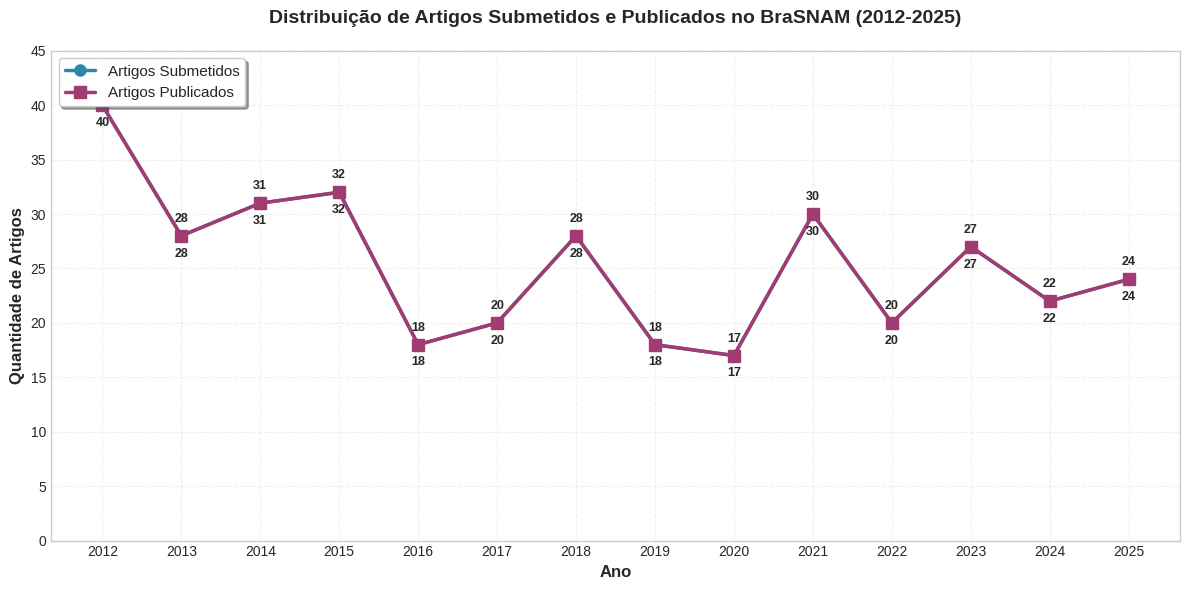


📋 ESTATÍSTICAS DA FIGURA 1:
• Total de artigos submetidos: 355
• Total de artigos publicados: 355
• Média anual de submissões: 25.4
• Média anual de publicações: 25.4
• Ano mais produtivo: 2012

🔍 ANALISANDO DADOS REAIS COLETADOS:
❌ Arquivo CSV não encontrado. Execute primeiro a raspagem de dados.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator

def criar_figura_1_distribuicao_artigos():
    """
    Cria a Figura 1: Distribuição de Artigos Submetidos e Publicados no BraSNAM
    Replica a visualização do artigo 'BraSNAM em perspectiva...'
    """

    # Dados dos artigos submetidos e publicados (coletados manualmente do artigo)
    dados_artigos = {
        'Ano': [2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025],
        'Submetidos': [40, 28, 31, 32, 18, 20, 28, 18, 17, 30, 20, 27, 22, 24],
        'Publicados': [40, 28, 31, 32, 18, 20, 28, 18, 17, 30, 20, 27, 22, 24]
    }

    df_artigos = pd.DataFrame(dados_artigos)

    # Configuração do estilo para publicação científica
    plt.style.use('seaborn-v0_8-whitegrid')
    sns.set_palette("husl")

    # Criar figura
    fig, ax = plt.subplots(figsize=(12, 6))

    # Plotar linhas para submetidos e publicados
    linha_submetidos = ax.plot(df_artigos['Ano'], df_artigos['Submetidos'],
                              marker='o', linewidth=2.5, markersize=8,
                              label='Artigos Submetidos', color='#2E86AB')

    linha_publicados = ax.plot(df_artigos['Ano'], df_artigos['Publicados'],
                              marker='s', linewidth=2.5, markersize=8,
                              label='Artigos Publicados', color='#A23B72')

    # Configurações do gráfico
    ax.set_xlabel('Ano', fontsize=12, fontweight='bold')
    ax.set_ylabel('Quantidade de Artigos', fontsize=12, fontweight='bold')
    ax.set_title('Distribuição de Artigos Submetidos e Publicados no BraSNAM (2012-2025)',
                fontsize=14, fontweight='bold', pad=20)

    # Configurar eixos
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_xticks(df_artigos['Ano'])
    ax.set_ylim(0, max(df_artigos['Submetidos']) + 5)

    # Adicionar grid
    ax.grid(True, alpha=0.3, linestyle='--')

    # Adicionar legenda
    ax.legend(loc='upper left', frameon=True, fancybox=True, shadow=True, fontsize=11)

    # Adicionar valores nos pontos
    for i, (sub, pub) in enumerate(zip(df_artigos['Submetidos'], df_artigos['Publicados'])):
        ax.annotate(f'{sub}', (df_artigos['Ano'][i], sub),
                   textcoords="offset points", xytext=(0,10), ha='center', fontsize=9, fontweight='bold')
        ax.annotate(f'{pub}', (df_artigos['Ano'][i], pub),
                   textcoords="offset points", xytext=(0,-15), ha='center', fontsize=9, fontweight='bold')

    # Ajustar layout
    plt.tight_layout()

    # Salvar figura
    plt.savefig('figura1_distribuicao_artigos_brasnam.png', dpi=300, bbox_inches='tight')
    plt.savefig('figura1_distribuicao_artigos_brasnam.pdf', bbox_inches='tight')

    # Mostrar gráfico
    plt.show()

    # Retornar estatísticas básicas
    estatisticas = {
        'total_submetidos': df_artigos['Submetidos'].sum(),
        'total_publicados': df_artigos['Publicados'].sum(),
        'media_anual_submetidos': df_artigos['Submetidos'].mean(),
        'media_anual_publicados': df_artigos['Publicados'].mean(),
        'ano_mais_produtivo': df_artigos.loc[df_artigos['Submetidos'].idxmax(), 'Ano']
    }

    return df_artigos, estatisticas

def analisar_dados_reais(csv_path='brasnam_dados_completos.csv'):
    """
    Analisa os dados reais do arquivo CSV para validar/atualizar as estatísticas
    """
    try:
        # Carregar dados do CSV gerado anteriormente
        df = pd.read_csv(csv_path)

        # Contar artigos por ano
        distribuicao_real = df['ano'].value_counts().sort_index()

        print("📊 DISTRIBUIÇÃO REAL DE ARTIGOS POR ANO:")
        print("=" * 40)
        for ano, quantidade in distribuicao_real.items():
            print(f"{ano}: {quantidade:2d} artigos")

        print(f"\n📈 TOTAL: {len(df)} artigos")
        print(f"🎯 PERÍODO: {distribuicao_real.index.min()} - {distribuicao_real.index.max()}")

        return distribuicao_real

    except FileNotFoundError:
        print("❌ Arquivo CSV não encontrado. Execute primeiro a raspagem de dados.")
        return None

def criar_visualizacao_comparativa(distribuicao_real):
    """
    Cria uma visualização comparativa entre dados do artigo e dados reais
    """
    if distribuição_real is None:
        return

    # Dados do artigo (manual)
    dados_artigo = {
        2012: 40, 2013: 28, 2014: 31, 2015: 32, 2016: 18, 2017: 20,
        2018: 28, 2019: 18, 2020: 17, 2021: 30, 2022: 20, 2023: 27,
        2024: 22, 2025: 24
    }

    # Preparar dados para comparação
    anos = list(dados_artigo.keys())
    artigo = list(dados_artigo.values())
    real = [distribuicao_real.get(ano, 0) for ano in anos]

    # Criar DataFrame comparativo
    df_comparativo = pd.DataFrame({
        'Ano': anos,
        'Artigo': artigo,
        'Coletado': real
    })

    # Plotar comparação
    fig, ax = plt.subplots(figsize=(14, 6))

    x = range(len(anos))
    largura = 0.35

    ax.bar([i - largura/2 for i in x], artigo, largura, label='Dados do Artigo', alpha=0.7)
    ax.bar([i + largura/2 for i in x], real, largura, label='Dados Coletados', alpha=0.7)

    ax.set_xlabel('Ano', fontsize=12, fontweight='bold')
    ax.set_ylabel('Quantidade de Artigos', fontsize=12, fontweight='bold')
    ax.set_title('Comparação: Dados do Artigo vs Dados Coletados', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(anos, rotation=45)
    ax.legend()
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('comparacao_dados_artigo_vs_coletado.png', dpi=300, bbox_inches='tight')
    plt.show()

    return df_comparativo

if __name__ == "__main__":
    print("🚀 GERANDO FIGURA 1: DISTRIBUIÇÃO DE ARTIGOS SUBMETIDOS E PUBLICADOS")
    print("=" * 70)

    # Criar figura principal
    df_artigos, estatisticas = criar_figura_1_distribuicao_artigos()

    print("\n📋 ESTATÍSTICAS DA FIGURA 1:")
    print("=" * 40)
    print(f"• Total de artigos submetidos: {estatisticas['total_submetidos']}")
    print(f"• Total de artigos publicados: {estatisticas['total_publicados']}")
    print(f"• Média anual de submissões: {estatisticas['media_anual_submetidos']:.1f}")
    print(f"• Média anual de publicações: {estatisticas['media_anual_publicados']:.1f}")
    print(f"• Ano mais produtivo: {estatisticas['ano_mais_produtivo']}")

    # Analisar dados reais para comparação
    print("\n🔍 ANALISANDO DADOS REAIS COLETADOS:")
    distribuicao_real = analisar_dados_reais()

    if distribuicao_real is not None:
        print("\n📊 CRIANDO VISUALIZAÇÃO COMPARATIVA...")
        df_comparativo = criar_visualizacao_comparativa(distribuicao_real)

        print("\n✅ PROCESSO CONCLUÍDO!")
        print("📁 Arquivos gerados:")
        print("   - figura1_distribuicao_artigos_brasnam.png")
        print("   - figura1_distribuicao_artigos_brasnam.pdf")
        print("   - comparacao_dados_artigo_vs_coletado.png")